In [1]:
import torch
import numpy as np

%load_ext autoreload
%autoreload 2

In [85]:
%run activation.py --device 1 -c config_skin_alexnet.json -r skinmodel/checkpoint.pth

*** Loading config file: config_skin_alexnet.json, checkpoint file: skinmodel/checkpoint.pth ***





















  0%|          | 0/10 [00:00<?, ?it/s]

recorded activation map shape: torch.Size([16, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([16, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([16, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([16, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([16, 256, 13, 13]) torch.Size([16, 256, 13, 13])





















 10%|█         | 1/10 [00:11<01:41, 11.33s/it]

recorded activation map shape: torch.Size([16, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([16, 4096]) torch.Size([16, 4096])





















 20%|██        | 2/10 [00:11<01:04,  8.04s/it]

recorded activation map shape: torch.Size([32, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([32, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([32, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([32, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([32, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([32, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([32, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([48, 64, 55, 55]) torch.Size([16, 64, 55, 55])





















 30%|███       | 3/10 [00:11<00:39,  5.69s/it]

recorded activation map shape: torch.Size([48, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([48, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([48, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([48, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([48, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([48, 4096]) torch.Size([16, 4096])





















 40%|████      | 4/10 [00:14<00:28,  4.80s/it]

recorded activation map shape: torch.Size([64, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([64, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([64, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([64, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([64, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([64, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([64, 4096]) torch.Size([16, 4096])





















 50%|█████     | 5/10 [00:14<00:17,  3.44s/it]

recorded activation map shape: torch.Size([80, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([80, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([80, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([80, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([80, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([80, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([80, 4096]) torch.Size([16, 4096])





















 60%|██████    | 6/10 [00:21<00:17,  4.27s/it]

recorded activation map shape: torch.Size([96, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([96, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([96, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([96, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([96, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([96, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([96, 4096]) torch.Size([16, 4096])





















 70%|███████   | 7/10 [00:25<00:13,  4.39s/it]

recorded activation map shape: torch.Size([112, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([112, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([112, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([112, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([112, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([112, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([112, 4096]) torch.Size([16, 4096])





















 80%|████████  | 8/10 [00:26<00:06,  3.21s/it]

recorded activation map shape: torch.Size([128, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([128, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([128, 384, 13, 13]) torch.Size([16, 384, 13, 13])
recorded activation map shape: torch.Size([128, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([128, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([128, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([128, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([144, 64, 55, 55]) torch.Size([16, 64, 55, 55])
recorded activation map shape: torch.Size([144, 192, 27, 27]) torch.Size([16, 192, 27, 27])
recorded activation map shape: torch.Size([144, 384, 13, 13]) torch.Size([16, 384, 13, 13])





















 90%|█████████ | 9/10 [00:29<00:03,  3.25s/it]

recorded activation map shape: torch.Size([144, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([144, 256, 13, 13]) torch.Size([16, 256, 13, 13])
recorded activation map shape: torch.Size([144, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([144, 4096]) torch.Size([16, 4096])
recorded activation map shape: torch.Size([150, 64, 55, 55]) torch.Size([6, 64, 55, 55])





















100%|██████████| 10/10 [00:29<00:00,  2.38s/it]




















recorded activation map shape: torch.Size([150, 192, 27, 27]) torch.Size([6, 192, 27, 27])
recorded activation map shape: torch.Size([150, 384, 13, 13]) torch.Size([6, 384, 13, 13])
recorded activation map shape: torch.Size([150, 256, 13, 13]) torch.Size([6, 256, 13, 13])
recorded activation map shape: torch.Size([150, 256, 13, 13]) torch.Size([6, 256, 13, 13])
recorded activation map shape: torch.Size([150, 4096]) torch.Size([6, 4096])
recorded activation map shape: torch.Size([150, 4096]) torch.Size([6, 4096])


RuntimeError: invalid argument 5: k not in range for dimension at /opt/conda/conda-bld/pytorch_1525909934016/work/aten/src/THC/generic/THCTensorTopK.cu:21

In [36]:
from ablation import *
from activation import *
from culprit import *

In [6]:
config = torch.load('saved/Mnist_LeNet/0227_112433/model_best.pth')['config']
os.environ["CUDA_VISIBLE_DEVICES"]= '1'
resume = 'saved/Mnist_LeNet/0227_112433/model_best.pth'

In [8]:
# extract activation map
extract = ExtractActivation(config, resume) 
extract.evaluate()
extract.save_data('./saved/')

Trainable parameters: 405840
MnistModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=8000, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Trainable parameters: 405840


RuntimeError: Error(s) in loading state_dict for MnistModel:
	While copying the parameter named "fc1.weight", whose dimensions in the model are torch.Size([50, 8000]) and whose dimensions in the checkpoint are torch.Size([50, 320]).

In [23]:
# get culprit score from the activation map
clpt = CulpritNeuronScore('./saved/') 
score = clpt.culprit_freq()
neuron_seq, score =  clpt.get_rank(score)

*** the activation map shape is: [torch.Size([512, 10, 24, 24]), torch.Size([512, 20, 8, 8]), torch.Size([512, 50]), torch.Size([512, 10])] .
*** data loaded ***
*** label size is torch.Size([10000]), positive label ratio is 9898.
*** feature shape is torch.Size([10000, 90]).
*** right_actv shape is torch.Size([9898, 90]), wrong_actv shape is torch.Size([102, 90]).
*** x of shape torch.Size([10000, 90]) is normalized column wise. Before normalize, sum of mean and std for each col are: 30.792844772338867, 416.55279541015625. After normalize: 1.8770639144349843e-05, 90.0.
[45 42  5  0 65 44  6  8 66 39  4  7 40 89 33 54 46 64 74 60 88 22 51 34
  1 75 68 28 63 31 71 69 55 25 21 50 73 70 29 87 49 47 56 15 38 86 72 27
 53 59 84 17 23 18 11 20 30 58 80 76 32 67 52 78 26 77 57  9 10 48  3  2
 43 12 35 13 37 61 83 19 79 16 36 14 62 81 82 85 41 24]
1.371138564610173
1.357970212631967
1.3135142454771964
1.2882408005326205
1.270331550802139
1.2485946529798087
1.2432820250793044
1.2411090735254933

  0%|          | 0/20 [00:00<?, ?it/s]

abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03445652133226395, 'overal_acc': 0.9875, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04318471682071686, 'overal_acc': 0.9853, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.044773002350330354, 'overal_acc': 0.9843, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04148340683579445, 'overal_acc': 0.9857, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036329493474960325, 'overal_acc': 0.9874, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04502343519926071, 'overal_acc': 0.9853, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.039962309980392456, 'overal_acc': 0.9881, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04273369071483612, 'overal_acc': 0.9853, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03417583748102188, 'overal_acc': 0.989, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04667056794166565, 'overal_acc': 0.9829, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03229573268890381, 'overal_acc': 0.9891, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036217901515960695, 'overal_acc': 0.9873, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04655653070211411, 'overal_acc': 0.9851, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03381034432053566, 'overal_acc': 0.9884, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08283428483009338, 'overal_acc': 0.9738, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.033341321516036984, 'overal_acc': 0.9888, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05226859356164932, 'overal_acc': 0.9823, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03422678092122078, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03570641318559647, 'overal_acc': 0.9876, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5504593586921692, 'overal_acc': 0.8143, 'topk_acc': 0.9525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0852693583726883, 'overal_acc': 0.9732, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03428565344810486, 'overal_acc': 0.9887, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03324262690544128, 'overal_acc': 0.9891, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03532578338384628, 'overal_acc': 0.9882, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0318780312538147, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06457240500450134, 'overal_acc': 0.9795, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0394590471804142, 'overal_acc': 0.9862, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03482938501238823, 'overal_acc': 0.9884, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0351900537610054, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859834461212158, 'overal_acc': 0.9872, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034502507376670835, 'overal_acc': 0.9891, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03970153714418411, 'overal_acc': 0.9876, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03557036678791046, 'overal_acc': 0.9883, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03741891345977783, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03486711256504059, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03966877326965332, 'overal_acc': 0.9864, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034120018988847735, 'overal_acc': 0.9891, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0352843132019043, 'overal_acc': 0.9879, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.038410189938545225, 'overal_acc': 0.9866, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03756163477897644, 'overal_acc': 0.9871, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031259263116121296, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04187137016057968, 'overal_acc': 0.9864, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04956619551181793, 'overal_acc': 0.984, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03520447289943695, 'overal_acc': 0.9884, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03587184658050537, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.029401391661167144, 'overal_acc': 0.9901, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0402596998155117, 'overal_acc': 0.987, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11158357536792755, 'overal_acc': 0.9599, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035625475025177, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034322697067260745, 'overal_acc': 0.9886, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03525860931873322, 'overal_acc': 0.9883, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03226604549884796, 'overal_acc': 0.989, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.032086197721958164, 'overal_acc': 0.9893, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034312998759746555, 'overal_acc': 0.9891, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.042924192440509795, 'overal_acc': 0.9858, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03825215049982071, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03596213563680649, 'overal_acc': 0.9878, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0346982773900032, 'overal_acc': 0.9894, 'topk_acc': 0.9995}


100%|██████████| 20/20 [00:00<00:00, 38.23it/s]


{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}
acc is [0.9898, 0.9898, 0.9898, 0.9875, 0.989, 0.9853, 0.9843, 0.9857, 0.9874, 0.9853, 0.9881, 0.9853, 0.989, 0.9898, 0.9829, 0.9891, 0.9873, 0.9851, 0.9884, 0.9738, 0.9898, 0.9888, 0.9823, 0.9886, 0.9882, 0.9876, 0.8143, 0.9732, 0.9887, 0.9891, 0.9882, 0.9895, 0.9795, 0.9885, 0.9862, 0.9884, 0.988, 0.9872, 0.9891, 0.9876, 0.9883, 0.9898, 0.9898, 0.9886, 0.988, 0.9864, 0.9891, 0.9898, 0.9879, 0.9866, 0.9871, 0.9898, 0.9895, 0.9864, 0.984, 0.9884, 0.9886, 0.9901, 0.987, 0.9599, 0.988, 0.9886, 0.9883, 0.989, 0.9885, 0.9896, 0.9884, 0.9881, 0.9893, 0.9891, 0.9898, 0.9858, 0.9875, 0.9878, 0.9894, 0.9814, 0.9871, 0.9898, 0.9898, 0.9894, 0.9877]


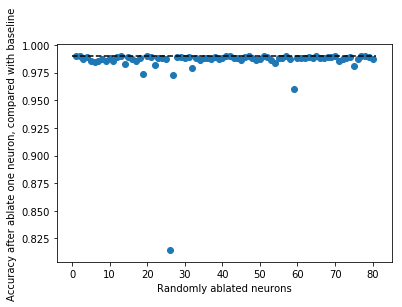

In [25]:
# ablation test on the culprit score
accumulate = False
ablation_test(config, resume, neuron_seq, accumulate)    

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6358776545524597, 'overal_acc': 0.9028, 'topk_acc': 0.9266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5805545628547668, 'overal_acc': 0.8888, 'topk_acc': 0.9473}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.42877229833602903, 'overal_acc': 0.8776, 'topk_acc': 0.9157}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03557036678791046, 'overal_acc': 0.9883, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04318471682071686, 'overal_acc': 0.9853, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0352843132019043, 'overal_acc': 0.9879, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6483145387649536, 'overal_acc': 0.8907, 'topk_acc': 0.9388}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03445652133226395, 'overal_acc': 0.9875, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04273369071483612, 'overal_acc': 0.9853, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.032086197721958164, 'overal_acc': 0.9893, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03229573268890381, 'overal_acc': 0.9891, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08283428483009338, 'overal_acc': 0.9738, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5504593586921692, 'overal_acc': 0.8143, 'topk_acc': 0.9525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04502343519926071, 'overal_acc': 0.9853, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0852693583726883, 'overal_acc': 0.9732, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034322697067260745, 'overal_acc': 0.9886, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03520447289943695, 'overal_acc': 0.9884, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.029401391661167144, 'overal_acc': 0.9901, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035625475025177, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03587184658050537, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03532578338384628, 'overal_acc': 0.9882, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5059265323162079, 'overal_acc': 0.8939, 'topk_acc': 0.9292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03970153714418411, 'overal_acc': 0.9876, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0394590471804142, 'overal_acc': 0.9862, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.044773002350330354, 'overal_acc': 0.9843, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859834461212158, 'overal_acc': 0.9872, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03381034432053566, 'overal_acc': 0.9884, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034120018988847735, 'overal_acc': 0.9891, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05226859356164932, 'overal_acc': 0.9823, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.49564056644439697, 'overal_acc': 0.8934, 'topk_acc': 0.9634}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0318780312538147, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034502507376670835, 'overal_acc': 0.9891, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03570641318559647, 'overal_acc': 0.9876, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.039962309980392456, 'overal_acc': 0.9881, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6616830685615539, 'overal_acc': 0.896, 'topk_acc': 0.9088}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11158357536792755, 'overal_acc': 0.9599, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.033341321516036984, 'overal_acc': 0.9888, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03741891345977783, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034312998759746555, 'overal_acc': 0.9891, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.30729678797721866, 'overal_acc': 0.8989, 'topk_acc': 0.9777}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031259263116121296, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04956619551181793, 'overal_acc': 0.984, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.038410189938545225, 'overal_acc': 0.9866, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03428565344810486, 'overal_acc': 0.9887, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03756163477897644, 'overal_acc': 0.9871, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03966877326965332, 'overal_acc': 0.9864, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03482938501238823, 'overal_acc': 0.9884, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04655653070211411, 'overal_acc': 0.9851, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04667056794166565, 'overal_acc': 0.9829, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03417583748102188, 'overal_acc': 0.989, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036217901515960695, 'overal_acc': 0.9873, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5084781700134278, 'overal_acc': 0.8945, 'topk_acc': 0.9347}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03525860931873322, 'overal_acc': 0.9883, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03825215049982071, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03486711256504059, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0346982773900032, 'overal_acc': 0.9894, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4791167833328247, 'overal_acc': 0.8916, 'topk_acc': 0.9452}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03324262690544128, 'overal_acc': 0.9891, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036329493474960325, 'overal_acc': 0.9874, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0351900537610054, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03596213563680649, 'overal_acc': 0.9878, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0402596998155117, 'overal_acc': 0.987, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.042924192440509795, 'overal_acc': 0.9858, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03226604549884796, 'overal_acc': 0.989, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04187137016057968, 'overal_acc': 0.9864, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06457240500450134, 'overal_acc': 0.9795, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04148340683579445, 'overal_acc': 0.9857, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


100%|██████████| 20/20 [00:00<00:00, 44.62it/s]


{'loss': 0.03422678092122078, 'overal_acc': 0.9886, 'topk_acc': 0.9997}
acc is [0.9898, 0.9885, 0.9898, 0.9028, 0.8888, 0.8776, 0.9898, 0.9883, 0.9853, 0.9814, 0.9898, 0.9879, 0.8907, 0.9875, 0.9894, 0.9853, 0.9893, 0.9877, 0.9891, 0.9738, 0.8143, 0.9898, 0.9853, 0.9732, 0.9898, 0.9886, 0.9884, 0.9901, 0.988, 0.9886, 0.9882, 0.9898, 0.8939, 0.9876, 0.9862, 0.9843, 0.9872, 0.9884, 0.9891, 0.9823, 0.8934, 0.9895, 0.9891, 0.9876, 0.9881, 0.896, 0.9599, 0.9888, 0.9898, 0.9886, 0.9891, 0.8989, 0.9896, 0.9885, 0.9898, 0.9895, 0.984, 0.9866, 0.9887, 0.9871, 0.9882, 0.9864, 0.9884, 0.9851, 0.9829, 0.9898, 0.989, 0.9898, 0.9884, 0.9873, 0.8945, 0.9883, 0.9871, 0.9898, 0.9875, 0.988, 0.9894, 0.8916, 0.989, 0.9891, 0.9874, 0.988, 0.9878, 0.987, 0.9858, 0.989, 0.9864, 0.9795, 0.9857, 0.9881, 0.9886]


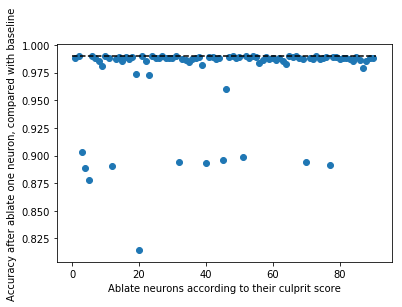

In [27]:
# ablation test on the culprit score
accumulate = False
ablation_test(config, resume, neuron_seq, accumulate) 

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6620933822631836, 'overal_acc': 0.9019, 'topk_acc': 0.9247}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1723078916549683, 'overal_acc': 0.8016, 'topk_acc': 0.8617}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5584150358200073, 'overal_acc': 0.691, 'topk_acc': 0.7489}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5584150358200073, 'overal_acc': 0.691, 'topk_acc': 0.7489}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5002269931793213, 'overal_acc': 0.6903, 'topk_acc': 0.7427}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5102537090301513, 'overal_acc': 0.6854, 'topk_acc': 0.7459}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.655346802520752, 'overal_acc': 0.6791, 'topk_acc': 0.7638}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.655346802520752, 'overal_acc': 0.6791, 'topk_acc': 0.7638}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6877170583724976, 'overal_acc': 0.6764, 'topk_acc': 0.7597}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.991489197731018, 'overal_acc': 0.5796, 'topk_acc': 0.6944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1149763483047486, 'overal_acc': 0.5767, 'topk_acc': 0.6878}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1140609308242797, 'overal_acc': 0.5765, 'topk_acc': 0.6878}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.466140484237671, 'overal_acc': 0.5549, 'topk_acc': 0.6657}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5567653034210207, 'overal_acc': 0.5506, 'topk_acc': 0.6656}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.7856949855804443, 'overal_acc': 0.5419, 'topk_acc': 0.6643}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.6278390434265138, 'overal_acc': 0.5476, 'topk_acc': 0.6637}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.35973180847168, 'overal_acc': 0.4943, 'topk_acc': 0.6485}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.529535140228272, 'overal_acc': 0.3014, 'topk_acc': 0.6978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.529535140228272, 'overal_acc': 0.3014, 'topk_acc': 0.6978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.932780323028564, 'overal_acc': 0.2555, 'topk_acc': 0.6907}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.642512986755371, 'overal_acc': 0.3294, 'topk_acc': 0.5837}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.6425129623413084, 'overal_acc': 0.3294, 'topk_acc': 0.5837}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.8109608386993408, 'overal_acc': 0.3249, 'topk_acc': 0.5824}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.616502440261841, 'overal_acc': 0.3084, 'topk_acc': 0.5761}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.5152472198486326, 'overal_acc': 0.3, 'topk_acc': 0.5823}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.3979610931396484, 'overal_acc': 0.3073, 'topk_acc': 0.5755}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.6369931243896483, 'overal_acc': 0.301, 'topk_acc': 0.5595}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.411025040435791, 'overal_acc': 0.1967, 'topk_acc': 0.5767}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.411025040435791, 'overal_acc': 0.1967, 'topk_acc': 0.5767}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.852751705169678, 'overal_acc': 0.1599, 'topk_acc': 0.5358}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.697178225708008, 'overal_acc': 0.1631, 'topk_acc': 0.496}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.88384368057251, 'overal_acc': 0.1618, 'topk_acc': 0.4915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.030399380493164, 'overal_acc': 0.1531, 'topk_acc': 0.4891}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.437643247985839, 'overal_acc': 0.18, 'topk_acc': 0.4909}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.698966868972778, 'overal_acc': 0.2586, 'topk_acc': 0.4765}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.412973101043701, 'overal_acc': 0.2413, 'topk_acc': 0.4763}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.013735500717163, 'overal_acc': 0.2656, 'topk_acc': 0.46}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.308119636917114, 'overal_acc': 0.2139, 'topk_acc': 0.4078}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.216998416519165, 'overal_acc': 0.2143, 'topk_acc': 0.4139}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.225895859146118, 'overal_acc': 0.2143, 'topk_acc': 0.4146}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.8775345611572267, 'overal_acc': 0.1762, 'topk_acc': 0.4627}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.8992934909820556, 'overal_acc': 0.1814, 'topk_acc': 0.4604}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.9625587215423583, 'overal_acc': 0.1813, 'topk_acc': 0.3877}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.100821119308472, 'overal_acc': 0.1366, 'topk_acc': 0.3827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.6350476490020753, 'overal_acc': 0.1358, 'topk_acc': 0.3697}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.6350535205841066, 'overal_acc': 0.1358, 'topk_acc': 0.3697}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5445627273559572, 'overal_acc': 0.136, 'topk_acc': 0.3823}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.456419341659546, 'overal_acc': 0.1376, 'topk_acc': 0.3825}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4984303131103514, 'overal_acc': 0.0988, 'topk_acc': 0.3542}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.415799137878418, 'overal_acc': 0.0997, 'topk_acc': 0.3548}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3883855262756346, 'overal_acc': 0.1007, 'topk_acc': 0.3612}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3883855262756346, 'overal_acc': 0.1007, 'topk_acc': 0.3612}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.382900860595703, 'overal_acc': 0.101, 'topk_acc': 0.3571}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3791102069854735, 'overal_acc': 0.1007, 'topk_acc': 0.3452}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3327777420043945, 'overal_acc': 0.0979, 'topk_acc': 0.3475}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.334415205001831, 'overal_acc': 0.0979, 'topk_acc': 0.3475}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3309905487060547, 'overal_acc': 0.0987, 'topk_acc': 0.3658}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.349135144805908, 'overal_acc': 0.0997, 'topk_acc': 0.3806}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3106923355102538, 'overal_acc': 0.1018, 'topk_acc': 0.3772}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.259751607131958, 'overal_acc': 0.1459, 'topk_acc': 0.3922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2943733264923094, 'overal_acc': 0.1488, 'topk_acc': 0.2965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2971107234954835, 'overal_acc': 0.1417, 'topk_acc': 0.2939}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.297110845565796, 'overal_acc': 0.1417, 'topk_acc': 0.2939}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2968940296173095, 'overal_acc': 0.1429, 'topk_acc': 0.2928}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2965788124084474, 'overal_acc': 0.1441, 'topk_acc': 0.2928}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2994983757019045, 'overal_acc': 0.14, 'topk_acc': 0.2947}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3033635692596435, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3028047969818117, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3028047969818117, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302779859161377, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3027940406799314, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302771856689453, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302771856689453, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3027682594299317, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}
Ablating the culprit neuron sequence.
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06457240500450134, 'overal_acc': 0.9795, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07556962521076202, 'overal_acc': 0.9758, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5234276943206787, 'overal_acc': 0.8302, 'topk_acc': 0.9825}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5903990149497986, 'overal_acc': 0.8109, 'topk_acc': 0.9786}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6457330237388611, 'overal_acc': 0.7928, 'topk_acc': 0.9731}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5981511349678039, 'overal_acc': 0.8039, 'topk_acc': 0.9742}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4326346701622009, 'overal_acc': 0.8605, 'topk_acc': 0.9744}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4326346701622009, 'overal_acc': 0.8605, 'topk_acc': 0.9744}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4247169288635254, 'overal_acc': 0.8632, 'topk_acc': 0.9792}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3398689196586609, 'overal_acc': 0.8887, 'topk_acc': 0.9906}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4014298093795776, 'overal_acc': 0.8569, 'topk_acc': 0.9871}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4158756603240967, 'overal_acc': 0.8571, 'topk_acc': 0.986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.48618968229293824, 'overal_acc': 0.8314, 'topk_acc': 0.974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5150621319770813, 'overal_acc': 0.829, 'topk_acc': 0.9754}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5589539286613464, 'overal_acc': 0.8069, 'topk_acc': 0.9778}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5472305108070373, 'overal_acc': 0.8193, 'topk_acc': 0.9774}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5689652972221374, 'overal_acc': 0.8217, 'topk_acc': 0.9659}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5689652972221374, 'overal_acc': 0.8217, 'topk_acc': 0.9659}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7053126605033875, 'overal_acc': 0.7941, 'topk_acc': 0.9551}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7689681153297424, 'overal_acc': 0.7572, 'topk_acc': 0.9457}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7164528191566467, 'overal_acc': 0.7882, 'topk_acc': 0.9581}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7629041220664978, 'overal_acc': 0.7592, 'topk_acc': 0.9568}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7760979345321656, 'overal_acc': 0.7751, 'topk_acc': 0.9559}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8856866701126098, 'overal_acc': 0.7359, 'topk_acc': 0.9393}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9199956380844116, 'overal_acc': 0.7264, 'topk_acc': 0.9434}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9411299884796143, 'overal_acc': 0.7135, 'topk_acc': 0.9431}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9411301166534424, 'overal_acc': 0.7135, 'topk_acc': 0.9431}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9642735498428344, 'overal_acc': 0.7025, 'topk_acc': 0.9405}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9358244543075561, 'overal_acc': 0.741, 'topk_acc': 0.9555}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1153089849472047, 'overal_acc': 0.726, 'topk_acc': 0.9533}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1153093389511108, 'overal_acc': 0.726, 'topk_acc': 0.9533}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1835010566711426, 'overal_acc': 0.7043, 'topk_acc': 0.9479}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2078572896957398, 'overal_acc': 0.6915, 'topk_acc': 0.9424}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2201687662124634, 'overal_acc': 0.7121, 'topk_acc': 0.9399}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2201687662124634, 'overal_acc': 0.7121, 'topk_acc': 0.9399}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2201687662124634, 'overal_acc': 0.7121, 'topk_acc': 0.9399}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3134429521560669, 'overal_acc': 0.6674, 'topk_acc': 0.9407}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3478266830444336, 'overal_acc': 0.6753, 'topk_acc': 0.9393}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3904861282348633, 'overal_acc': 0.6397, 'topk_acc': 0.9406}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4277077465057373, 'overal_acc': 0.5995, 'topk_acc': 0.9159}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4898495958328246, 'overal_acc': 0.5277, 'topk_acc': 0.8871}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5270041343688965, 'overal_acc': 0.4915, 'topk_acc': 0.8934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5559271087646485, 'overal_acc': 0.4929, 'topk_acc': 0.8916}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.578996037864685, 'overal_acc': 0.4699, 'topk_acc': 0.882}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5834516075134277, 'overal_acc': 0.5261, 'topk_acc': 0.887}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6669678829193115, 'overal_acc': 0.4756, 'topk_acc': 0.8671}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6819964715957643, 'overal_acc': 0.4905, 'topk_acc': 0.8641}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6872254917144776, 'overal_acc': 0.4832, 'topk_acc': 0.8619}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7626674304962158, 'overal_acc': 0.3965, 'topk_acc': 0.784}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8019902172088622, 'overal_acc': 0.4015, 'topk_acc': 0.7662}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8429431514739991, 'overal_acc': 0.3895, 'topk_acc': 0.7567}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8429431514739991, 'overal_acc': 0.3895, 'topk_acc': 0.7567}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9030861305236817, 'overal_acc': 0.3006, 'topk_acc': 0.6819}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9367681606292724, 'overal_acc': 0.3634, 'topk_acc': 0.7286}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9929767185211182, 'overal_acc': 0.3693, 'topk_acc': 0.7207}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0566723106384277, 'overal_acc': 0.2957, 'topk_acc': 0.5835}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.099186067199707, 'overal_acc': 0.2771, 'topk_acc': 0.5528}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.117153931808472, 'overal_acc': 0.2488, 'topk_acc': 0.5376}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.117153931808472, 'overal_acc': 0.2488, 'topk_acc': 0.5376}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1182118877410887, 'overal_acc': 0.2454, 'topk_acc': 0.5381}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.142495056152344, 'overal_acc': 0.2272, 'topk_acc': 0.5371}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1811285274505616, 'overal_acc': 0.2001, 'topk_acc': 0.5331}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2083250858306886, 'overal_acc': 0.1567, 'topk_acc': 0.5334}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2199603733062743, 'overal_acc': 0.1501, 'topk_acc': 0.5208}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2336639347076415, 'overal_acc': 0.1606, 'topk_acc': 0.4824}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2406047786712646, 'overal_acc': 0.1361, 'topk_acc': 0.4851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.23960965423584, 'overal_acc': 0.1922, 'topk_acc': 0.5375}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2952081722259523, 'overal_acc': 0.1247, 'topk_acc': 0.3646}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2952039333343506, 'overal_acc': 0.1247, 'topk_acc': 0.3647}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.295067936706543, 'overal_acc': 0.1239, 'topk_acc': 0.3669}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2954128791809083, 'overal_acc': 0.1211, 'topk_acc': 0.3685}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2991607730865478, 'overal_acc': 0.1076, 'topk_acc': 0.3335}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3032170307159423, 'overal_acc': 0.1103, 'topk_acc': 0.2855}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30371192817688, 'overal_acc': 0.1262, 'topk_acc': 0.2866}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305427777862549, 'overal_acc': 0.0995, 'topk_acc': 0.287}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055846725463867, 'overal_acc': 0.0993, 'topk_acc': 0.287}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054972091674806, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 1th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03832249926328659, 'overal_acc': 0.9867, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04863782856464386, 'overal_acc': 0.9843, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.042296954894065854, 'overal_acc': 0.9862, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04290690706372261, 'overal_acc': 0.986, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04861919627189636, 'overal_acc': 0.9829, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04861919627189636, 'overal_acc': 0.9829, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.056556291007995606, 'overal_acc': 0.9804, 'topk_acc': 0.999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.056556291007995606, 'overal_acc': 0.9804, 'topk_acc': 0.999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08735306850671769, 'overal_acc': 0.9707, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10536959779262543, 'overal_acc': 0.9664, 'topk_acc': 0.9978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.13280546731948853, 'overal_acc': 0.9583, 'topk_acc': 0.9957}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.19973471927642822, 'overal_acc': 0.9358, 'topk_acc': 0.995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3325240271568298, 'overal_acc': 0.8931, 'topk_acc': 0.9957}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.28955517683029175, 'overal_acc': 0.9046, 'topk_acc': 0.9952}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.353573961687088, 'overal_acc': 0.8864, 'topk_acc': 0.9936}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3535595444202423, 'overal_acc': 0.8864, 'topk_acc': 0.9936}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.34842609481811526, 'overal_acc': 0.8837, 'topk_acc': 0.9924}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.48586154651641844, 'overal_acc': 0.8369, 'topk_acc': 0.9896}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4847647539138794, 'overal_acc': 0.8393, 'topk_acc': 0.9906}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.49849881668090823, 'overal_acc': 0.8233, 'topk_acc': 0.9885}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6662435310363769, 'overal_acc': 0.7556, 'topk_acc': 0.9827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9145892679214478, 'overal_acc': 0.6617, 'topk_acc': 0.9749}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8938924580574036, 'overal_acc': 0.6685, 'topk_acc': 0.9768}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9818627574920654, 'overal_acc': 0.663, 'topk_acc': 0.9704}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0370835609436035, 'overal_acc': 0.6463, 'topk_acc': 0.9682}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8930925294876099, 'overal_acc': 0.674, 'topk_acc': 0.9718}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1466197360992432, 'overal_acc': 0.6124, 'topk_acc': 0.956}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2644715713500976, 'overal_acc': 0.5867, 'topk_acc': 0.9412}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2644715713500976, 'overal_acc': 0.5867, 'topk_acc': 0.9412}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.28140026512146, 'overal_acc': 0.5512, 'topk_acc': 0.9581}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4628235033035277, 'overal_acc': 0.4826, 'topk_acc': 0.9562}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6500567581176757, 'overal_acc': 0.4361, 'topk_acc': 0.9232}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6472465969085692, 'overal_acc': 0.428, 'topk_acc': 0.9202}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.647558642578125, 'overal_acc': 0.4314, 'topk_acc': 0.9222}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.585068091392517, 'overal_acc': 0.4277, 'topk_acc': 0.887}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5162062879562377, 'overal_acc': 0.4298, 'topk_acc': 0.8886}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5147102924346925, 'overal_acc': 0.4606, 'topk_acc': 0.8801}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1396213661193846, 'overal_acc': 0.3149, 'topk_acc': 0.7563}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.098827780532837, 'overal_acc': 0.3131, 'topk_acc': 0.7444}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5472526519775391, 'overal_acc': 0.4881, 'topk_acc': 0.7801}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5027103496551513, 'overal_acc': 0.4789, 'topk_acc': 0.8314}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4870921375274657, 'overal_acc': 0.5238, 'topk_acc': 0.7781}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5512436023712157, 'overal_acc': 0.5147, 'topk_acc': 0.7737}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5866603059768676, 'overal_acc': 0.5118, 'topk_acc': 0.7611}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6235039821624755, 'overal_acc': 0.4939, 'topk_acc': 0.7575}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.622702402496338, 'overal_acc': 0.4942, 'topk_acc': 0.7573}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6227014137268065, 'overal_acc': 0.4942, 'topk_acc': 0.7573}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6307302623748778, 'overal_acc': 0.4914, 'topk_acc': 0.7674}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6431998931884766, 'overal_acc': 0.4423, 'topk_acc': 0.7761}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.913550633239746, 'overal_acc': 0.2714, 'topk_acc': 0.6501}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9910473838806153, 'overal_acc': 0.2252, 'topk_acc': 0.5797}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.027939242553711, 'overal_acc': 0.195, 'topk_acc': 0.5593}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9947132225036621, 'overal_acc': 0.1968, 'topk_acc': 0.6172}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0288386405944823, 'overal_acc': 0.1949, 'topk_acc': 0.6171}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0873709812164307, 'overal_acc': 0.1408, 'topk_acc': 0.5942}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.08751940612793, 'overal_acc': 0.1398, 'topk_acc': 0.595}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.08751940612793, 'overal_acc': 0.1398, 'topk_acc': 0.595}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2198143211364747, 'overal_acc': 0.1196, 'topk_acc': 0.4475}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2198143211364747, 'overal_acc': 0.1196, 'topk_acc': 0.4475}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.203213542175293, 'overal_acc': 0.0947, 'topk_acc': 0.5023}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.206342244720459, 'overal_acc': 0.0934, 'topk_acc': 0.5069}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.217281709289551, 'overal_acc': 0.0959, 'topk_acc': 0.4861}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2306972454071046, 'overal_acc': 0.0984, 'topk_acc': 0.443}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.251589728927612, 'overal_acc': 0.108, 'topk_acc': 0.3775}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2555806728363037, 'overal_acc': 0.112, 'topk_acc': 0.3767}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.265196013259888, 'overal_acc': 0.1016, 'topk_acc': 0.3808}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.245987481689453, 'overal_acc': 0.1199, 'topk_acc': 0.4249}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.272280590057373, 'overal_acc': 0.1575, 'topk_acc': 0.3665}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.280850467681885, 'overal_acc': 0.1356, 'topk_acc': 0.3605}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.288079825592041, 'overal_acc': 0.0975, 'topk_acc': 0.351}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.290167039489746, 'overal_acc': 0.0988, 'topk_acc': 0.3477}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2916960121154784, 'overal_acc': 0.0988, 'topk_acc': 0.3342}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2917184703826905, 'overal_acc': 0.0988, 'topk_acc': 0.3342}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.299301133728027, 'overal_acc': 0.0974, 'topk_acc': 0.2578}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.299301133728027, 'overal_acc': 0.0974, 'topk_acc': 0.2578}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 2th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05226859356164932, 'overal_acc': 0.9823, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06168872530460358, 'overal_acc': 0.9808, 'topk_acc': 0.999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11982514858245849, 'overal_acc': 0.9582, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14995231208801268, 'overal_acc': 0.9429, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2210305606842041, 'overal_acc': 0.9184, 'topk_acc': 0.9909}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.21313149223327638, 'overal_acc': 0.9211, 'topk_acc': 0.9899}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.20983325972557068, 'overal_acc': 0.9238, 'topk_acc': 0.9911}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.20535063910484314, 'overal_acc': 0.9251, 'topk_acc': 0.9909}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23743089799880981, 'overal_acc': 0.9164, 'topk_acc': 0.9849}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23743032121658325, 'overal_acc': 0.9164, 'topk_acc': 0.9849}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.24461988492012024, 'overal_acc': 0.9114, 'topk_acc': 0.9908}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.28510475759506226, 'overal_acc': 0.8965, 'topk_acc': 0.9919}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3863967791557312, 'overal_acc': 0.8608, 'topk_acc': 0.9855}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2978541479587555, 'overal_acc': 0.888, 'topk_acc': 0.9884}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.35202726793289185, 'overal_acc': 0.8672, 'topk_acc': 0.9844}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3744863166809082, 'overal_acc': 0.8583, 'topk_acc': 0.9833}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.40988127374649047, 'overal_acc': 0.8486, 'topk_acc': 0.9823}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3792365384101868, 'overal_acc': 0.8638, 'topk_acc': 0.9842}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5365389682769776, 'overal_acc': 0.8202, 'topk_acc': 0.9623}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5323239362716675, 'overal_acc': 0.8275, 'topk_acc': 0.9619}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5983010731697083, 'overal_acc': 0.8165, 'topk_acc': 0.9515}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5876686486244201, 'overal_acc': 0.817, 'topk_acc': 0.9516}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6057070167541504, 'overal_acc': 0.8065, 'topk_acc': 0.9582}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6402314434051514, 'overal_acc': 0.7886, 'topk_acc': 0.964}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5334721274375915, 'overal_acc': 0.8439, 'topk_acc': 0.9784}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7151320877075196, 'overal_acc': 0.7523, 'topk_acc': 0.9511}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8480316999435424, 'overal_acc': 0.7126, 'topk_acc': 0.9194}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8454128910064698, 'overal_acc': 0.7142, 'topk_acc': 0.9205}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8947413227081299, 'overal_acc': 0.6777, 'topk_acc': 0.9233}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9598149826049804, 'overal_acc': 0.6585, 'topk_acc': 0.9204}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8605692258834838, 'overal_acc': 0.7796, 'topk_acc': 0.9604}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.020314285850525, 'overal_acc': 0.7274, 'topk_acc': 0.9472}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1039253128051758, 'overal_acc': 0.6855, 'topk_acc': 0.9354}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1476852464675904, 'overal_acc': 0.6638, 'topk_acc': 0.9292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2242438302993774, 'overal_acc': 0.614, 'topk_acc': 0.9112}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3099087677001953, 'overal_acc': 0.5935, 'topk_acc': 0.9164}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3105438903808593, 'overal_acc': 0.5939, 'topk_acc': 0.9165}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.355946092224121, 'overal_acc': 0.5809, 'topk_acc': 0.9149}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4299231649398805, 'overal_acc': 0.5533, 'topk_acc': 0.8983}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7276669805526734, 'overal_acc': 0.3869, 'topk_acc': 0.7576}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8000433340072632, 'overal_acc': 0.3259, 'topk_acc': 0.7385}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.85475679397583, 'overal_acc': 0.2947, 'topk_acc': 0.7127}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8671837270736695, 'overal_acc': 0.2713, 'topk_acc': 0.705}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9676533990859986, 'overal_acc': 0.2192, 'topk_acc': 0.6449}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9676533990859986, 'overal_acc': 0.2192, 'topk_acc': 0.6449}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.975121198272705, 'overal_acc': 0.2279, 'topk_acc': 0.6239}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0147267276763916, 'overal_acc': 0.216, 'topk_acc': 0.5772}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2162176280975343, 'overal_acc': 0.1754, 'topk_acc': 0.4268}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2162137443542482, 'overal_acc': 0.1754, 'topk_acc': 0.4267}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2177335887908938, 'overal_acc': 0.1736, 'topk_acc': 0.4261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.096490076828003, 'overal_acc': 0.2314, 'topk_acc': 0.5388}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1074088703155516, 'overal_acc': 0.2194, 'topk_acc': 0.5354}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.186871625518799, 'overal_acc': 0.1629, 'topk_acc': 0.4418}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.188757018661499, 'overal_acc': 0.1604, 'topk_acc': 0.441}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.188756823348999, 'overal_acc': 0.1604, 'topk_acc': 0.441}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1888435161590576, 'overal_acc': 0.1603, 'topk_acc': 0.441}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2196038566589356, 'overal_acc': 0.1643, 'topk_acc': 0.4214}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2457824394226074, 'overal_acc': 0.1753, 'topk_acc': 0.4032}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2457816581726076, 'overal_acc': 0.1753, 'topk_acc': 0.4032}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2699372650146485, 'overal_acc': 0.1564, 'topk_acc': 0.3433}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.232533666229248, 'overal_acc': 0.2125, 'topk_acc': 0.4495}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2661831756591795, 'overal_acc': 0.1258, 'topk_acc': 0.3622}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2692370182037354, 'overal_acc': 0.109, 'topk_acc': 0.3343}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.267183614730835, 'overal_acc': 0.103, 'topk_acc': 0.3519}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2735576805114746, 'overal_acc': 0.1351, 'topk_acc': 0.4026}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2735574607849123, 'overal_acc': 0.1351, 'topk_acc': 0.4026}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2916194747924803, 'overal_acc': 0.1131, 'topk_acc': 0.352}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2914400787353517, 'overal_acc': 0.1198, 'topk_acc': 0.3507}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2914400787353517, 'overal_acc': 0.1198, 'topk_acc': 0.3507}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054658779144286, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054658779144286, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054658779144286, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054658779144286, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054658779144286, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055733348846434, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055733348846434, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055569541931153, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055569541931153, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055569541931153, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 3th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0402596998155117, 'overal_acc': 0.987, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12557115144729614, 'overal_acc': 0.9573, 'topk_acc': 0.9978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12557115144729614, 'overal_acc': 0.9573, 'topk_acc': 0.9978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.177019535779953, 'overal_acc': 0.938, 'topk_acc': 0.9964}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.15173364577293397, 'overal_acc': 0.9474, 'topk_acc': 0.9968}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1522692255973816, 'overal_acc': 0.947, 'topk_acc': 0.9967}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.18557745542526244, 'overal_acc': 0.9357, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1855761263847351, 'overal_acc': 0.9357, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1855761263847351, 'overal_acc': 0.9357, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2128933436393738, 'overal_acc': 0.9253, 'topk_acc': 0.9943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.29614055819511415, 'overal_acc': 0.897, 'topk_acc': 0.9909}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3822210960388184, 'overal_acc': 0.8667, 'topk_acc': 0.9898}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3696694997787476, 'overal_acc': 0.8697, 'topk_acc': 0.9903}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3696694997787476, 'overal_acc': 0.8697, 'topk_acc': 0.9903}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3290992317199707, 'overal_acc': 0.8843, 'topk_acc': 0.9902}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.36323380241394043, 'overal_acc': 0.8706, 'topk_acc': 0.9897}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.38452308626174925, 'overal_acc': 0.8637, 'topk_acc': 0.9883}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.378251473236084, 'overal_acc': 0.8671, 'topk_acc': 0.986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4214454487800598, 'overal_acc': 0.8526, 'topk_acc': 0.9844}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3586390867233276, 'overal_acc': 0.5473, 'topk_acc': 0.8785}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4699066848754883, 'overal_acc': 0.5461, 'topk_acc': 0.8513}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6938258693695067, 'overal_acc': 0.4952, 'topk_acc': 0.8308}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7805243377685547, 'overal_acc': 0.4782, 'topk_acc': 0.8193}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2870754491806031, 'overal_acc': 0.579, 'topk_acc': 0.8641}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3400610263824464, 'overal_acc': 0.5599, 'topk_acc': 0.859}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.438685920715332, 'overal_acc': 0.5294, 'topk_acc': 0.8507}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3934299877166747, 'overal_acc': 0.5136, 'topk_acc': 0.8785}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6133642423629762, 'overal_acc': 0.4705, 'topk_acc': 0.8689}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5926318801879882, 'overal_acc': 0.4838, 'topk_acc': 0.8636}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6343667924880982, 'overal_acc': 0.472, 'topk_acc': 0.8428}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6766887912750243, 'overal_acc': 0.4518, 'topk_acc': 0.8265}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6766887912750243, 'overal_acc': 0.4518, 'topk_acc': 0.8265}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.690455174255371, 'overal_acc': 0.4281, 'topk_acc': 0.7837}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7123167573928832, 'overal_acc': 0.4258, 'topk_acc': 0.7756}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.719402446746826, 'overal_acc': 0.4094, 'topk_acc': 0.7816}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8863866399765015, 'overal_acc': 0.3325, 'topk_acc': 0.7485}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.891903911972046, 'overal_acc': 0.3358, 'topk_acc': 0.7069}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8434793588638305, 'overal_acc': 0.3889, 'topk_acc': 0.644}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7201441787719727, 'overal_acc': 0.384, 'topk_acc': 0.6849}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7320851627349854, 'overal_acc': 0.3423, 'topk_acc': 0.7368}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8273357559204102, 'overal_acc': 0.3235, 'topk_acc': 0.6396}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9376376581192016, 'overal_acc': 0.3157, 'topk_acc': 0.6164}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.131377527618408, 'overal_acc': 0.2866, 'topk_acc': 0.4923}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1437665466308595, 'overal_acc': 0.2861, 'topk_acc': 0.4842}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1161549530029298, 'overal_acc': 0.2822, 'topk_acc': 0.4901}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1161549530029298, 'overal_acc': 0.2822, 'topk_acc': 0.4901}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.125014242553711, 'overal_acc': 0.2849, 'topk_acc': 0.4894}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.125014242553711, 'overal_acc': 0.2849, 'topk_acc': 0.4894}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9776951652526855, 'overal_acc': 0.2867, 'topk_acc': 0.5468}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0357033687591555, 'overal_acc': 0.2534, 'topk_acc': 0.5154}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0795832107543943, 'overal_acc': 0.2422, 'topk_acc': 0.4531}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.07508994140625, 'overal_acc': 0.2397, 'topk_acc': 0.4622}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1541215911865232, 'overal_acc': 0.2387, 'topk_acc': 0.5033}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1536775451660155, 'overal_acc': 0.2311, 'topk_acc': 0.4979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1692361408233642, 'overal_acc': 0.1959, 'topk_acc': 0.4552}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1982252235412596, 'overal_acc': 0.1475, 'topk_acc': 0.4831}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1963122985839845, 'overal_acc': 0.1858, 'topk_acc': 0.5556}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.199600451660156, 'overal_acc': 0.1784, 'topk_acc': 0.5477}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.198883567428589, 'overal_acc': 0.1948, 'topk_acc': 0.5513}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2370033252716066, 'overal_acc': 0.1542, 'topk_acc': 0.5158}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304447618484497, 'overal_acc': 0.1125, 'topk_acc': 0.3603}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30936047744751, 'overal_acc': 0.1215, 'topk_acc': 0.3826}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3067885929107668, 'overal_acc': 0.098, 'topk_acc': 0.2881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3067885929107668, 'overal_acc': 0.098, 'topk_acc': 0.2881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306806001281738, 'overal_acc': 0.098, 'topk_acc': 0.2881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306806001281738, 'overal_acc': 0.098, 'topk_acc': 0.2881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306806001281738, 'overal_acc': 0.098, 'topk_acc': 0.2881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306806001281738, 'overal_acc': 0.098, 'topk_acc': 0.2881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306556059265137, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306556059265137, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306556059265137, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306556059265137, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058986583709715, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3060235469818116, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3061803771972658, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305543856048584, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305543856048584, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056450469970704, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305649966430664, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 4th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0481375571846962, 'overal_acc': 0.9842, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06105253536701202, 'overal_acc': 0.9801, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07268158881664276, 'overal_acc': 0.9763, 'topk_acc': 0.9988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11285814077854156, 'overal_acc': 0.9614, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14162270708084107, 'overal_acc': 0.9536, 'topk_acc': 0.9959}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1555597198009491, 'overal_acc': 0.9481, 'topk_acc': 0.9965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1711503185749054, 'overal_acc': 0.9419, 'topk_acc': 0.9966}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23639741630554198, 'overal_acc': 0.9196, 'topk_acc': 0.9912}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3118982249736786, 'overal_acc': 0.894, 'topk_acc': 0.9857}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.313161057138443, 'overal_acc': 0.8922, 'topk_acc': 0.9871}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3123711040496826, 'overal_acc': 0.8903, 'topk_acc': 0.9871}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3263136559963226, 'overal_acc': 0.8863, 'topk_acc': 0.9867}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3219498456001282, 'overal_acc': 0.8861, 'topk_acc': 0.9875}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.32922858953475953, 'overal_acc': 0.8843, 'topk_acc': 0.9861}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3227538674354553, 'overal_acc': 0.8891, 'topk_acc': 0.9864}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3769830078125, 'overal_acc': 0.8664, 'topk_acc': 0.9858}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3151460998535156, 'overal_acc': 0.8981, 'topk_acc': 0.9875}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3854612506389618, 'overal_acc': 0.8827, 'topk_acc': 0.981}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.37915675678253175, 'overal_acc': 0.8857, 'topk_acc': 0.9851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.47439231967926027, 'overal_acc': 0.8433, 'topk_acc': 0.9809}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5769766836166382, 'overal_acc': 0.7943, 'topk_acc': 0.9794}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6775675312042236, 'overal_acc': 0.7351, 'topk_acc': 0.9762}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.908698712348938, 'overal_acc': 0.6695, 'topk_acc': 0.9287}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8837817668914795, 'overal_acc': 0.6667, 'topk_acc': 0.9308}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7972694386482239, 'overal_acc': 0.715, 'topk_acc': 0.9517}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8121123694419861, 'overal_acc': 0.7324, 'topk_acc': 0.9529}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9387464939117431, 'overal_acc': 0.6996, 'topk_acc': 0.9311}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.017257280921936, 'overal_acc': 0.6745, 'topk_acc': 0.9189}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0032677326202393, 'overal_acc': 0.7006, 'topk_acc': 0.932}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0032363258361816, 'overal_acc': 0.7016, 'topk_acc': 0.932}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0416349645614624, 'overal_acc': 0.6913, 'topk_acc': 0.9261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0510888872146606, 'overal_acc': 0.6774, 'topk_acc': 0.9234}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0510888872146606, 'overal_acc': 0.6774, 'topk_acc': 0.9234}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0949488473892213, 'overal_acc': 0.6344, 'topk_acc': 0.9279}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3996617753982543, 'overal_acc': 0.4437, 'topk_acc': 0.8693}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3997645128250122, 'overal_acc': 0.4437, 'topk_acc': 0.8694}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4549952253341676, 'overal_acc': 0.4447, 'topk_acc': 0.8482}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4292330945968628, 'overal_acc': 0.5207, 'topk_acc': 0.865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4880126838684082, 'overal_acc': 0.4681, 'topk_acc': 0.8588}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4944201000213624, 'overal_acc': 0.4655, 'topk_acc': 0.8512}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.538084654045105, 'overal_acc': 0.4579, 'topk_acc': 0.8315}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5974581165313722, 'overal_acc': 0.4242, 'topk_acc': 0.7966}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6209904592514037, 'overal_acc': 0.4391, 'topk_acc': 0.7724}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.655336198234558, 'overal_acc': 0.4376, 'topk_acc': 0.7498}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.78374974899292, 'overal_acc': 0.3876, 'topk_acc': 0.7101}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8058705743789674, 'overal_acc': 0.3858, 'topk_acc': 0.695}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8058803281784057, 'overal_acc': 0.3858, 'topk_acc': 0.695}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8059571462631225, 'overal_acc': 0.3856, 'topk_acc': 0.6947}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9114151964187622, 'overal_acc': 0.3117, 'topk_acc': 0.6363}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9413860427856446, 'overal_acc': 0.3087, 'topk_acc': 0.6054}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9789433917999268, 'overal_acc': 0.2572, 'topk_acc': 0.6265}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0608914493560793, 'overal_acc': 0.2128, 'topk_acc': 0.5813}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.133183109664917, 'overal_acc': 0.1676, 'topk_acc': 0.5313}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1740645526885984, 'overal_acc': 0.3096, 'topk_acc': 0.5226}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1848729480743407, 'overal_acc': 0.3059, 'topk_acc': 0.5169}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.206619482421875, 'overal_acc': 0.3046, 'topk_acc': 0.5111}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.206617517089844, 'overal_acc': 0.3045, 'topk_acc': 0.5111}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2624991325378416, 'overal_acc': 0.2255, 'topk_acc': 0.4215}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.270772111129761, 'overal_acc': 0.217, 'topk_acc': 0.3858}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.270772111129761, 'overal_acc': 0.217, 'topk_acc': 0.3858}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.272601596069336, 'overal_acc': 0.2169, 'topk_acc': 0.3833}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.284029859161377, 'overal_acc': 0.2024, 'topk_acc': 0.337}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.307648569869995, 'overal_acc': 0.1983, 'topk_acc': 0.3802}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3165350845336916, 'overal_acc': 0.2204, 'topk_acc': 0.3571}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.347875716781616, 'overal_acc': 0.2215, 'topk_acc': 0.3925}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3172891429901123, 'overal_acc': 0.17, 'topk_acc': 0.3619}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3172891429901123, 'overal_acc': 0.17, 'topk_acc': 0.3619}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.326260493850708, 'overal_acc': 0.1718, 'topk_acc': 0.3671}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059758644104003, 'overal_acc': 0.1419, 'topk_acc': 0.2926}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3067099796295167, 'overal_acc': 0.1412, 'topk_acc': 0.2908}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306332903289795, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306470777130127, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306470777130127, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306470777130127, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306470777130127, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306470777130127, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306455249404907, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306455249404907, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 5th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08283428483009338, 'overal_acc': 0.9738, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0970016709804535, 'overal_acc': 0.9713, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0970016709804535, 'overal_acc': 0.9713, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11074312994480133, 'overal_acc': 0.9669, 'topk_acc': 0.9978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10868411827087403, 'overal_acc': 0.9675, 'topk_acc': 0.9978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14296602969169617, 'overal_acc': 0.9552, 'topk_acc': 0.9961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1687735855102539, 'overal_acc': 0.9466, 'topk_acc': 0.9955}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.28043995118141174, 'overal_acc': 0.9001, 'topk_acc': 0.9934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.28043995118141174, 'overal_acc': 0.9001, 'topk_acc': 0.9934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.28043995118141174, 'overal_acc': 0.9001, 'topk_acc': 0.9934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.22794340686798095, 'overal_acc': 0.918, 'topk_acc': 0.9931}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.22794340686798095, 'overal_acc': 0.918, 'topk_acc': 0.9931}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3461578427314758, 'overal_acc': 0.8819, 'topk_acc': 0.9726}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.695398819732666, 'overal_acc': 0.8219, 'topk_acc': 0.9567}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.695398819732666, 'overal_acc': 0.8219, 'topk_acc': 0.9567}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7424576984405518, 'overal_acc': 0.8066, 'topk_acc': 0.9567}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6851911308288574, 'overal_acc': 0.7871, 'topk_acc': 0.9802}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6494111363410949, 'overal_acc': 0.7997, 'topk_acc': 0.9793}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6534784873962403, 'overal_acc': 0.7986, 'topk_acc': 0.9779}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6944203460693359, 'overal_acc': 0.7855, 'topk_acc': 0.9746}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6944203460693359, 'overal_acc': 0.7855, 'topk_acc': 0.9746}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7912661827087403, 'overal_acc': 0.7525, 'topk_acc': 0.9656}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8121611581802368, 'overal_acc': 0.7428, 'topk_acc': 0.9657}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.706233695602417, 'overal_acc': 0.7566, 'topk_acc': 0.9603}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6553608780860901, 'overal_acc': 0.7572, 'topk_acc': 0.9622}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7036357280731201, 'overal_acc': 0.7439, 'topk_acc': 0.9597}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6827096292495728, 'overal_acc': 0.7375, 'topk_acc': 0.9663}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1959500759124755, 'overal_acc': 0.5542, 'topk_acc': 0.8817}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0676461011886598, 'overal_acc': 0.5911, 'topk_acc': 0.9063}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1057227323532104, 'overal_acc': 0.6071, 'topk_acc': 0.9032}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1057227323532104, 'overal_acc': 0.6071, 'topk_acc': 0.9032}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1731879161834717, 'overal_acc': 0.5627, 'topk_acc': 0.8519}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4380420177459716, 'overal_acc': 0.4687, 'topk_acc': 0.8149}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4614144525527955, 'overal_acc': 0.5015, 'topk_acc': 0.818}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4614144525527955, 'overal_acc': 0.5015, 'topk_acc': 0.818}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5440769256591798, 'overal_acc': 0.5006, 'topk_acc': 0.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4215101055145263, 'overal_acc': 0.5024, 'topk_acc': 0.817}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4033926824569702, 'overal_acc': 0.4932, 'topk_acc': 0.8277}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2410516288757325, 'overal_acc': 0.5606, 'topk_acc': 0.8379}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.130218977546692, 'overal_acc': 0.6042, 'topk_acc': 0.8546}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1851164735794066, 'overal_acc': 0.5867, 'topk_acc': 0.8481}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2088104639053345, 'overal_acc': 0.5823, 'topk_acc': 0.8474}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2088104639053345, 'overal_acc': 0.5823, 'topk_acc': 0.8474}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.302205521583557, 'overal_acc': 0.5341, 'topk_acc': 0.8437}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4012976881027221, 'overal_acc': 0.4883, 'topk_acc': 0.8173}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4267843881607056, 'overal_acc': 0.4971, 'topk_acc': 0.8118}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.576552349281311, 'overal_acc': 0.4532, 'topk_acc': 0.7728}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.573275007247925, 'overal_acc': 0.4632, 'topk_acc': 0.744}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7086433473587037, 'overal_acc': 0.3535, 'topk_acc': 0.7423}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8266533824920654, 'overal_acc': 0.3368, 'topk_acc': 0.6982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8925733688354491, 'overal_acc': 0.4076, 'topk_acc': 0.6504}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9264440425872802, 'overal_acc': 0.3771, 'topk_acc': 0.6537}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9842788955688477, 'overal_acc': 0.328, 'topk_acc': 0.6281}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.02345758934021, 'overal_acc': 0.2964, 'topk_acc': 0.5973}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.122744080352783, 'overal_acc': 0.1866, 'topk_acc': 0.5281}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1268249839782714, 'overal_acc': 0.1748, 'topk_acc': 0.5268}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1611205574035646, 'overal_acc': 0.1239, 'topk_acc': 0.561}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.174057696533203, 'overal_acc': 0.1199, 'topk_acc': 0.5507}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2816504386901855, 'overal_acc': 0.0945, 'topk_acc': 0.4751}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2891205352783204, 'overal_acc': 0.0948, 'topk_acc': 0.4358}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3005284076690673, 'overal_acc': 0.0971, 'topk_acc': 0.4182}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3205950378417968, 'overal_acc': 0.093, 'topk_acc': 0.4052}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4010668365478516, 'overal_acc': 0.0899, 'topk_acc': 0.2827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4012017066955567, 'overal_acc': 0.0899, 'topk_acc': 0.2827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.418467383956909, 'overal_acc': 0.0898, 'topk_acc': 0.2503}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4216075435638427, 'overal_acc': 0.0898, 'topk_acc': 0.2498}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.421516994476318, 'overal_acc': 0.0898, 'topk_acc': 0.2489}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4064896896362304, 'overal_acc': 0.0898, 'topk_acc': 0.2303}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4113127822875975, 'overal_acc': 0.0892, 'topk_acc': 0.2851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3963273761749266, 'overal_acc': 0.0892, 'topk_acc': 0.2848}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2936993423461915, 'overal_acc': 0.1108, 'topk_acc': 0.3618}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306107418823242, 'overal_acc': 0.098, 'topk_acc': 0.2846}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306107418823242, 'overal_acc': 0.098, 'topk_acc': 0.2846}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056759323120115, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056467750549317, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056450469970704, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305649966430664, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 6th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03744850851297379, 'overal_acc': 0.9864, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05023886686563492, 'overal_acc': 0.9819, 'topk_acc': 0.999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1399414197444916, 'overal_acc': 0.954, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.15867603673934935, 'overal_acc': 0.947, 'topk_acc': 0.9957}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.15649803075790406, 'overal_acc': 0.949, 'topk_acc': 0.9953}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.15649803075790406, 'overal_acc': 0.949, 'topk_acc': 0.9953}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1907238172531128, 'overal_acc': 0.9382, 'topk_acc': 0.9935}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1907238172531128, 'overal_acc': 0.9382, 'topk_acc': 0.9935}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8399029331207275, 'overal_acc': 0.7668, 'topk_acc': 0.9526}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8881977767944336, 'overal_acc': 0.7397, 'topk_acc': 0.9486}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8881977767944336, 'overal_acc': 0.7397, 'topk_acc': 0.9486}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8520238868713379, 'overal_acc': 0.7471, 'topk_acc': 0.9566}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5711591158866882, 'overal_acc': 0.8131, 'topk_acc': 0.9711}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6669183187484741, 'overal_acc': 0.7839, 'topk_acc': 0.959}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7275077669143677, 'overal_acc': 0.764, 'topk_acc': 0.9511}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.41583861389160154, 'overal_acc': 0.8652, 'topk_acc': 0.9684}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3760640256881714, 'overal_acc': 0.8752, 'topk_acc': 0.9767}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.44948930253982544, 'overal_acc': 0.8521, 'topk_acc': 0.965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4817343494415283, 'overal_acc': 0.8412, 'topk_acc': 0.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4817343494415283, 'overal_acc': 0.8412, 'topk_acc': 0.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5069451629638672, 'overal_acc': 0.8285, 'topk_acc': 0.9565}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6106635087966918, 'overal_acc': 0.7943, 'topk_acc': 0.9474}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6167517287254334, 'overal_acc': 0.7949, 'topk_acc': 0.9434}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7241922055244446, 'overal_acc': 0.7666, 'topk_acc': 0.9224}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6860952903747558, 'overal_acc': 0.7763, 'topk_acc': 0.928}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8736870761871338, 'overal_acc': 0.722, 'topk_acc': 0.8952}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8736870761871338, 'overal_acc': 0.722, 'topk_acc': 0.8952}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.125386735343933, 'overal_acc': 0.6109, 'topk_acc': 0.871}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2487153240203857, 'overal_acc': 0.5803, 'topk_acc': 0.8362}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2485208406448365, 'overal_acc': 0.5803, 'topk_acc': 0.8362}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.36575708694458, 'overal_acc': 0.5459, 'topk_acc': 0.7876}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3988504667282105, 'overal_acc': 0.5181, 'topk_acc': 0.7767}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3988504667282105, 'overal_acc': 0.5181, 'topk_acc': 0.7767}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5150775531768799, 'overal_acc': 0.4801, 'topk_acc': 0.7423}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4081462354660035, 'overal_acc': 0.5006, 'topk_acc': 0.7627}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3158773355484008, 'overal_acc': 0.5269, 'topk_acc': 0.8031}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3415813575744628, 'overal_acc': 0.5173, 'topk_acc': 0.7993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.314483557510376, 'overal_acc': 0.5368, 'topk_acc': 0.8346}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4245819511413573, 'overal_acc': 0.4547, 'topk_acc': 0.8067}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.593688881111145, 'overal_acc': 0.4124, 'topk_acc': 0.7092}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5982441621780394, 'overal_acc': 0.4088, 'topk_acc': 0.7078}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.669682392883301, 'overal_acc': 0.372, 'topk_acc': 0.6895}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7207358655929565, 'overal_acc': 0.3528, 'topk_acc': 0.6655}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7048457099914551, 'overal_acc': 0.365, 'topk_acc': 0.6864}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7048457099914551, 'overal_acc': 0.365, 'topk_acc': 0.6864}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.040069793701172, 'overal_acc': 0.236, 'topk_acc': 0.5753}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0710738723754885, 'overal_acc': 0.2101, 'topk_acc': 0.5232}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.121360540771484, 'overal_acc': 0.2021, 'topk_acc': 0.4915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2081456993103026, 'overal_acc': 0.1582, 'topk_acc': 0.4822}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.215447999572754, 'overal_acc': 0.1491, 'topk_acc': 0.4765}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.138943468475342, 'overal_acc': 0.1434, 'topk_acc': 0.5326}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.197724542617798, 'overal_acc': 0.1182, 'topk_acc': 0.4905}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.183335344314575, 'overal_acc': 0.2534, 'topk_acc': 0.5192}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.182531415939331, 'overal_acc': 0.252, 'topk_acc': 0.5233}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1899411640167235, 'overal_acc': 0.2581, 'topk_acc': 0.4801}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.205288716506958, 'overal_acc': 0.2683, 'topk_acc': 0.4546}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.205288716506958, 'overal_acc': 0.2683, 'topk_acc': 0.4546}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2176734516143797, 'overal_acc': 0.2423, 'topk_acc': 0.4512}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2217378582000733, 'overal_acc': 0.2527, 'topk_acc': 0.4173}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.203303421020508, 'overal_acc': 0.1916, 'topk_acc': 0.4408}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2291776985168457, 'overal_acc': 0.2014, 'topk_acc': 0.38}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.235832556915283, 'overal_acc': 0.2445, 'topk_acc': 0.3394}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2352802253723145, 'overal_acc': 0.2585, 'topk_acc': 0.342}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2428152168273927, 'overal_acc': 0.2052, 'topk_acc': 0.3525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.243692200088501, 'overal_acc': 0.2038, 'topk_acc': 0.3512}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2814553314208985, 'overal_acc': 0.1634, 'topk_acc': 0.3274}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.282132494354248, 'overal_acc': 0.1437, 'topk_acc': 0.3278}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066035915374754, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066035915374754, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066035915374754, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3065406890869142, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3064784454345704, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305838885116577, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305838885116577, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305782049560547, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305856886291504, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 7th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03921156257390976, 'overal_acc': 0.9863, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.043564195680618284, 'overal_acc': 0.9851, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.043564195680618284, 'overal_acc': 0.9851, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.043564195680618284, 'overal_acc': 0.9851, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04573092368841171, 'overal_acc': 0.9842, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.054185168337821964, 'overal_acc': 0.9821, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06406828923225402, 'overal_acc': 0.9792, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06913409867286682, 'overal_acc': 0.9775, 'topk_acc': 0.9986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07103420383930206, 'overal_acc': 0.9775, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08965997807979584, 'overal_acc': 0.9713, 'topk_acc': 0.9975}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.089060653591156, 'overal_acc': 0.9709, 'topk_acc': 0.9978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10172842583656311, 'overal_acc': 0.9677, 'topk_acc': 0.997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11296020982265473, 'overal_acc': 0.9641, 'topk_acc': 0.9972}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12426954131126404, 'overal_acc': 0.9625, 'topk_acc': 0.9961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.13361413943767547, 'overal_acc': 0.9585, 'topk_acc': 0.9963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.13361413943767547, 'overal_acc': 0.9585, 'topk_acc': 0.9963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.16565788469314574, 'overal_acc': 0.9485, 'topk_acc': 0.9938}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17089396481513977, 'overal_acc': 0.9469, 'topk_acc': 0.9936}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2132359178543091, 'overal_acc': 0.9316, 'topk_acc': 0.9892}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.30417980690002444, 'overal_acc': 0.8979, 'topk_acc': 0.9851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.30417980690002444, 'overal_acc': 0.8979, 'topk_acc': 0.9851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3636125560760498, 'overal_acc': 0.8733, 'topk_acc': 0.9848}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3636125560760498, 'overal_acc': 0.8733, 'topk_acc': 0.9848}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5147348127365112, 'overal_acc': 0.8167, 'topk_acc': 0.9754}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5177948735237121, 'overal_acc': 0.8164, 'topk_acc': 0.9738}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7422672904014588, 'overal_acc': 0.7331, 'topk_acc': 0.9525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.802805552482605, 'overal_acc': 0.7132, 'topk_acc': 0.9392}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4490036487579345, 'overal_acc': 0.5013, 'topk_acc': 0.8884}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2443312854766844, 'overal_acc': 0.334, 'topk_acc': 0.6091}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.003411521148682, 'overal_acc': 0.3755, 'topk_acc': 0.6195}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9946693492889405, 'overal_acc': 0.3253, 'topk_acc': 0.6813}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9946695812225341, 'overal_acc': 0.3253, 'topk_acc': 0.6813}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8108329458236694, 'overal_acc': 0.381, 'topk_acc': 0.6889}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9399994375228882, 'overal_acc': 0.3604, 'topk_acc': 0.6602}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.073454955673218, 'overal_acc': 0.3142, 'topk_acc': 0.6698}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0124917961120605, 'overal_acc': 0.3334, 'topk_acc': 0.6852}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9894176181793213, 'overal_acc': 0.3409, 'topk_acc': 0.6934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.771771711730957, 'overal_acc': 0.3581, 'topk_acc': 0.6878}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7452141660690308, 'overal_acc': 0.3287, 'topk_acc': 0.7361}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8772276258468628, 'overal_acc': 0.1982, 'topk_acc': 0.7185}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8774191417694093, 'overal_acc': 0.1895, 'topk_acc': 0.7047}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9123649354934693, 'overal_acc': 0.2193, 'topk_acc': 0.639}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.843401971244812, 'overal_acc': 0.2916, 'topk_acc': 0.5875}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9009849180221559, 'overal_acc': 0.2912, 'topk_acc': 0.5305}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.877848839378357, 'overal_acc': 0.2671, 'topk_acc': 0.6056}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.979786273574829, 'overal_acc': 0.1941, 'topk_acc': 0.5862}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9804675621032715, 'overal_acc': 0.1946, 'topk_acc': 0.5858}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.001437805557251, 'overal_acc': 0.1876, 'topk_acc': 0.5664}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.963718356323242, 'overal_acc': 0.1877, 'topk_acc': 0.6463}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9844989070892334, 'overal_acc': 0.1771, 'topk_acc': 0.6512}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9845101196289063, 'overal_acc': 0.1771, 'topk_acc': 0.6512}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0694110115051267, 'overal_acc': 0.1983, 'topk_acc': 0.549}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.091223773956299, 'overal_acc': 0.1961, 'topk_acc': 0.5349}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1568100124359133, 'overal_acc': 0.1798, 'topk_acc': 0.5165}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.144540969085693, 'overal_acc': 0.1887, 'topk_acc': 0.4646}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.173682642364502, 'overal_acc': 0.1716, 'topk_acc': 0.3933}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.163877530670166, 'overal_acc': 0.1816, 'topk_acc': 0.4364}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1912283725738524, 'overal_acc': 0.1656, 'topk_acc': 0.412}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.196558993911743, 'overal_acc': 0.1936, 'topk_acc': 0.5191}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.206448175430298, 'overal_acc': 0.1439, 'topk_acc': 0.5136}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.204244226837158, 'overal_acc': 0.1759, 'topk_acc': 0.4798}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.22355562210083, 'overal_acc': 0.1552, 'topk_acc': 0.4144}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2787422542572022, 'overal_acc': 0.1253, 'topk_acc': 0.3445}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.279459886932373, 'overal_acc': 0.1331, 'topk_acc': 0.3393}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2993059631347657, 'overal_acc': 0.1213, 'topk_acc': 0.2828}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.300583929824829, 'overal_acc': 0.1181, 'topk_acc': 0.268}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3009477462768553, 'overal_acc': 0.099, 'topk_acc': 0.2676}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3044316478729248, 'overal_acc': 0.1171, 'topk_acc': 0.2609}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3062273036956786, 'overal_acc': 0.098, 'topk_acc': 0.2951}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305775643157959, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057749839782713, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058501792907715, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055772747039796, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055772747039796, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055772747039796, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055772747039796, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305675750732422, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 8th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03749027879238129, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.040534054338932035, 'overal_acc': 0.9867, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12962962296009065, 'overal_acc': 0.9532, 'topk_acc': 0.9965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11019326162338257, 'overal_acc': 0.9616, 'topk_acc': 0.9977}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.128015736246109, 'overal_acc': 0.9577, 'topk_acc': 0.9969}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1133374370098114, 'overal_acc': 0.9624, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1192141842365265, 'overal_acc': 0.9606, 'topk_acc': 0.9975}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11117449996471405, 'overal_acc': 0.9627, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.09821338555812836, 'overal_acc': 0.9682, 'topk_acc': 0.9983}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1279892627954483, 'overal_acc': 0.9562, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1279892627954483, 'overal_acc': 0.9562, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12662452933788299, 'overal_acc': 0.9599, 'topk_acc': 0.9977}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1362646779537201, 'overal_acc': 0.9576, 'topk_acc': 0.9976}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.20917025883197785, 'overal_acc': 0.9308, 'topk_acc': 0.9963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.30473136115074156, 'overal_acc': 0.8982, 'topk_acc': 0.9951}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.27219003138542175, 'overal_acc': 0.906, 'topk_acc': 0.9949}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.29806690068244934, 'overal_acc': 0.8972, 'topk_acc': 0.9908}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.38244913606643677, 'overal_acc': 0.8623, 'topk_acc': 0.9865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.42067752695083616, 'overal_acc': 0.8459, 'topk_acc': 0.9845}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5643227400779725, 'overal_acc': 0.7898, 'topk_acc': 0.9775}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5702023771286011, 'overal_acc': 0.7837, 'topk_acc': 0.9779}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6065941283226013, 'overal_acc': 0.7756, 'topk_acc': 0.9715}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7978260168075562, 'overal_acc': 0.7068, 'topk_acc': 0.9544}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0495612029075623, 'overal_acc': 0.6279, 'topk_acc': 0.9201}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9184193487167358, 'overal_acc': 0.6583, 'topk_acc': 0.9376}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8895388737678528, 'overal_acc': 0.6586, 'topk_acc': 0.9395}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8877504972457886, 'overal_acc': 0.6761, 'topk_acc': 0.9391}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.881987627696991, 'overal_acc': 0.6734, 'topk_acc': 0.9424}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9133080586433411, 'overal_acc': 0.662, 'topk_acc': 0.9418}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9761089964866638, 'overal_acc': 0.6458, 'topk_acc': 0.9362}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1978354911804199, 'overal_acc': 0.5636, 'topk_acc': 0.9082}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.197827975654602, 'overal_acc': 0.5632, 'topk_acc': 0.9086}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.197827975654602, 'overal_acc': 0.5632, 'topk_acc': 0.9086}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1422960321426392, 'overal_acc': 0.61, 'topk_acc': 0.9418}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1422960321426392, 'overal_acc': 0.61, 'topk_acc': 0.9418}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.355468856048584, 'overal_acc': 0.5531, 'topk_acc': 0.9154}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4617057708740235, 'overal_acc': 0.5504, 'topk_acc': 0.8906}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6483324598312379, 'overal_acc': 0.453, 'topk_acc': 0.8786}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2821192312240601, 'overal_acc': 0.6028, 'topk_acc': 0.8842}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2500195371627807, 'overal_acc': 0.633, 'topk_acc': 0.8601}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.402745719718933, 'overal_acc': 0.5692, 'topk_acc': 0.8814}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5937294832229614, 'overal_acc': 0.4754, 'topk_acc': 0.7965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.636039274597168, 'overal_acc': 0.542, 'topk_acc': 0.8708}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6699435209274291, 'overal_acc': 0.5835, 'topk_acc': 0.8639}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7368785173416137, 'overal_acc': 0.5411, 'topk_acc': 0.8378}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7828630353927613, 'overal_acc': 0.4879, 'topk_acc': 0.7831}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8032200300216674, 'overal_acc': 0.5251, 'topk_acc': 0.7982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.802946761894226, 'overal_acc': 0.5258, 'topk_acc': 0.7985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8338602468490601, 'overal_acc': 0.5103, 'topk_acc': 0.7735}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8693321054458618, 'overal_acc': 0.4514, 'topk_acc': 0.7288}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.947111580657959, 'overal_acc': 0.3911, 'topk_acc': 0.6456}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9781450206756592, 'overal_acc': 0.3787, 'topk_acc': 0.6562}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9781196266174317, 'overal_acc': 0.3787, 'topk_acc': 0.6562}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9781196266174317, 'overal_acc': 0.3787, 'topk_acc': 0.6562}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.151705280685425, 'overal_acc': 0.2447, 'topk_acc': 0.5261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.170830492401123, 'overal_acc': 0.2603, 'topk_acc': 0.5382}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2199245929718017, 'overal_acc': 0.1985, 'topk_acc': 0.4663}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2638770748138426, 'overal_acc': 0.1354, 'topk_acc': 0.4339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2810078674316405, 'overal_acc': 0.1616, 'topk_acc': 0.3773}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.281542138671875, 'overal_acc': 0.163, 'topk_acc': 0.376}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.292001543045044, 'overal_acc': 0.1631, 'topk_acc': 0.3611}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2993579036712646, 'overal_acc': 0.1594, 'topk_acc': 0.3573}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2993579036712646, 'overal_acc': 0.1594, 'topk_acc': 0.3573}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3022704170227053, 'overal_acc': 0.1684, 'topk_acc': 0.3543}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2930244812011717, 'overal_acc': 0.1174, 'topk_acc': 0.3432}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055965347290037, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055899814605714, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055899814605714, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055899814605714, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055899814605714, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055899814605714, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305575582885742, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305633126831055, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305681509399414, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305819743728638, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305819743728638, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057149143218996, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057056606292723, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 9th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03911118897199631, 'overal_acc': 0.9879, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1436621467113495, 'overal_acc': 0.9509, 'topk_acc': 0.9973}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2091497992992401, 'overal_acc': 0.929, 'topk_acc': 0.9948}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4678050157546997, 'overal_acc': 0.8863, 'topk_acc': 0.9865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3882573039054871, 'overal_acc': 0.8931, 'topk_acc': 0.9902}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.41051119647026063, 'overal_acc': 0.8866, 'topk_acc': 0.9899}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.41051119647026063, 'overal_acc': 0.8866, 'topk_acc': 0.9899}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.43281666584014894, 'overal_acc': 0.8763, 'topk_acc': 0.9865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5729778486251831, 'overal_acc': 0.8526, 'topk_acc': 0.9859}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5231297967910766, 'overal_acc': 0.8575, 'topk_acc': 0.9859}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5054554228782654, 'overal_acc': 0.8585, 'topk_acc': 0.9846}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4610250619888306, 'overal_acc': 0.8645, 'topk_acc': 0.9824}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3232646518230438, 'overal_acc': 0.8815, 'topk_acc': 0.9948}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3232646518230438, 'overal_acc': 0.8815, 'topk_acc': 0.9948}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.24875830941200255, 'overal_acc': 0.9026, 'topk_acc': 0.9944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.26434811592102053, 'overal_acc': 0.8979, 'topk_acc': 0.9959}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.38561473832130433, 'overal_acc': 0.8778, 'topk_acc': 0.9873}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5135063220024109, 'overal_acc': 0.824, 'topk_acc': 0.981}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5804359107971191, 'overal_acc': 0.801, 'topk_acc': 0.9789}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5804359107971191, 'overal_acc': 0.801, 'topk_acc': 0.9789}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7144295915603638, 'overal_acc': 0.7567, 'topk_acc': 0.9767}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.807048378944397, 'overal_acc': 0.7154, 'topk_acc': 0.9754}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8070491327285767, 'overal_acc': 0.7154, 'topk_acc': 0.9754}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8070508752822876, 'overal_acc': 0.7154, 'topk_acc': 0.9754}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7163949793815613, 'overal_acc': 0.7418, 'topk_acc': 0.961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7163949793815613, 'overal_acc': 0.7418, 'topk_acc': 0.961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7024816746711731, 'overal_acc': 0.7501, 'topk_acc': 0.958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7114991335868835, 'overal_acc': 0.7469, 'topk_acc': 0.9572}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7374040654182434, 'overal_acc': 0.7335, 'topk_acc': 0.9507}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7679228021621705, 'overal_acc': 0.7171, 'topk_acc': 0.945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7486851435661316, 'overal_acc': 0.728, 'topk_acc': 0.9518}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7707906745910644, 'overal_acc': 0.7193, 'topk_acc': 0.9634}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9502637016296387, 'overal_acc': 0.6874, 'topk_acc': 0.9213}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.075293371963501, 'overal_acc': 0.6064, 'topk_acc': 0.8938}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1419573648452759, 'overal_acc': 0.5568, 'topk_acc': 0.9112}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1386246797561645, 'overal_acc': 0.6229, 'topk_acc': 0.8934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3154512197494508, 'overal_acc': 0.4745, 'topk_acc': 0.8789}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.221184051132202, 'overal_acc': 0.6209, 'topk_acc': 0.9109}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2983803924560546, 'overal_acc': 0.6449, 'topk_acc': 0.8986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.695012752342224, 'overal_acc': 0.4241, 'topk_acc': 0.7846}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6950165752410888, 'overal_acc': 0.4242, 'topk_acc': 0.7848}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7858883924484252, 'overal_acc': 0.3331, 'topk_acc': 0.7008}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7879558109283447, 'overal_acc': 0.321, 'topk_acc': 0.7066}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.792956025314331, 'overal_acc': 0.3447, 'topk_acc': 0.6929}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8367282913208007, 'overal_acc': 0.2816, 'topk_acc': 0.6645}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8788100023269654, 'overal_acc': 0.1554, 'topk_acc': 0.6992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9705673625946045, 'overal_acc': 0.1322, 'topk_acc': 0.6595}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.151625843048096, 'overal_acc': 0.1193, 'topk_acc': 0.5194}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1685101596832275, 'overal_acc': 0.1198, 'topk_acc': 0.5705}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1976450714111326, 'overal_acc': 0.1053, 'topk_acc': 0.5085}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2117994533538816, 'overal_acc': 0.1071, 'topk_acc': 0.5027}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.198742599105835, 'overal_acc': 0.1021, 'topk_acc': 0.4991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2278876121520996, 'overal_acc': 0.101, 'topk_acc': 0.4681}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2353683574676513, 'overal_acc': 0.101, 'topk_acc': 0.4464}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2353683574676513, 'overal_acc': 0.101, 'topk_acc': 0.4464}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2353683574676513, 'overal_acc': 0.101, 'topk_acc': 0.4464}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2353683574676513, 'overal_acc': 0.101, 'topk_acc': 0.4464}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2066295139312744, 'overal_acc': 0.1009, 'topk_acc': 0.476}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2457439304351805, 'overal_acc': 0.101, 'topk_acc': 0.4142}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.252856700134277, 'overal_acc': 0.101, 'topk_acc': 0.4135}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.254652053451538, 'overal_acc': 0.1012, 'topk_acc': 0.3676}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2571578411102293, 'overal_acc': 0.1012, 'topk_acc': 0.3738}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.242690023803711, 'overal_acc': 0.1184, 'topk_acc': 0.4633}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.242677648925781, 'overal_acc': 0.1186, 'topk_acc': 0.4633}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2487720741271975, 'overal_acc': 0.1191, 'topk_acc': 0.4514}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2569245208740236, 'overal_acc': 0.1394, 'topk_acc': 0.444}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.282721559524536, 'overal_acc': 0.1068, 'topk_acc': 0.3567}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2799146671295167, 'overal_acc': 0.123, 'topk_acc': 0.3637}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2878744884490967, 'overal_acc': 0.1478, 'topk_acc': 0.3572}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2931046421051025, 'overal_acc': 0.1465, 'topk_acc': 0.3165}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3040524085998535, 'overal_acc': 0.0965, 'topk_acc': 0.2943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30503323059082, 'overal_acc': 0.0981, 'topk_acc': 0.3006}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3042580909729002, 'overal_acc': 0.101, 'topk_acc': 0.3013}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305710269165039, 'overal_acc': 0.1009, 'topk_acc': 0.2937}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3037376594543457, 'overal_acc': 0.1047, 'topk_acc': 0.2877}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306680555343628, 'overal_acc': 0.0769, 'topk_acc': 0.2944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


100%|██████████| 20/20 [00:00<00:00, 38.85it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
ablating the 10th trial


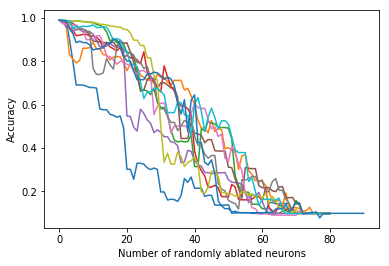

In [28]:
accumulate = True
abl_logs = ablation_test(config, resume, neuron_seq, accumulate)   

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6358776545524597, 'overal_acc': 0.9028, 'topk_acc': 0.9266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6381351459503174, 'overal_acc': 0.9017, 'topk_acc': 0.9261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6461690569877625, 'overal_acc': 0.9002, 'topk_acc': 0.9247}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9065500114440918, 'overal_acc': 0.7999, 'topk_acc': 0.8765}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.915226294708252, 'overal_acc': 0.7976, 'topk_acc': 0.8724}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6987676118850707, 'overal_acc': 0.7973, 'topk_acc': 0.9039}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7435418298721314, 'overal_acc': 0.7945, 'topk_acc': 0.904}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7861062809944153, 'overal_acc': 0.7952, 'topk_acc': 0.8826}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7982759428024292, 'overal_acc': 0.7899, 'topk_acc': 0.9027}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7687169801712036, 'overal_acc': 0.7844, 'topk_acc': 0.9161}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7910969051361084, 'overal_acc': 0.7814, 'topk_acc': 0.9199}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7925640172958374, 'overal_acc': 0.7726, 'topk_acc': 0.9352}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8228269080162048, 'overal_acc': 0.777, 'topk_acc': 0.9119}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8193166221618652, 'overal_acc': 0.7788, 'topk_acc': 0.9106}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8314803665161132, 'overal_acc': 0.7729, 'topk_acc': 0.9104}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8740738092422485, 'overal_acc': 0.7573, 'topk_acc': 0.9082}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9681988227844238, 'overal_acc': 0.7265, 'topk_acc': 0.9042}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0065923984527587, 'overal_acc': 0.7099, 'topk_acc': 0.8884}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0861560108184813, 'overal_acc': 0.7006, 'topk_acc': 0.8779}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.483645044517517, 'overal_acc': 0.6006, 'topk_acc': 0.7866}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2811661554336549, 'overal_acc': 0.6379, 'topk_acc': 0.8037}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3347682117462158, 'overal_acc': 0.5955, 'topk_acc': 0.8039}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3720677843093871, 'overal_acc': 0.5878, 'topk_acc': 0.8017}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3720678148269654, 'overal_acc': 0.5878, 'topk_acc': 0.8017}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4813047025680541, 'overal_acc': 0.5564, 'topk_acc': 0.7744}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4737822805404663, 'overal_acc': 0.5553, 'topk_acc': 0.7728}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4882533113479615, 'overal_acc': 0.5441, 'topk_acc': 0.7666}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4882667634963989, 'overal_acc': 0.5441, 'topk_acc': 0.7666}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5986687133789061, 'overal_acc': 0.5182, 'topk_acc': 0.7445}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.559176937675476, 'overal_acc': 0.5502, 'topk_acc': 0.7635}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.559176937675476, 'overal_acc': 0.5502, 'topk_acc': 0.7635}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1652897813796996, 'overal_acc': 0.6361, 'topk_acc': 0.8018}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2780048404693602, 'overal_acc': 0.5804, 'topk_acc': 0.7917}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2780439033508302, 'overal_acc': 0.5804, 'topk_acc': 0.7917}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3362590169906616, 'overal_acc': 0.5653, 'topk_acc': 0.7818}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2450414901733398, 'overal_acc': 0.589, 'topk_acc': 0.7896}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.229283342552185, 'overal_acc': 0.5924, 'topk_acc': 0.802}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.431403680229187, 'overal_acc': 0.5109, 'topk_acc': 0.7663}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5445562728881836, 'overal_acc': 0.4062, 'topk_acc': 0.7403}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.727067036819458, 'overal_acc': 0.3913, 'topk_acc': 0.6586}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7582649137496948, 'overal_acc': 0.3773, 'topk_acc': 0.6536}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7873404973983764, 'overal_acc': 0.3746, 'topk_acc': 0.6634}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7873401189804077, 'overal_acc': 0.3746, 'topk_acc': 0.6634}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0116854064941405, 'overal_acc': 0.3219, 'topk_acc': 0.5344}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0116854064941405, 'overal_acc': 0.3219, 'topk_acc': 0.5344}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.012783788871765, 'overal_acc': 0.3219, 'topk_acc': 0.5339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9621023488998413, 'overal_acc': 0.3109, 'topk_acc': 0.5297}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0703686054229737, 'overal_acc': 0.2176, 'topk_acc': 0.523}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0220140167236327, 'overal_acc': 0.2491, 'topk_acc': 0.5238}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0220140167236327, 'overal_acc': 0.2491, 'topk_acc': 0.5238}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.022002743911743, 'overal_acc': 0.2492, 'topk_acc': 0.5239}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.022002743911743, 'overal_acc': 0.2492, 'topk_acc': 0.5239}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0214742950439453, 'overal_acc': 0.3009, 'topk_acc': 0.5205}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.12708938331604, 'overal_acc': 0.1791, 'topk_acc': 0.5262}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.136572043228149, 'overal_acc': 0.1803, 'topk_acc': 0.5034}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1584585750579834, 'overal_acc': 0.1861, 'topk_acc': 0.4863}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1791529094696043, 'overal_acc': 0.1037, 'topk_acc': 0.5438}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1784846641540527, 'overal_acc': 0.1035, 'topk_acc': 0.5442}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.17464695854187, 'overal_acc': 0.1058, 'topk_acc': 0.5459}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1534090911865236, 'overal_acc': 0.114, 'topk_acc': 0.6088}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.188235663604736, 'overal_acc': 0.1289, 'topk_acc': 0.5124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.20142672958374, 'overal_acc': 0.1298, 'topk_acc': 0.4924}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2183192764282227, 'overal_acc': 0.1306, 'topk_acc': 0.5504}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.235229419708252, 'overal_acc': 0.1395, 'topk_acc': 0.4857}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2388158618927, 'overal_acc': 0.1343, 'topk_acc': 0.5154}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.241143380355835, 'overal_acc': 0.1733, 'topk_acc': 0.519}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.286275497055054, 'overal_acc': 0.0924, 'topk_acc': 0.4}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2863976566314697, 'overal_acc': 0.1001, 'topk_acc': 0.4018}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2943462665557863, 'overal_acc': 0.0951, 'topk_acc': 0.3958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2927871143341063, 'overal_acc': 0.1297, 'topk_acc': 0.345}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.292597689819336, 'overal_acc': 0.1297, 'topk_acc': 0.3458}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3004670124053956, 'overal_acc': 0.1114, 'topk_acc': 0.3094}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.300566751098633, 'overal_acc': 0.1113, 'topk_acc': 0.3096}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304765536880493, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3046678924560546, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3046678924560546, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3046869232177736, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3046869232177736, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3046869232177736, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3046869232177736, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304132649230957, 'overal_acc': 0.098, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304111783981323, 'overal_acc': 0.098, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3033913063049316, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.303327386856079, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.303327386856079, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.303191460800171, 'overal_acc': 0.1009, 'topk_acc': 0.3124}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3029309204101565, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}
*** Ablating the culprit neuron sequence.
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03417583748102188, 'overal_acc': 0.989, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03803678872585296, 'overal_acc': 0.9871, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1244482549905777, 'overal_acc': 0.9567, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1828540841579437, 'overal_acc': 0.9367, 'topk_acc': 0.9976}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2494066824913025, 'overal_acc': 0.9105, 'topk_acc': 0.9966}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2039064642906189, 'overal_acc': 0.9262, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2150502384185791, 'overal_acc': 0.9228, 'topk_acc': 0.9957}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2150502384185791, 'overal_acc': 0.9228, 'topk_acc': 0.9957}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.20941174154281617, 'overal_acc': 0.9264, 'topk_acc': 0.9925}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3142479724884033, 'overal_acc': 0.8889, 'topk_acc': 0.9862}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3699165325164795, 'overal_acc': 0.8686, 'topk_acc': 0.9827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4308355580329895, 'overal_acc': 0.8417, 'topk_acc': 0.9807}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4164331389427185, 'overal_acc': 0.8447, 'topk_acc': 0.983}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4164330153465271, 'overal_acc': 0.8447, 'topk_acc': 0.983}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4495072880744934, 'overal_acc': 0.834, 'topk_acc': 0.9775}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4612334475040436, 'overal_acc': 0.8263, 'topk_acc': 0.982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6935864892005921, 'overal_acc': 0.7273, 'topk_acc': 0.9745}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7114104927062989, 'overal_acc': 0.7446, 'topk_acc': 0.9701}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7339624060630798, 'overal_acc': 0.7329, 'topk_acc': 0.9727}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8730223054885864, 'overal_acc': 0.672, 'topk_acc': 0.9777}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.755758491897583, 'overal_acc': 0.7155, 'topk_acc': 0.9773}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9063521896362304, 'overal_acc': 0.6734, 'topk_acc': 0.9662}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2315967479705812, 'overal_acc': 0.5747, 'topk_acc': 0.9585}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2315967479705812, 'overal_acc': 0.5747, 'topk_acc': 0.9585}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2465395252227782, 'overal_acc': 0.5706, 'topk_acc': 0.9566}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4903693618774414, 'overal_acc': 0.5062, 'topk_acc': 0.9565}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2681017793655396, 'overal_acc': 0.5482, 'topk_acc': 0.9626}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2681017793655396, 'overal_acc': 0.5482, 'topk_acc': 0.9626}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2492273277282715, 'overal_acc': 0.5693, 'topk_acc': 0.9528}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4978143173217773, 'overal_acc': 0.5035, 'topk_acc': 0.951}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4978143173217773, 'overal_acc': 0.5035, 'topk_acc': 0.951}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2671700731277467, 'overal_acc': 0.5451, 'topk_acc': 0.9564}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4777443855285644, 'overal_acc': 0.4951, 'topk_acc': 0.924}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5089276248931884, 'overal_acc': 0.4577, 'topk_acc': 0.9366}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5568177118301392, 'overal_acc': 0.445, 'topk_acc': 0.9327}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6873818294525147, 'overal_acc': 0.4046, 'topk_acc': 0.8721}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.857556988143921, 'overal_acc': 0.3196, 'topk_acc': 0.8584}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6028977172851562, 'overal_acc': 0.3534, 'topk_acc': 0.8398}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3931721239089965, 'overal_acc': 0.4356, 'topk_acc': 0.8634}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5116687536239624, 'overal_acc': 0.3446, 'topk_acc': 0.8094}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4920965948104858, 'overal_acc': 0.3635, 'topk_acc': 0.8023}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6687070083618165, 'overal_acc': 0.3308, 'topk_acc': 0.7106}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.681570447921753, 'overal_acc': 0.3451, 'topk_acc': 0.6979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6815854442596436, 'overal_acc': 0.3451, 'topk_acc': 0.6979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7241889739990235, 'overal_acc': 0.3004, 'topk_acc': 0.7035}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5750339773178101, 'overal_acc': 0.3586, 'topk_acc': 0.7501}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6025649518966676, 'overal_acc': 0.3382, 'topk_acc': 0.7441}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6781376842498779, 'overal_acc': 0.3111, 'topk_acc': 0.6972}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6950918775558472, 'overal_acc': 0.3069, 'topk_acc': 0.6976}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.759410914039612, 'overal_acc': 0.2999, 'topk_acc': 0.6726}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7748392400741577, 'overal_acc': 0.3068, 'topk_acc': 0.6639}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7748392400741577, 'overal_acc': 0.3068, 'topk_acc': 0.6639}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8605592952728272, 'overal_acc': 0.2919, 'topk_acc': 0.6231}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9012600437164306, 'overal_acc': 0.267, 'topk_acc': 0.6082}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9012600437164306, 'overal_acc': 0.267, 'topk_acc': 0.6082}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4133621673583985, 'overal_acc': 0.0979, 'topk_acc': 0.3705}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.159714112854004, 'overal_acc': 0.1076, 'topk_acc': 0.5048}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1964051971435548, 'overal_acc': 0.1074, 'topk_acc': 0.4336}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.218806734085083, 'overal_acc': 0.1047, 'topk_acc': 0.4355}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.251056420135498, 'overal_acc': 0.1041, 'topk_acc': 0.3874}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2999871974945068, 'overal_acc': 0.0974, 'topk_acc': 0.3222}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2999871974945068, 'overal_acc': 0.0974, 'topk_acc': 0.3222}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2450934108734133, 'overal_acc': 0.0983, 'topk_acc': 0.3627}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2351299869537353, 'overal_acc': 0.0996, 'topk_acc': 0.3819}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2434994735717773, 'overal_acc': 0.099, 'topk_acc': 0.3885}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2592637683868406, 'overal_acc': 0.0985, 'topk_acc': 0.3823}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.272030047225952, 'overal_acc': 0.0965, 'topk_acc': 0.3394}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.271781276702881, 'overal_acc': 0.0964, 'topk_acc': 0.3394}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.303504716491699, 'overal_acc': 0.0974, 'topk_acc': 0.303}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.307502014160156, 'overal_acc': 0.0974, 'topk_acc': 0.2732}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.307491904449463, 'overal_acc': 0.0974, 'topk_acc': 0.2732}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.307001630783081, 'overal_acc': 0.0974, 'topk_acc': 0.2661}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.307161791229248, 'overal_acc': 0.0974, 'topk_acc': 0.2728}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.310548560333252, 'overal_acc': 0.083, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3074478755950927, 'overal_acc': 0.0983, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305837092590332, 'overal_acc': 0.1007, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057198921203614, 'overal_acc': 0.1007, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 1th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03561674636006355, 'overal_acc': 0.9878, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.046800144010782245, 'overal_acc': 0.9836, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05745562998056412, 'overal_acc': 0.9802, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05745562998056412, 'overal_acc': 0.9802, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10053707692623139, 'overal_acc': 0.9669, 'topk_acc': 0.9971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10199116299152375, 'overal_acc': 0.9658, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2841966718196869, 'overal_acc': 0.9073, 'topk_acc': 0.9953}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2944107213020325, 'overal_acc': 0.9053, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.24351845674514772, 'overal_acc': 0.9204, 'topk_acc': 0.9961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2421200334072113, 'overal_acc': 0.9209, 'topk_acc': 0.997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1810725519180298, 'overal_acc': 0.9425, 'topk_acc': 0.9949}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.20896530137062072, 'overal_acc': 0.9334, 'topk_acc': 0.9945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2710602610588074, 'overal_acc': 0.9131, 'topk_acc': 0.9918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.29205532569885256, 'overal_acc': 0.9068, 'topk_acc': 0.9917}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4874100769996643, 'overal_acc': 0.8224, 'topk_acc': 0.9852}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6884340436935424, 'overal_acc': 0.7561, 'topk_acc': 0.9734}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6496948227882385, 'overal_acc': 0.7689, 'topk_acc': 0.977}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6320757762908935, 'overal_acc': 0.7736, 'topk_acc': 0.9812}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6842431204795837, 'overal_acc': 0.7343, 'topk_acc': 0.9842}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5674204982757568, 'overal_acc': 0.792, 'topk_acc': 0.9854}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6529221851348876, 'overal_acc': 0.7625, 'topk_acc': 0.9819}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5487366333961486, 'overal_acc': 0.8043, 'topk_acc': 0.9851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5710788679122925, 'overal_acc': 0.8011, 'topk_acc': 0.977}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0044513092041016, 'overal_acc': 0.6355, 'topk_acc': 0.9449}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0346011419296264, 'overal_acc': 0.616, 'topk_acc': 0.9472}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3408104301452637, 'overal_acc': 0.4766, 'topk_acc': 0.927}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9023299728393555, 'overal_acc': 0.326, 'topk_acc': 0.8084}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9694408782958985, 'overal_acc': 0.3164, 'topk_acc': 0.8201}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.5582155689239503, 'overal_acc': 0.2082, 'topk_acc': 0.5472}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.5582155689239503, 'overal_acc': 0.2082, 'topk_acc': 0.5472}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.5582155689239503, 'overal_acc': 0.2082, 'topk_acc': 0.5472}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.1962826572418215, 'overal_acc': 0.2087, 'topk_acc': 0.4988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.894368392944336, 'overal_acc': 0.2054, 'topk_acc': 0.4854}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.894368392944336, 'overal_acc': 0.2054, 'topk_acc': 0.4854}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.908266738510132, 'overal_acc': 0.2071, 'topk_acc': 0.4765}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.908266738510132, 'overal_acc': 0.2071, 'topk_acc': 0.4765}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.908624716567993, 'overal_acc': 0.2071, 'topk_acc': 0.4763}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.908624716567993, 'overal_acc': 0.2071, 'topk_acc': 0.4763}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.9524324718475343, 'overal_acc': 0.2068, 'topk_acc': 0.4688}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.953104850769043, 'overal_acc': 0.2068, 'topk_acc': 0.4693}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.0436625366210937, 'overal_acc': 0.2065, 'topk_acc': 0.4345}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.0436528076171876, 'overal_acc': 0.2065, 'topk_acc': 0.4345}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.8047768615722655, 'overal_acc': 0.2034, 'topk_acc': 0.4105}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.7629752819061277, 'overal_acc': 0.1826, 'topk_acc': 0.3997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.8345895080566406, 'overal_acc': 0.1805, 'topk_acc': 0.3819}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.810216534423828, 'overal_acc': 0.1689, 'topk_acc': 0.3782}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.8101727214813232, 'overal_acc': 0.1688, 'topk_acc': 0.3782}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.539275783920288, 'overal_acc': 0.1242, 'topk_acc': 0.3599}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5654209400177, 'overal_acc': 0.1237, 'topk_acc': 0.3569}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5654209400177, 'overal_acc': 0.1237, 'topk_acc': 0.3569}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.190930517196655, 'overal_acc': 0.2075, 'topk_acc': 0.4461}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1882062408447265, 'overal_acc': 0.2123, 'topk_acc': 0.4334}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.201947732543945, 'overal_acc': 0.2093, 'topk_acc': 0.4201}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2023894092559813, 'overal_acc': 0.209, 'topk_acc': 0.42}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1848339080810546, 'overal_acc': 0.2435, 'topk_acc': 0.4178}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.194303998565674, 'overal_acc': 0.2436, 'topk_acc': 0.4156}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2203500770568847, 'overal_acc': 0.1951, 'topk_acc': 0.4538}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2198110748291016, 'overal_acc': 0.195, 'topk_acc': 0.451}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2198110748291016, 'overal_acc': 0.195, 'topk_acc': 0.451}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.222039329528809, 'overal_acc': 0.1949, 'topk_acc': 0.4431}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.257932283401489, 'overal_acc': 0.162, 'topk_acc': 0.4519}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.253949881362915, 'overal_acc': 0.1614, 'topk_acc': 0.4547}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.285841275024414, 'overal_acc': 0.1339, 'topk_acc': 0.3682}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.289072350692749, 'overal_acc': 0.1423, 'topk_acc': 0.3447}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.294132317352295, 'overal_acc': 0.1255, 'topk_acc': 0.3525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2932455142974852, 'overal_acc': 0.1258, 'topk_acc': 0.3526}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2949550258636475, 'overal_acc': 0.1286, 'topk_acc': 0.336}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2989719135284425, 'overal_acc': 0.132, 'topk_acc': 0.3298}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3065512329101563, 'overal_acc': 0.1308, 'topk_acc': 0.3519}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.309655324935913, 'overal_acc': 0.1308, 'topk_acc': 0.3601}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.322454969787598, 'overal_acc': 0.1273, 'topk_acc': 0.3214}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30534093208313, 'overal_acc': 0.1182, 'topk_acc': 0.33}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3050783740997316, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305264744567871, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3053663040161134, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057454341888426, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059272846221925, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 2th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04667056794166565, 'overal_acc': 0.9829, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06315984892845154, 'overal_acc': 0.9774, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.15158000218868256, 'overal_acc': 0.9469, 'topk_acc': 0.9976}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17711726608276368, 'overal_acc': 0.9397, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17899310965538026, 'overal_acc': 0.9379, 'topk_acc': 0.9973}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.20199282512664796, 'overal_acc': 0.9306, 'topk_acc': 0.9965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.25311498823165895, 'overal_acc': 0.9138, 'topk_acc': 0.9962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.26849760370254516, 'overal_acc': 0.9093, 'topk_acc': 0.9961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.26849760370254516, 'overal_acc': 0.9093, 'topk_acc': 0.9961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3421817447185516, 'overal_acc': 0.8866, 'topk_acc': 0.9934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.47185086908340457, 'overal_acc': 0.8407, 'topk_acc': 0.9922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8514019680976868, 'overal_acc': 0.7256, 'topk_acc': 0.9891}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7529454931259155, 'overal_acc': 0.7402, 'topk_acc': 0.9852}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0097071689605712, 'overal_acc': 0.6723, 'topk_acc': 0.9779}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0097071689605712, 'overal_acc': 0.6723, 'topk_acc': 0.9779}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9195394264221192, 'overal_acc': 0.7048, 'topk_acc': 0.9759}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8678026035308838, 'overal_acc': 0.7248, 'topk_acc': 0.98}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8678134189605713, 'overal_acc': 0.7247, 'topk_acc': 0.98}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8965133111953736, 'overal_acc': 0.7019, 'topk_acc': 0.9684}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7211729175567627, 'overal_acc': 0.7388, 'topk_acc': 0.9759}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6915714381217957, 'overal_acc': 0.7515, 'topk_acc': 0.9785}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7243017344474793, 'overal_acc': 0.7349, 'topk_acc': 0.9807}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7139139346122741, 'overal_acc': 0.7266, 'topk_acc': 0.9827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7139899455070495, 'overal_acc': 0.7266, 'topk_acc': 0.9827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5981671675682068, 'overal_acc': 0.7712, 'topk_acc': 0.9793}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7539402737617492, 'overal_acc': 0.7012, 'topk_acc': 0.978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7606851376533509, 'overal_acc': 0.6953, 'topk_acc': 0.9786}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9904889610290527, 'overal_acc': 0.6267, 'topk_acc': 0.9624}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1688914262771606, 'overal_acc': 0.5968, 'topk_acc': 0.9268}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3360220777511598, 'overal_acc': 0.5224, 'topk_acc': 0.9166}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3360176832199098, 'overal_acc': 0.5224, 'topk_acc': 0.9166}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.010182649421692, 'overal_acc': 0.6281, 'topk_acc': 0.9017}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0263771389007568, 'overal_acc': 0.6217, 'topk_acc': 0.901}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0263771389007568, 'overal_acc': 0.6217, 'topk_acc': 0.901}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1191398012161256, 'overal_acc': 0.5851, 'topk_acc': 0.8874}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1231069793701172, 'overal_acc': 0.5849, 'topk_acc': 0.8854}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2182784727096558, 'overal_acc': 0.543, 'topk_acc': 0.8753}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.318973401069641, 'overal_acc': 0.4854, 'topk_acc': 0.8791}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2289079879760743, 'overal_acc': 0.5587, 'topk_acc': 0.8785}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.257775773048401, 'overal_acc': 0.5464, 'topk_acc': 0.8734}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3567228515625, 'overal_acc': 0.4662, 'topk_acc': 0.8483}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3555458135604859, 'overal_acc': 0.4797, 'topk_acc': 0.8396}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.355359495162964, 'overal_acc': 0.5018, 'topk_acc': 0.8359}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3868024782180786, 'overal_acc': 0.471, 'topk_acc': 0.8315}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.428252314186096, 'overal_acc': 0.4659, 'topk_acc': 0.8339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7638953092575074, 'overal_acc': 0.3293, 'topk_acc': 0.6906}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7931911375045777, 'overal_acc': 0.3189, 'topk_acc': 0.6925}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7931911375045777, 'overal_acc': 0.3189, 'topk_acc': 0.6925}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.898048631477356, 'overal_acc': 0.2874, 'topk_acc': 0.6509}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.898997417449951, 'overal_acc': 0.2873, 'topk_acc': 0.6507}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9584226600646972, 'overal_acc': 0.3429, 'topk_acc': 0.7021}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0046384014129637, 'overal_acc': 0.2498, 'topk_acc': 0.6474}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.014923225784302, 'overal_acc': 0.2494, 'topk_acc': 0.6483}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0539415588378906, 'overal_acc': 0.2574, 'topk_acc': 0.6052}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0509900314331055, 'overal_acc': 0.2677, 'topk_acc': 0.6092}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0837922298431395, 'overal_acc': 0.2758, 'topk_acc': 0.5797}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.09365915222168, 'overal_acc': 0.2365, 'topk_acc': 0.5905}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1357509128570555, 'overal_acc': 0.2215, 'topk_acc': 0.5897}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1402157371521, 'overal_acc': 0.2214, 'topk_acc': 0.578}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1621401016235353, 'overal_acc': 0.1824, 'topk_acc': 0.5582}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2972361965179444, 'overal_acc': 0.1531, 'topk_acc': 0.3664}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3346400272369383, 'overal_acc': 0.1288, 'topk_acc': 0.3075}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3423977672576903, 'overal_acc': 0.1304, 'topk_acc': 0.2817}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.342442322921753, 'overal_acc': 0.1304, 'topk_acc': 0.2818}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3383815784454347, 'overal_acc': 0.1421, 'topk_acc': 0.2869}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3087247467041014, 'overal_acc': 0.1521, 'topk_acc': 0.3339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3166222900390623, 'overal_acc': 0.1436, 'topk_acc': 0.3226}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.317064521408081, 'overal_acc': 0.1416, 'topk_acc': 0.299}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.313018824386597, 'overal_acc': 0.1367, 'topk_acc': 0.3148}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.376997738647461, 'overal_acc': 0.1648, 'topk_acc': 0.3077}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.376988412475586, 'overal_acc': 0.1648, 'topk_acc': 0.3077}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.381209897994995, 'overal_acc': 0.171, 'topk_acc': 0.3024}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305446545791626, 'overal_acc': 0.1147, 'topk_acc': 0.3561}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066385204315187, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306771879196167, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306771879196167, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306771879196167, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3064627593994143, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306455249404907, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 3th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03445652133226395, 'overal_acc': 0.9875, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03810975013971329, 'overal_acc': 0.9866, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05669270029067993, 'overal_acc': 0.981, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04529014130830765, 'overal_acc': 0.9847, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04529014130830765, 'overal_acc': 0.9847, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.053290593564510345, 'overal_acc': 0.9818, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05919268947839737, 'overal_acc': 0.9796, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05919268947839737, 'overal_acc': 0.9796, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0687545695066452, 'overal_acc': 0.976, 'topk_acc': 0.9988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08774912467002868, 'overal_acc': 0.9686, 'topk_acc': 0.9986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.200952387881279, 'overal_acc': 0.9248, 'topk_acc': 0.9964}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2139383326292038, 'overal_acc': 0.9196, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2645951536655426, 'overal_acc': 0.9015, 'topk_acc': 0.9948}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3325632908344269, 'overal_acc': 0.8761, 'topk_acc': 0.9948}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3390069971084595, 'overal_acc': 0.8721, 'topk_acc': 0.9952}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.45998904542922975, 'overal_acc': 0.8329, 'topk_acc': 0.9938}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5175788188934326, 'overal_acc': 0.7926, 'topk_acc': 0.9927}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5551057426452637, 'overal_acc': 0.781, 'topk_acc': 0.9922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7173573134422302, 'overal_acc': 0.72, 'topk_acc': 0.9865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6183958397865296, 'overal_acc': 0.754, 'topk_acc': 0.9836}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7233110476493836, 'overal_acc': 0.7121, 'topk_acc': 0.9765}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7339877687454224, 'overal_acc': 0.7076, 'topk_acc': 0.9736}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9748486923217774, 'overal_acc': 0.6614, 'topk_acc': 0.9554}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9113395818710327, 'overal_acc': 0.6744, 'topk_acc': 0.9652}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9113395818710327, 'overal_acc': 0.6744, 'topk_acc': 0.9652}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9497806762695312, 'overal_acc': 0.6746, 'topk_acc': 0.9437}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0110436784744263, 'overal_acc': 0.6646, 'topk_acc': 0.9174}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0861981111526489, 'overal_acc': 0.6079, 'topk_acc': 0.9112}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0862807313919067, 'overal_acc': 0.6079, 'topk_acc': 0.9112}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0862807313919067, 'overal_acc': 0.6079, 'topk_acc': 0.9112}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2043868085861207, 'overal_acc': 0.5584, 'topk_acc': 0.9014}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.291493925857544, 'overal_acc': 0.5436, 'topk_acc': 0.9015}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4920824977874756, 'overal_acc': 0.5413, 'topk_acc': 0.8166}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2429260251998901, 'overal_acc': 0.551, 'topk_acc': 0.8998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2432400884628296, 'overal_acc': 0.5533, 'topk_acc': 0.8992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3214447456359864, 'overal_acc': 0.4925, 'topk_acc': 0.9055}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2598288160324096, 'overal_acc': 0.5109, 'topk_acc': 0.9052}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3841749456405639, 'overal_acc': 0.4538, 'topk_acc': 0.8614}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3912267547607422, 'overal_acc': 0.4505, 'topk_acc': 0.8569}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.534918024635315, 'overal_acc': 0.4239, 'topk_acc': 0.8381}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5349200876235962, 'overal_acc': 0.4239, 'topk_acc': 0.8381}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.582952099609375, 'overal_acc': 0.4047, 'topk_acc': 0.8117}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.572937106513977, 'overal_acc': 0.3955, 'topk_acc': 0.7938}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.617225541114807, 'overal_acc': 0.4069, 'topk_acc': 0.7723}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7044282091140748, 'overal_acc': 0.3974, 'topk_acc': 0.7497}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3284105140686036, 'overal_acc': 0.2682, 'topk_acc': 0.4299}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.31104197807312, 'overal_acc': 0.2619, 'topk_acc': 0.4294}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.378712268447876, 'overal_acc': 0.2381, 'topk_acc': 0.4105}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2236536331176757, 'overal_acc': 0.2176, 'topk_acc': 0.4191}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.191196471786499, 'overal_acc': 0.2275, 'topk_acc': 0.4282}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1914064083099367, 'overal_acc': 0.2275, 'topk_acc': 0.4281}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.14741940574646, 'overal_acc': 0.2123, 'topk_acc': 0.4495}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1154510963439943, 'overal_acc': 0.222, 'topk_acc': 0.5632}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.122521937942505, 'overal_acc': 0.2171, 'topk_acc': 0.5354}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.122521937942505, 'overal_acc': 0.2171, 'topk_acc': 0.5354}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1388230072021486, 'overal_acc': 0.2143, 'topk_acc': 0.5459}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1465564487457276, 'overal_acc': 0.2149, 'topk_acc': 0.5727}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.152943827056885, 'overal_acc': 0.2232, 'topk_acc': 0.5266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1893903770446776, 'overal_acc': 0.1959, 'topk_acc': 0.4736}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2109677970886232, 'overal_acc': 0.2051, 'topk_acc': 0.3769}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.216831037902832, 'overal_acc': 0.2147, 'topk_acc': 0.3932}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2517251789093016, 'overal_acc': 0.2877, 'topk_acc': 0.4317}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2539790012359617, 'overal_acc': 0.2679, 'topk_acc': 0.433}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2671866477966307, 'overal_acc': 0.2846, 'topk_acc': 0.3973}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.272578600692749, 'overal_acc': 0.2796, 'topk_acc': 0.3995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305544741821289, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055544090270996, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056134494781495, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056134494781495, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059243965148926, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305935635757446, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058511417388914, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055848583221437, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055848583221437, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055848583221437, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305685539627075, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305685539627075, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305675750732422, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 4th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.037176075077056885, 'overal_acc': 0.9878, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.037176075077056885, 'overal_acc': 0.9878, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.041901358914375304, 'overal_acc': 0.9868, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04955387337207794, 'overal_acc': 0.9845, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06378541613817215, 'overal_acc': 0.9798, 'topk_acc': 0.9981}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08228823447227478, 'overal_acc': 0.9726, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10821484749317169, 'overal_acc': 0.9659, 'topk_acc': 0.9971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14302174541950227, 'overal_acc': 0.9543, 'topk_acc': 0.9963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.19404001245498656, 'overal_acc': 0.9331, 'topk_acc': 0.9945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23568485112190246, 'overal_acc': 0.9164, 'topk_acc': 0.9943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.43378123722076417, 'overal_acc': 0.8432, 'topk_acc': 0.9911}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6644275511741639, 'overal_acc': 0.7683, 'topk_acc': 0.9805}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5493460495948792, 'overal_acc': 0.7987, 'topk_acc': 0.9858}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7535473192214965, 'overal_acc': 0.7252, 'topk_acc': 0.9774}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.749105771446228, 'overal_acc': 0.7221, 'topk_acc': 0.9801}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7699122940063476, 'overal_acc': 0.7201, 'topk_acc': 0.974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8575208564758301, 'overal_acc': 0.6955, 'topk_acc': 0.9689}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6475978595733642, 'overal_acc': 0.7597, 'topk_acc': 0.9766}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.824112012386322, 'overal_acc': 0.6964, 'topk_acc': 0.9562}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6579497113227845, 'overal_acc': 0.768, 'topk_acc': 0.9799}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7456047163009644, 'overal_acc': 0.7315, 'topk_acc': 0.9735}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8554702730178833, 'overal_acc': 0.6781, 'topk_acc': 0.934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1650806270599365, 'overal_acc': 0.5343, 'topk_acc': 0.9011}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2608012628555298, 'overal_acc': 0.4734, 'topk_acc': 0.9041}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3357999067306519, 'overal_acc': 0.4548, 'topk_acc': 0.895}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3328559495925902, 'overal_acc': 0.4468, 'topk_acc': 0.8798}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3219866401672364, 'overal_acc': 0.4447, 'topk_acc': 0.8912}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3219866401672364, 'overal_acc': 0.4447, 'topk_acc': 0.8912}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3400957389831543, 'overal_acc': 0.4429, 'topk_acc': 0.8775}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.424203597831726, 'overal_acc': 0.4256, 'topk_acc': 0.8351}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4193146181106568, 'overal_acc': 0.4469, 'topk_acc': 0.828}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4193146181106568, 'overal_acc': 0.4469, 'topk_acc': 0.828}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4510286588668824, 'overal_acc': 0.4455, 'topk_acc': 0.7632}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4510286588668824, 'overal_acc': 0.4455, 'topk_acc': 0.7632}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4503118118286134, 'overal_acc': 0.4405, 'topk_acc': 0.7863}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3960179595947266, 'overal_acc': 0.514, 'topk_acc': 0.8296}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4284229784011842, 'overal_acc': 0.5304, 'topk_acc': 0.8282}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5834528211593628, 'overal_acc': 0.4053, 'topk_acc': 0.735}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.586572808265686, 'overal_acc': 0.4136, 'topk_acc': 0.7372}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.367129598236084, 'overal_acc': 0.2103, 'topk_acc': 0.4478}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.338615586090088, 'overal_acc': 0.2153, 'topk_acc': 0.4136}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.889762091064453, 'overal_acc': 0.3982, 'topk_acc': 0.6343}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9297485244750976, 'overal_acc': 0.4203, 'topk_acc': 0.6318}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9500088026046754, 'overal_acc': 0.4206, 'topk_acc': 0.6542}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9525684616088868, 'overal_acc': 0.418, 'topk_acc': 0.6525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9725941221237182, 'overal_acc': 0.3903, 'topk_acc': 0.675}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.972592742729187, 'overal_acc': 0.3903, 'topk_acc': 0.675}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9927403152465821, 'overal_acc': 0.2887, 'topk_acc': 0.6413}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0136958713531494, 'overal_acc': 0.216, 'topk_acc': 0.6126}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.120463343429565, 'overal_acc': 0.2695, 'topk_acc': 0.5967}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.152438401412964, 'overal_acc': 0.251, 'topk_acc': 0.5558}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.15274249458313, 'overal_acc': 0.2512, 'topk_acc': 0.5535}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1596064361572265, 'overal_acc': 0.2655, 'topk_acc': 0.5612}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1675544170379637, 'overal_acc': 0.2538, 'topk_acc': 0.5477}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1798227478027346, 'overal_acc': 0.2537, 'topk_acc': 0.5211}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1940360671997072, 'overal_acc': 0.24, 'topk_acc': 0.5496}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2498323356628416, 'overal_acc': 0.1402, 'topk_acc': 0.4182}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.266890177536011, 'overal_acc': 0.1353, 'topk_acc': 0.4077}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.270504472351074, 'overal_acc': 0.1329, 'topk_acc': 0.4186}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2903950382232665, 'overal_acc': 0.1079, 'topk_acc': 0.3821}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.299573468017578, 'overal_acc': 0.0945, 'topk_acc': 0.3946}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304081480026245, 'overal_acc': 0.1068, 'topk_acc': 0.3918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306806650543213, 'overal_acc': 0.1201, 'topk_acc': 0.3122}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306788740158081, 'overal_acc': 0.1201, 'topk_acc': 0.3123}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.311187657165527, 'overal_acc': 0.1366, 'topk_acc': 0.2999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3068898670196534, 'overal_acc': 0.0986, 'topk_acc': 0.2962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3061504165649414, 'overal_acc': 0.0898, 'topk_acc': 0.2962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305892529296875, 'overal_acc': 0.0946, 'topk_acc': 0.2782}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305892399978638, 'overal_acc': 0.0946, 'topk_acc': 0.2782}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3049665893554687, 'overal_acc': 0.0969, 'topk_acc': 0.2735}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304819133758545, 'overal_acc': 0.0966, 'topk_acc': 0.2774}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305619073486328, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056179748535155, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305532571411133, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305532571411133, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 5th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04066592734456062, 'overal_acc': 0.986, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04785224118232727, 'overal_acc': 0.9832, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08233208212852478, 'overal_acc': 0.9725, 'topk_acc': 0.9969}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07972551844120025, 'overal_acc': 0.9744, 'topk_acc': 0.9971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07972551844120025, 'overal_acc': 0.9744, 'topk_acc': 0.9971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07972551844120025, 'overal_acc': 0.9744, 'topk_acc': 0.9971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07972551844120025, 'overal_acc': 0.9744, 'topk_acc': 0.9971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07866572208404542, 'overal_acc': 0.974, 'topk_acc': 0.9976}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.09254305245876313, 'overal_acc': 0.9703, 'topk_acc': 0.9968}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1408273511171341, 'overal_acc': 0.9567, 'topk_acc': 0.9944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14247692410945892, 'overal_acc': 0.9555, 'topk_acc': 0.9956}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.21299796738624574, 'overal_acc': 0.9296, 'topk_acc': 0.9941}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.21005697565078735, 'overal_acc': 0.9311, 'topk_acc': 0.9949}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2822933319091797, 'overal_acc': 0.9071, 'topk_acc': 0.9918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2691031367778778, 'overal_acc': 0.9135, 'topk_acc': 0.9919}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.21508639621734618, 'overal_acc': 0.9327, 'topk_acc': 0.9927}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2632083759307861, 'overal_acc': 0.9133, 'topk_acc': 0.9904}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.26320836219787597, 'overal_acc': 0.9133, 'topk_acc': 0.9904}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.28504220657348633, 'overal_acc': 0.9057, 'topk_acc': 0.9903}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3893525278091431, 'overal_acc': 0.8684, 'topk_acc': 0.9851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6107982741355896, 'overal_acc': 0.7906, 'topk_acc': 0.9683}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.666815796470642, 'overal_acc': 0.7767, 'topk_acc': 0.9683}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7752353468894958, 'overal_acc': 0.7505, 'topk_acc': 0.9609}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8066325263977051, 'overal_acc': 0.7278, 'topk_acc': 0.9556}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6826395558357239, 'overal_acc': 0.789, 'topk_acc': 0.9647}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7477032916069031, 'overal_acc': 0.78, 'topk_acc': 0.9472}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8666060358047485, 'overal_acc': 0.7603, 'topk_acc': 0.9174}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9573702905654907, 'overal_acc': 0.7017, 'topk_acc': 0.9171}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9573702905654907, 'overal_acc': 0.7017, 'topk_acc': 0.9171}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9482707658767701, 'overal_acc': 0.6717, 'topk_acc': 0.9388}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9961446544647217, 'overal_acc': 0.6354, 'topk_acc': 0.9332}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3377861505508424, 'overal_acc': 0.4713, 'topk_acc': 0.8956}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3542284761428833, 'overal_acc': 0.4652, 'topk_acc': 0.8958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4418108417510986, 'overal_acc': 0.4408, 'topk_acc': 0.887}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5558778381347655, 'overal_acc': 0.3668, 'topk_acc': 0.8751}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6201765014648437, 'overal_acc': 0.3244, 'topk_acc': 0.8579}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6410773542404176, 'overal_acc': 0.3117, 'topk_acc': 0.8549}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.564738131904602, 'overal_acc': 0.3457, 'topk_acc': 0.8366}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6395342010498046, 'overal_acc': 0.338, 'topk_acc': 0.8071}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.668348388671875, 'overal_acc': 0.3374, 'topk_acc': 0.8011}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.832631900024414, 'overal_acc': 0.2659, 'topk_acc': 0.7915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.832631900024414, 'overal_acc': 0.2659, 'topk_acc': 0.7915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7839004932403564, 'overal_acc': 0.318, 'topk_acc': 0.6749}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8862432125091553, 'overal_acc': 0.289, 'topk_acc': 0.652}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8198450548171996, 'overal_acc': 0.4112, 'topk_acc': 0.6312}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8381964920043945, 'overal_acc': 0.4007, 'topk_acc': 0.5947}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.929790881729126, 'overal_acc': 0.3281, 'topk_acc': 0.5476}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.945181007385254, 'overal_acc': 0.3118, 'topk_acc': 0.5549}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.988928063583374, 'overal_acc': 0.3231, 'topk_acc': 0.5245}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.042530532836914, 'overal_acc': 0.2857, 'topk_acc': 0.4773}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.042512907028198, 'overal_acc': 0.2857, 'topk_acc': 0.4773}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0961507591247557, 'overal_acc': 0.2535, 'topk_acc': 0.4645}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0937392837524413, 'overal_acc': 0.2605, 'topk_acc': 0.4591}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1476311870574953, 'overal_acc': 0.2247, 'topk_acc': 0.4347}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1572139488220214, 'overal_acc': 0.2116, 'topk_acc': 0.4336}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1754525398254394, 'overal_acc': 0.1187, 'topk_acc': 0.381}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2185185111999512, 'overal_acc': 0.1028, 'topk_acc': 0.4087}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.180910793685913, 'overal_acc': 0.1338, 'topk_acc': 0.4059}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1746668521881105, 'overal_acc': 0.1543, 'topk_acc': 0.5111}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.19006986618042, 'overal_acc': 0.1615, 'topk_acc': 0.4837}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1958910289764404, 'overal_acc': 0.1513, 'topk_acc': 0.4637}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2126016456604005, 'overal_acc': 0.151, 'topk_acc': 0.4115}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2224189544677735, 'overal_acc': 0.1359, 'topk_acc': 0.4194}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2417588748931885, 'overal_acc': 0.1286, 'topk_acc': 0.4023}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2859068725585936, 'overal_acc': 0.1153, 'topk_acc': 0.3574}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.29084356880188, 'overal_acc': 0.1135, 'topk_acc': 0.3561}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.291534348297119, 'overal_acc': 0.1172, 'topk_acc': 0.3552}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.291534348297119, 'overal_acc': 0.1172, 'topk_acc': 0.3552}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2889431018829347, 'overal_acc': 0.1373, 'topk_acc': 0.3575}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2963975299835204, 'overal_acc': 0.1105, 'topk_acc': 0.3559}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2962150104522707, 'overal_acc': 0.1126, 'topk_acc': 0.3559}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.290444179534912, 'overal_acc': 0.1263, 'topk_acc': 0.3411}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.290480165863037, 'overal_acc': 0.1263, 'topk_acc': 0.3411}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2875557308197023, 'overal_acc': 0.1201, 'topk_acc': 0.3473}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305718400192261, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305738525009155, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305753734970093, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305753734970093, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 6th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034173213481903074, 'overal_acc': 0.989, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04385366611480713, 'overal_acc': 0.9857, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04385366611480713, 'overal_acc': 0.9857, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05479111088514328, 'overal_acc': 0.9831, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05479111088514328, 'overal_acc': 0.9831, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0665578847169876, 'overal_acc': 0.9793, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08613648805618286, 'overal_acc': 0.9727, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11818961029052734, 'overal_acc': 0.9631, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11317660295963287, 'overal_acc': 0.9642, 'topk_acc': 0.9967}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12783866815567016, 'overal_acc': 0.9585, 'topk_acc': 0.9967}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1530435033082962, 'overal_acc': 0.9499, 'topk_acc': 0.9962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1870837459564209, 'overal_acc': 0.9364, 'topk_acc': 0.9949}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2806613255977631, 'overal_acc': 0.8998, 'topk_acc': 0.992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.24532506036758422, 'overal_acc': 0.9108, 'topk_acc': 0.993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2880290914058685, 'overal_acc': 0.895, 'topk_acc': 0.9906}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2796668730735779, 'overal_acc': 0.8965, 'topk_acc': 0.9927}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3448402933120728, 'overal_acc': 0.8759, 'topk_acc': 0.9856}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.32016251378059385, 'overal_acc': 0.8837, 'topk_acc': 0.9863}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2536531824111938, 'overal_acc': 0.7124, 'topk_acc': 0.7886}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3408001260757447, 'overal_acc': 0.6613, 'topk_acc': 0.7914}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8857265375137329, 'overal_acc': 0.5929, 'topk_acc': 0.755}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.804164089202881, 'overal_acc': 0.6026, 'topk_acc': 0.7487}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8218932836532593, 'overal_acc': 0.5878, 'topk_acc': 0.746}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8218934057235718, 'overal_acc': 0.5878, 'topk_acc': 0.746}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6201214883804322, 'overal_acc': 0.6011, 'topk_acc': 0.7548}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.639898210334778, 'overal_acc': 0.5989, 'topk_acc': 0.7339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.639898210334778, 'overal_acc': 0.5989, 'topk_acc': 0.7339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.639898210334778, 'overal_acc': 0.5989, 'topk_acc': 0.7339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8649334064483643, 'overal_acc': 0.4191, 'topk_acc': 0.7661}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6695046203613282, 'overal_acc': 0.4901, 'topk_acc': 0.7614}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.776506554031372, 'overal_acc': 0.4735, 'topk_acc': 0.6991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7594579078674317, 'overal_acc': 0.4854, 'topk_acc': 0.6909}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9028943817138673, 'overal_acc': 0.4215, 'topk_acc': 0.6991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0814575359344483, 'overal_acc': 0.387, 'topk_acc': 0.6827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.012360964202881, 'overal_acc': 0.4304, 'topk_acc': 0.6269}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0367439750671386, 'overal_acc': 0.4224, 'topk_acc': 0.6259}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.083892699813843, 'overal_acc': 0.4144, 'topk_acc': 0.6205}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.383648366546631, 'overal_acc': 0.3243, 'topk_acc': 0.5465}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.7606204376220704, 'overal_acc': 0.248, 'topk_acc': 0.4993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5422688079833984, 'overal_acc': 0.3006, 'topk_acc': 0.5079}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5422688079833984, 'overal_acc': 0.3006, 'topk_acc': 0.5079}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.5422688079833984, 'overal_acc': 0.3006, 'topk_acc': 0.5079}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.548459362792969, 'overal_acc': 0.2993, 'topk_acc': 0.507}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.376825654602051, 'overal_acc': 0.3412, 'topk_acc': 0.5352}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.376825654602051, 'overal_acc': 0.3412, 'topk_acc': 0.5352}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.369056559753418, 'overal_acc': 0.3862, 'topk_acc': 0.5108}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8446282594680785, 'overal_acc': 0.3244, 'topk_acc': 0.6487}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7757186996459962, 'overal_acc': 0.3683, 'topk_acc': 0.6394}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8394499822616577, 'overal_acc': 0.3484, 'topk_acc': 0.6403}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9019296569824218, 'overal_acc': 0.3221, 'topk_acc': 0.6155}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.914860237121582, 'overal_acc': 0.3064, 'topk_acc': 0.595}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9517619033813476, 'overal_acc': 0.3027, 'topk_acc': 0.5911}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9698668601989746, 'overal_acc': 0.3138, 'topk_acc': 0.6479}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.026872439956665, 'overal_acc': 0.2676, 'topk_acc': 0.6522}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.057215378189087, 'overal_acc': 0.2644, 'topk_acc': 0.5376}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.058460852432251, 'overal_acc': 0.2639, 'topk_acc': 0.5376}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0723059337615966, 'overal_acc': 0.2458, 'topk_acc': 0.5252}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.099177807235718, 'overal_acc': 0.2078, 'topk_acc': 0.4979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1423500877380373, 'overal_acc': 0.1251, 'topk_acc': 0.4689}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.156522351074219, 'overal_acc': 0.1218, 'topk_acc': 0.429}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.148550768280029, 'overal_acc': 0.1233, 'topk_acc': 0.4423}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1653351776123047, 'overal_acc': 0.1307, 'topk_acc': 0.4179}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1689974967956545, 'overal_acc': 0.1323, 'topk_acc': 0.4187}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2185014984130857, 'overal_acc': 0.12, 'topk_acc': 0.3475}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2975705406188967, 'overal_acc': 0.1001, 'topk_acc': 0.3469}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.299694680786133, 'overal_acc': 0.1, 'topk_acc': 0.3467}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3069251857757567, 'overal_acc': 0.0831, 'topk_acc': 0.3286}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3064413970947264, 'overal_acc': 0.0819, 'topk_acc': 0.2985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.298849953842163, 'overal_acc': 0.0744, 'topk_acc': 0.3013}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.296417752456665, 'overal_acc': 0.1029, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.300050815582275, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057179805755617, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057179805755617, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057179805755617, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057412242889406, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 7th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03479836258888245, 'overal_acc': 0.9886, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035675638508796695, 'overal_acc': 0.9876, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05126667603254318, 'overal_acc': 0.9835, 'topk_acc': 0.9988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05126667603254318, 'overal_acc': 0.9835, 'topk_acc': 0.9988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05379943082332611, 'overal_acc': 0.982, 'topk_acc': 0.999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08887118291854858, 'overal_acc': 0.9704, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06754260600805283, 'overal_acc': 0.9775, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11668612277507782, 'overal_acc': 0.9651, 'topk_acc': 0.9945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6133995525360108, 'overal_acc': 0.6675, 'topk_acc': 0.7944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6133995525360108, 'overal_acc': 0.6675, 'topk_acc': 0.7944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2537264642715453, 'overal_acc': 0.6938, 'topk_acc': 0.8128}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2537264642715453, 'overal_acc': 0.6938, 'topk_acc': 0.8128}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6144227757453918, 'overal_acc': 0.7739, 'topk_acc': 0.953}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6823460891723633, 'overal_acc': 0.7717, 'topk_acc': 0.9029}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6821573835372925, 'overal_acc': 0.7717, 'topk_acc': 0.9029}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8563666252136231, 'overal_acc': 0.7137, 'topk_acc': 0.8891}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9137064624786377, 'overal_acc': 0.695, 'topk_acc': 0.886}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9137054828643799, 'overal_acc': 0.695, 'topk_acc': 0.886}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.135200241279602, 'overal_acc': 0.6145, 'topk_acc': 0.8922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1011548238754272, 'overal_acc': 0.6355, 'topk_acc': 0.8859}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1481814512252808, 'overal_acc': 0.609, 'topk_acc': 0.8873}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1909602828979493, 'overal_acc': 0.5958, 'topk_acc': 0.8851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2656572170257567, 'overal_acc': 0.5509, 'topk_acc': 0.8849}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3146696235656739, 'overal_acc': 0.5341, 'topk_acc': 0.8838}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3728877969741822, 'overal_acc': 0.5154, 'topk_acc': 0.8679}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.280035160255432, 'overal_acc': 0.5401, 'topk_acc': 0.8681}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2678801935195922, 'overal_acc': 0.5511, 'topk_acc': 0.863}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3805748003005982, 'overal_acc': 0.4916, 'topk_acc': 0.8678}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4025293691635132, 'overal_acc': 0.4817, 'topk_acc': 0.8682}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5377440418243409, 'overal_acc': 0.4379, 'topk_acc': 0.8402}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8164332801818848, 'overal_acc': 0.4007, 'topk_acc': 0.7783}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8164332801818848, 'overal_acc': 0.4007, 'topk_acc': 0.7783}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8164332801818848, 'overal_acc': 0.4007, 'topk_acc': 0.7783}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8541357486724854, 'overal_acc': 0.362, 'topk_acc': 0.7942}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.97677566947937, 'overal_acc': 0.2212, 'topk_acc': 0.6325}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.89162733669281, 'overal_acc': 0.331, 'topk_acc': 0.6597}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.931707721710205, 'overal_acc': 0.3021, 'topk_acc': 0.6849}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3432590141296386, 'overal_acc': 0.2183, 'topk_acc': 0.6002}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9714080150604247, 'overal_acc': 0.3143, 'topk_acc': 0.6008}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9953342674255372, 'overal_acc': 0.3013, 'topk_acc': 0.5918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.045360244369507, 'overal_acc': 0.2842, 'topk_acc': 0.5804}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.054631217575073, 'overal_acc': 0.2807, 'topk_acc': 0.5775}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.09579714012146, 'overal_acc': 0.2641, 'topk_acc': 0.5657}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1336550632476805, 'overal_acc': 0.2543, 'topk_acc': 0.5441}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1681493461608885, 'overal_acc': 0.2171, 'topk_acc': 0.5141}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.069615922164917, 'overal_acc': 0.2417, 'topk_acc': 0.515}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.092491645050049, 'overal_acc': 0.2479, 'topk_acc': 0.4835}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9182883951187133, 'overal_acc': 0.3335, 'topk_acc': 0.6511}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.953774757385254, 'overal_acc': 0.3265, 'topk_acc': 0.6003}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9745695734024047, 'overal_acc': 0.303, 'topk_acc': 0.5697}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.99071434173584, 'overal_acc': 0.3139, 'topk_acc': 0.6125}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9840948499679565, 'overal_acc': 0.3418, 'topk_acc': 0.6727}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9970355470657348, 'overal_acc': 0.3346, 'topk_acc': 0.6493}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0693531951904296, 'overal_acc': 0.1883, 'topk_acc': 0.5492}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0771287071228026, 'overal_acc': 0.2065, 'topk_acc': 0.5572}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.099752868652344, 'overal_acc': 0.1787, 'topk_acc': 0.4727}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.241693798828125, 'overal_acc': 0.2334, 'topk_acc': 0.4392}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.245894214630127, 'overal_acc': 0.2354, 'topk_acc': 0.4414}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2672470420837403, 'overal_acc': 0.1949, 'topk_acc': 0.443}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2672470420837403, 'overal_acc': 0.1949, 'topk_acc': 0.443}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.27247880859375, 'overal_acc': 0.1576, 'topk_acc': 0.4444}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.286091312789917, 'overal_acc': 0.1171, 'topk_acc': 0.4291}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.286091582107544, 'overal_acc': 0.1171, 'topk_acc': 0.4292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.286091582107544, 'overal_acc': 0.1171, 'topk_acc': 0.4292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2868339797973634, 'overal_acc': 0.1167, 'topk_acc': 0.425}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.288826005554199, 'overal_acc': 0.1123, 'topk_acc': 0.4184}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.299501878738403, 'overal_acc': 0.0988, 'topk_acc': 0.4189}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2697341411590575, 'overal_acc': 0.1287, 'topk_acc': 0.3539}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.278092465209961, 'overal_acc': 0.1165, 'topk_acc': 0.3329}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.303074565887451, 'overal_acc': 0.117, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3041733249664307, 'overal_acc': 0.1136, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055312862396242, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055312862396242, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305568105316162, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305647802734375, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305647802734375, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 8th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.037250298088788984, 'overal_acc': 0.9883, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.037250298088788984, 'overal_acc': 0.9883, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05089404633045196, 'overal_acc': 0.9828, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06043995046615601, 'overal_acc': 0.98, 'topk_acc': 0.9986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07214831914901733, 'overal_acc': 0.9771, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08189670847654343, 'overal_acc': 0.974, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08266631395816804, 'overal_acc': 0.9723, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11242787272930145, 'overal_acc': 0.9628, 'topk_acc': 0.9968}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11242787272930145, 'overal_acc': 0.9628, 'topk_acc': 0.9968}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.13275015771389007, 'overal_acc': 0.9542, 'topk_acc': 0.9953}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10157703609466552, 'overal_acc': 0.9661, 'topk_acc': 0.9963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14272940740585327, 'overal_acc': 0.9528, 'topk_acc': 0.9944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14272940740585327, 'overal_acc': 0.9528, 'topk_acc': 0.9944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.14272940740585327, 'overal_acc': 0.9528, 'topk_acc': 0.9944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17386647107601166, 'overal_acc': 0.9419, 'topk_acc': 0.9916}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17386447293758392, 'overal_acc': 0.9419, 'topk_acc': 0.9916}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17919113326072694, 'overal_acc': 0.9406, 'topk_acc': 0.992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.21775181045532227, 'overal_acc': 0.927, 'topk_acc': 0.9889}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.19909674797058105, 'overal_acc': 0.934, 'topk_acc': 0.9935}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.27226892199516295, 'overal_acc': 0.9074, 'topk_acc': 0.9889}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.29778641452789306, 'overal_acc': 0.8978, 'topk_acc': 0.9871}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.25081810941696164, 'overal_acc': 0.9194, 'topk_acc': 0.9916}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.39552132358551023, 'overal_acc': 0.8607, 'topk_acc': 0.9822}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.48764708585739136, 'overal_acc': 0.8473, 'topk_acc': 0.9664}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5527243330001831, 'overal_acc': 0.8337, 'topk_acc': 0.9554}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6624265816688537, 'overal_acc': 0.8131, 'topk_acc': 0.9402}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6375508410453796, 'overal_acc': 0.8015, 'topk_acc': 0.9628}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7231989877700805, 'overal_acc': 0.7887, 'topk_acc': 0.9476}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6794217537879944, 'overal_acc': 0.7882, 'topk_acc': 0.9706}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6447958665847777, 'overal_acc': 0.4135, 'topk_acc': 0.813}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6635610313415528, 'overal_acc': 0.4041, 'topk_acc': 0.8128}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6768642574310302, 'overal_acc': 0.4043, 'topk_acc': 0.8114}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7714526725769042, 'overal_acc': 0.3883, 'topk_acc': 0.7897}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7794015609741212, 'overal_acc': 0.3875, 'topk_acc': 0.7884}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7880237281799316, 'overal_acc': 0.3703, 'topk_acc': 0.7812}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7382643535614013, 'overal_acc': 0.3826, 'topk_acc': 0.7633}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3606852350234986, 'overal_acc': 0.4866, 'topk_acc': 0.7768}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3606392475128173, 'overal_acc': 0.4867, 'topk_acc': 0.7768}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3854009786605834, 'overal_acc': 0.4803, 'topk_acc': 0.7622}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.430121283531189, 'overal_acc': 0.4062, 'topk_acc': 0.7861}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4975860870361328, 'overal_acc': 0.4131, 'topk_acc': 0.7851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4975860870361328, 'overal_acc': 0.4131, 'topk_acc': 0.7851}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.532287843132019, 'overal_acc': 0.4037, 'topk_acc': 0.7752}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.532287843132019, 'overal_acc': 0.4037, 'topk_acc': 0.7752}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.561628364944458, 'overal_acc': 0.4197, 'topk_acc': 0.7263}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6242565980911254, 'overal_acc': 0.394, 'topk_acc': 0.715}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6307513971328735, 'overal_acc': 0.3596, 'topk_acc': 0.7055}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6371148769378663, 'overal_acc': 0.3577, 'topk_acc': 0.696}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.671498711013794, 'overal_acc': 0.3663, 'topk_acc': 0.6591}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6987801376342773, 'overal_acc': 0.3593, 'topk_acc': 0.6526}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.040758234024048, 'overal_acc': 0.2991, 'topk_acc': 0.5154}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.987126488494873, 'overal_acc': 0.2827, 'topk_acc': 0.5493}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.956433144378662, 'overal_acc': 0.3261, 'topk_acc': 0.5979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0121496536254884, 'overal_acc': 0.2985, 'topk_acc': 0.5644}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0121496536254884, 'overal_acc': 0.2985, 'topk_acc': 0.5644}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.043060389328003, 'overal_acc': 0.2726, 'topk_acc': 0.5539}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.117278887176514, 'overal_acc': 0.2432, 'topk_acc': 0.5107}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.193717985534668, 'overal_acc': 0.1724, 'topk_acc': 0.4332}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3034523559570315, 'overal_acc': 0.1012, 'topk_acc': 0.2621}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.284468592071533, 'overal_acc': 0.1034, 'topk_acc': 0.3183}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2911175666809083, 'overal_acc': 0.132, 'topk_acc': 0.3237}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2977354400634766, 'overal_acc': 0.1024, 'topk_acc': 0.3336}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3018634841918946, 'overal_acc': 0.1227, 'topk_acc': 0.356}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3003329319000243, 'overal_acc': 0.1346, 'topk_acc': 0.3401}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.300541335296631, 'overal_acc': 0.1269, 'topk_acc': 0.3403}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305542989730835, 'overal_acc': 0.1142, 'topk_acc': 0.3223}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3088424365997313, 'overal_acc': 0.0621, 'topk_acc': 0.2669}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3088424365997313, 'overal_acc': 0.0621, 'topk_acc': 0.2669}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3090014656066895, 'overal_acc': 0.0622, 'topk_acc': 0.2675}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.308635772705078, 'overal_acc': 0.0981, 'topk_acc': 0.2791}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3051999141693114, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3051999141693114, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3051999141693114, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3051999141693114, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305220489883423, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054972091674806, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054972091674806, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 9th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04140435311794281, 'overal_acc': 0.986, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04428362262248993, 'overal_acc': 0.9857, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05554228218793869, 'overal_acc': 0.9806, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07418309336900711, 'overal_acc': 0.975, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08209382308721543, 'overal_acc': 0.973, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08209382308721543, 'overal_acc': 0.973, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07764154449701309, 'overal_acc': 0.9743, 'topk_acc': 0.9988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.080425739300251, 'overal_acc': 0.9733, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.080425739300251, 'overal_acc': 0.9733, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11752346315383912, 'overal_acc': 0.9603, 'topk_acc': 0.9977}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1493476099729538, 'overal_acc': 0.9502, 'topk_acc': 0.9972}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4070066128730774, 'overal_acc': 0.8716, 'topk_acc': 0.9799}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4070065899848938, 'overal_acc': 0.8716, 'topk_acc': 0.9799}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.44807214460372924, 'overal_acc': 0.8528, 'topk_acc': 0.9776}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.45978963327407835, 'overal_acc': 0.8438, 'topk_acc': 0.9795}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7273222761154174, 'overal_acc': 0.7495, 'topk_acc': 0.9644}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9002408395767212, 'overal_acc': 0.6993, 'topk_acc': 0.9582}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.070404765510559, 'overal_acc': 0.6399, 'topk_acc': 0.951}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2100362985610962, 'overal_acc': 0.6052, 'topk_acc': 0.929}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3778534107208251, 'overal_acc': 0.5647, 'topk_acc': 0.9084}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3437448928833007, 'overal_acc': 0.5533, 'topk_acc': 0.9127}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3191885770797729, 'overal_acc': 0.576, 'topk_acc': 0.9113}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2540611923217773, 'overal_acc': 0.5733, 'topk_acc': 0.9069}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3300839126586914, 'overal_acc': 0.5394, 'topk_acc': 0.8262}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.387499783706665, 'overal_acc': 0.5134, 'topk_acc': 0.812}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4561943826675414, 'overal_acc': 0.4987, 'topk_acc': 0.805}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.506694945716858, 'overal_acc': 0.4807, 'topk_acc': 0.759}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.846791038131714, 'overal_acc': 0.2398, 'topk_acc': 0.5889}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3329926654815676, 'overal_acc': 0.2657, 'topk_acc': 0.5825}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3329926654815676, 'overal_acc': 0.2657, 'topk_acc': 0.5825}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2351024005889895, 'overal_acc': 0.3085, 'topk_acc': 0.5543}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2970205421447756, 'overal_acc': 0.2793, 'topk_acc': 0.5352}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4561143421173095, 'overal_acc': 0.2439, 'topk_acc': 0.5083}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4324941944122314, 'overal_acc': 0.253, 'topk_acc': 0.5064}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3979159271240236, 'overal_acc': 0.2627, 'topk_acc': 0.543}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4337586204528807, 'overal_acc': 0.2573, 'topk_acc': 0.5329}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4618679466247557, 'overal_acc': 0.2538, 'topk_acc': 0.5089}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0847546966552732, 'overal_acc': 0.2927, 'topk_acc': 0.5531}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1367836029052736, 'overal_acc': 0.2852, 'topk_acc': 0.5348}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2127016857147215, 'overal_acc': 0.2682, 'topk_acc': 0.4716}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9542080982208252, 'overal_acc': 0.2867, 'topk_acc': 0.5945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9542121021270753, 'overal_acc': 0.2867, 'topk_acc': 0.5945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.981371841430664, 'overal_acc': 0.2299, 'topk_acc': 0.6314}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0156928489685058, 'overal_acc': 0.2358, 'topk_acc': 0.5786}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0162532413482666, 'overal_acc': 0.2341, 'topk_acc': 0.5787}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0246768310546877, 'overal_acc': 0.2306, 'topk_acc': 0.5766}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.025167252731323, 'overal_acc': 0.25, 'topk_acc': 0.6468}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.04567301940918, 'overal_acc': 0.2621, 'topk_acc': 0.5873}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0792456447601317, 'overal_acc': 0.2643, 'topk_acc': 0.55}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1203216468811035, 'overal_acc': 0.2447, 'topk_acc': 0.5337}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.138841721343994, 'overal_acc': 0.2229, 'topk_acc': 0.5276}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1722549003601075, 'overal_acc': 0.234, 'topk_acc': 0.4693}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1722548637390138, 'overal_acc': 0.234, 'topk_acc': 0.4693}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.158318350982666, 'overal_acc': 0.2485, 'topk_acc': 0.4814}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1824193210601806, 'overal_acc': 0.2262, 'topk_acc': 0.4641}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1990123432159425, 'overal_acc': 0.2219, 'topk_acc': 0.4308}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.199013539505005, 'overal_acc': 0.2219, 'topk_acc': 0.4308}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2748836219787596, 'overal_acc': 0.177, 'topk_acc': 0.4072}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.246449355316162, 'overal_acc': 0.2273, 'topk_acc': 0.3949}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.256420701980591, 'overal_acc': 0.2325, 'topk_acc': 0.3994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.270172271347046, 'overal_acc': 0.2012, 'topk_acc': 0.3874}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.270660188293457, 'overal_acc': 0.2007, 'topk_acc': 0.3865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.310408783340454, 'overal_acc': 0.1802, 'topk_acc': 0.3076}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.29843941116333, 'overal_acc': 0.1007, 'topk_acc': 0.3386}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306297677230835, 'overal_acc': 0.0886, 'topk_acc': 0.3176}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2960923072814943, 'overal_acc': 0.09, 'topk_acc': 0.3113}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3020000343322753, 'overal_acc': 0.09, 'topk_acc': 0.3091}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3020828327178955, 'overal_acc': 0.0887, 'topk_acc': 0.303}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302084334182739, 'overal_acc': 0.0887, 'topk_acc': 0.303}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3043525909423828, 'overal_acc': 0.0863, 'topk_acc': 0.3}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30459637260437, 'overal_acc': 0.0836, 'topk_acc': 0.2838}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30459637260437, 'overal_acc': 0.0836, 'topk_acc': 0.2838}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2959013370513914, 'overal_acc': 0.101, 'topk_acc': 0.3529}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2959013370513914, 'overal_acc': 0.101, 'topk_acc': 0.3529}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058128345489504, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056450469970704, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305649966430664, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305649966430664, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


100%|██████████| 20/20 [00:00<00:00, 37.45it/s]


{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 10th trial
[[0.9898, 0.9028, 0.9017, 0.9002, 0.7999, 0.7976, 0.7973, 0.7945, 0.7952, 0.7899, 0.7844, 0.7814, 0.7726, 0.777, 0.7788, 0.7729, 0.7573, 0.7265, 0.7099, 0.7006, 0.6006, 0.6379, 0.5955, 0.5878, 0.5878, 0.5564, 0.5553, 0.5441, 0.5441, 0.5182, 0.5502, 0.5502, 0.6361, 0.5804, 0.5804, 0.5653, 0.589, 0.5924, 0.5109, 0.4062, 0.3913, 0.3773, 0.3746, 0.3746, 0.3219, 0.3219, 0.3219, 0.3109, 0.2176, 0.2491, 0.2491, 0.2492, 0.2492, 0.3009, 0.1791, 0.1803, 0.1861, 0.1037, 0.1035, 0.1058, 0.114, 0.1289, 0.1298, 0.1306, 0.1395, 0.1343, 0.1733, 0.0924, 0.1001, 0.0951, 0.1297, 0.1297, 0.1114, 0.1113, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.1009, 0.1009, 0.1009, 0.1009, 0.098, 0.098, 0.098, 0.098], [0.9898, 0.989, 0.9871, 0.9567, 0.9367, 0.9105, 0.9262, 0.9228, 0.9228, 0.9264, 0.8889, 0.8686, 0.8417, 0.8447, 0.8447, 0.834, 0.8263, 0.7273, 0.7446, 0.7329, 0.672, 0.7155, 0.6734, 0.5747

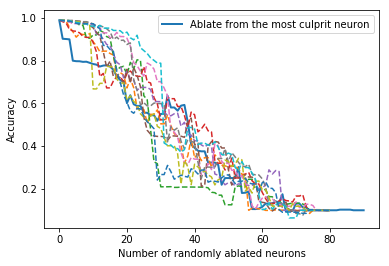

In [36]:
accumulate = True
abl_logs = ablation_test(config, resume, neuron_seq, accumulate)   

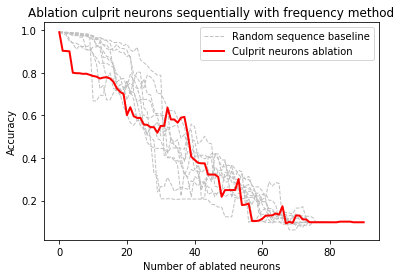

In [65]:
visualize_accumulate(abl_logs, class_specific = False)

In [38]:
score = clpt.culprit_ratio()
neuron_seq_ratio, score =  clpt.get_rank(score)

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6358776545524597, 'overal_acc': 0.9028, 'topk_acc': 0.9266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5955283382415771, 'overal_acc': 0.9023, 'topk_acc': 0.9324}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6175402359008789, 'overal_acc': 0.8993, 'topk_acc': 0.9316}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9505209748268127, 'overal_acc': 0.8013, 'topk_acc': 0.9196}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9631227478027343, 'overal_acc': 0.7998, 'topk_acc': 0.9185}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0708551528930663, 'overal_acc': 0.7958, 'topk_acc': 0.918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.366626481628418, 'overal_acc': 0.6975, 'topk_acc': 0.8262}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3534877256393432, 'overal_acc': 0.6941, 'topk_acc': 0.8221}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0120403112411498, 'overal_acc': 0.6965, 'topk_acc': 0.8444}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9767858335494995, 'overal_acc': 0.6963, 'topk_acc': 0.8476}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.051308892250061, 'overal_acc': 0.6914, 'topk_acc': 0.8345}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0079377552032471, 'overal_acc': 0.6883, 'topk_acc': 0.838}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9325030290603638, 'overal_acc': 0.6881, 'topk_acc': 0.8532}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9481299026489258, 'overal_acc': 0.688, 'topk_acc': 0.8544}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9924009262084961, 'overal_acc': 0.674, 'topk_acc': 0.8501}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1098469661712647, 'overal_acc': 0.665, 'topk_acc': 0.8216}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.113058491897583, 'overal_acc': 0.6642, 'topk_acc': 0.8215}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1368478229522705, 'overal_acc': 0.6563, 'topk_acc': 0.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1851757692337037, 'overal_acc': 0.6362, 'topk_acc': 0.8166}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2352085000991821, 'overal_acc': 0.614, 'topk_acc': 0.8243}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3513621894836425, 'overal_acc': 0.5901, 'topk_acc': 0.7859}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.535307897567749, 'overal_acc': 0.559, 'topk_acc': 0.7621}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.03279545173645, 'overal_acc': 0.4832, 'topk_acc': 0.6897}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7758688234329223, 'overal_acc': 0.5087, 'topk_acc': 0.7503}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7254626153945922, 'overal_acc': 0.4818, 'topk_acc': 0.7336}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.772101425933838, 'overal_acc': 0.471, 'topk_acc': 0.7227}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7721025184631347, 'overal_acc': 0.471, 'topk_acc': 0.7227}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8501670602798461, 'overal_acc': 0.4766, 'topk_acc': 0.7317}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8396097660064696, 'overal_acc': 0.4752, 'topk_acc': 0.7294}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7902161319732666, 'overal_acc': 0.4732, 'topk_acc': 0.7261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7902399662017823, 'overal_acc': 0.4732, 'topk_acc': 0.7261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.872647897720337, 'overal_acc': 0.4531, 'topk_acc': 0.6989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7786823614120484, 'overal_acc': 0.4853, 'topk_acc': 0.7404}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7786823614120484, 'overal_acc': 0.4853, 'topk_acc': 0.7404}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4314671211242675, 'overal_acc': 0.5539, 'topk_acc': 0.7707}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5127489797592164, 'overal_acc': 0.5182, 'topk_acc': 0.7587}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5127865100860596, 'overal_acc': 0.5182, 'topk_acc': 0.7587}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5181869045257568, 'overal_acc': 0.5172, 'topk_acc': 0.7425}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4479017627716064, 'overal_acc': 0.529, 'topk_acc': 0.7496}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.544755358695984, 'overal_acc': 0.4694, 'topk_acc': 0.749}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.850180442237854, 'overal_acc': 0.3396, 'topk_acc': 0.7207}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.916515544128418, 'overal_acc': 0.2962, 'topk_acc': 0.6786}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0421732406616213, 'overal_acc': 0.2937, 'topk_acc': 0.5957}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.069640747833252, 'overal_acc': 0.2839, 'topk_acc': 0.5915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.068821711349487, 'overal_acc': 0.2636, 'topk_acc': 0.5933}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.068816883087158, 'overal_acc': 0.2636, 'topk_acc': 0.5933}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2717192092895506, 'overal_acc': 0.2306, 'topk_acc': 0.4663}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2717192092895506, 'overal_acc': 0.2306, 'topk_acc': 0.4663}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.275123547363281, 'overal_acc': 0.229, 'topk_acc': 0.4661}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1812785636901855, 'overal_acc': 0.2293, 'topk_acc': 0.4437}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2163097370147704, 'overal_acc': 0.1742, 'topk_acc': 0.3941}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1584003280639648, 'overal_acc': 0.1854, 'topk_acc': 0.4057}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1584003280639648, 'overal_acc': 0.1854, 'topk_acc': 0.4057}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1583838916778566, 'overal_acc': 0.1854, 'topk_acc': 0.4057}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.158383916091919, 'overal_acc': 0.1854, 'topk_acc': 0.4057}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1427999046325685, 'overal_acc': 0.2504, 'topk_acc': 0.4087}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2349905101776124, 'overal_acc': 0.1475, 'topk_acc': 0.428}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2533026195526125, 'overal_acc': 0.1273, 'topk_acc': 0.3926}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2352062744140624, 'overal_acc': 0.1389, 'topk_acc': 0.409}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2497117778778075, 'overal_acc': 0.1009, 'topk_acc': 0.4012}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2487013332366943, 'overal_acc': 0.1009, 'topk_acc': 0.4047}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2376567455291747, 'overal_acc': 0.1009, 'topk_acc': 0.4076}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2036696868896484, 'overal_acc': 0.1014, 'topk_acc': 0.4426}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2369490509033203, 'overal_acc': 0.1048, 'topk_acc': 0.4197}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2434695468902586, 'overal_acc': 0.1055, 'topk_acc': 0.4151}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2594828716278075, 'overal_acc': 0.1041, 'topk_acc': 0.409}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.274371371459961, 'overal_acc': 0.106, 'topk_acc': 0.3814}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.277059885787964, 'overal_acc': 0.1074, 'topk_acc': 0.3869}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.277523530960083, 'overal_acc': 0.1366, 'topk_acc': 0.3927}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3028114837646485, 'overal_acc': 0.0951, 'topk_acc': 0.3131}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3026219718933105, 'overal_acc': 0.1081, 'topk_acc': 0.3139}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3043084342956544, 'overal_acc': 0.0784, 'topk_acc': 0.314}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302957476425171, 'overal_acc': 0.1395, 'topk_acc': 0.3391}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3010572303771974, 'overal_acc': 0.1395, 'topk_acc': 0.3391}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302350118637085, 'overal_acc': 0.1048, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302480511856079, 'overal_acc': 0.1048, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304120299911499, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3040384490966797, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3040384490966797, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.303969271850586, 'overal_acc': 0.098, 'topk_acc': 0.3089}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3039882049560547, 'overal_acc': 0.098, 'topk_acc': 0.3089}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3039882049560547, 'overal_acc': 0.098, 'topk_acc': 0.3089}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3039882049560547, 'overal_acc': 0.098, 'topk_acc': 0.3089}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3039882049560547, 'overal_acc': 0.098, 'topk_acc': 0.3089}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.303432707977295, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3033090007781984, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302584880065918, 'overal_acc': 0.098, 'topk_acc': 0.3147}
*** Ablating the culprit neuron sequence.
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03461838842630386, 'overal_acc': 0.9879, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03461838842630386, 'overal_acc': 0.9879, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04334432119131088, 'overal_acc': 0.9871, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04941843215227127, 'overal_acc': 0.9858, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06353504431247711, 'overal_acc': 0.9799, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.058858143723011014, 'overal_acc': 0.9809, 'topk_acc': 0.999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17789362983703613, 'overal_acc': 0.9344, 'topk_acc': 0.9969}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.18360502791404723, 'overal_acc': 0.9304, 'topk_acc': 0.997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.19257737216949464, 'overal_acc': 0.9257, 'topk_acc': 0.9966}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1945991057872772, 'overal_acc': 0.9246, 'topk_acc': 0.9962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2392310890674591, 'overal_acc': 0.9094, 'topk_acc': 0.9959}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23923108601570128, 'overal_acc': 0.9094, 'topk_acc': 0.9959}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2069710955142975, 'overal_acc': 0.9218, 'topk_acc': 0.9963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5769853368759156, 'overal_acc': 0.7949, 'topk_acc': 0.9796}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6126761920928955, 'overal_acc': 0.7904, 'topk_acc': 0.9735}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5430452383041382, 'overal_acc': 0.8129, 'topk_acc': 0.9746}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5500083331108093, 'overal_acc': 0.8126, 'topk_acc': 0.9728}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7440572673797607, 'overal_acc': 0.7486, 'topk_acc': 0.9563}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7440587383270264, 'overal_acc': 0.7486, 'topk_acc': 0.9563}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6735743423461914, 'overal_acc': 0.7757, 'topk_acc': 0.9583}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6858595560073852, 'overal_acc': 0.7696, 'topk_acc': 0.9587}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5827141147613525, 'overal_acc': 0.7872, 'topk_acc': 0.9654}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5164551536560058, 'overal_acc': 0.8159, 'topk_acc': 0.9732}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5164551536560058, 'overal_acc': 0.8159, 'topk_acc': 0.9732}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5153565133094787, 'overal_acc': 0.8169, 'topk_acc': 0.9737}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6097660457611084, 'overal_acc': 0.7588, 'topk_acc': 0.9685}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5854584619522095, 'overal_acc': 0.7779, 'topk_acc': 0.9701}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.46253654165267943, 'overal_acc': 0.8592, 'topk_acc': 0.9815}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4756815993309021, 'overal_acc': 0.8547, 'topk_acc': 0.9816}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4756832671165466, 'overal_acc': 0.8547, 'topk_acc': 0.9816}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4072044301986694, 'overal_acc': 0.8971, 'topk_acc': 0.9889}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4374141059875488, 'overal_acc': 0.8831, 'topk_acc': 0.991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4519231590270996, 'overal_acc': 0.8776, 'topk_acc': 0.991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.85485862865448, 'overal_acc': 0.7029, 'topk_acc': 0.9587}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8382143175125122, 'overal_acc': 0.7198, 'topk_acc': 0.943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8421017654418945, 'overal_acc': 0.7269, 'topk_acc': 0.9494}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0364121110916138, 'overal_acc': 0.6528, 'topk_acc': 0.909}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1219566274642945, 'overal_acc': 0.6386, 'topk_acc': 0.8989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1960655088424683, 'overal_acc': 0.6247, 'topk_acc': 0.879}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2697659006118776, 'overal_acc': 0.6001, 'topk_acc': 0.8495}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2730818918228148, 'overal_acc': 0.6165, 'topk_acc': 0.8526}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3630168117523194, 'overal_acc': 0.5481, 'topk_acc': 0.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.531445573425293, 'overal_acc': 0.4682, 'topk_acc': 0.7211}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6077315980911255, 'overal_acc': 0.4422, 'topk_acc': 0.6909}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6728797704696656, 'overal_acc': 0.4121, 'topk_acc': 0.6653}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.721741936302185, 'overal_acc': 0.4163, 'topk_acc': 0.6487}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7476606998443605, 'overal_acc': 0.4097, 'topk_acc': 0.6397}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.874713374710083, 'overal_acc': 0.3798, 'topk_acc': 0.5807}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.111657182312012, 'overal_acc': 0.3362, 'topk_acc': 0.5247}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.157737115859985, 'overal_acc': 0.3013, 'topk_acc': 0.4928}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.157737115859985, 'overal_acc': 0.3013, 'topk_acc': 0.4928}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1706315128326414, 'overal_acc': 0.2931, 'topk_acc': 0.4865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.207010675811768, 'overal_acc': 0.2647, 'topk_acc': 0.4442}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.231526165771484, 'overal_acc': 0.2614, 'topk_acc': 0.4354}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1962019233703614, 'overal_acc': 0.234, 'topk_acc': 0.4501}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1970921913146975, 'overal_acc': 0.2243, 'topk_acc': 0.4172}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.205809422302246, 'overal_acc': 0.2296, 'topk_acc': 0.4176}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2241496322631837, 'overal_acc': 0.1761, 'topk_acc': 0.3936}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2241496322631837, 'overal_acc': 0.1761, 'topk_acc': 0.3936}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2448076148986815, 'overal_acc': 0.1474, 'topk_acc': 0.3553}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2481842933654783, 'overal_acc': 0.1463, 'topk_acc': 0.3539}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2481842933654783, 'overal_acc': 0.1463, 'topk_acc': 0.3539}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2653864643096924, 'overal_acc': 0.1094, 'topk_acc': 0.3404}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.282550140762329, 'overal_acc': 0.1601, 'topk_acc': 0.357}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2849893161773682, 'overal_acc': 0.1716, 'topk_acc': 0.3499}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2849380825042727, 'overal_acc': 0.1703, 'topk_acc': 0.3478}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.284965853500366, 'overal_acc': 0.1703, 'topk_acc': 0.3471}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3053327285766603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305467385864258, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305450802230835, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305450802230835, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305450802230835, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054771575927733, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054771575927733, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055834827423096, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055569541931153, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055569541931153, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055569541931153, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 1th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04769987565279007, 'overal_acc': 0.9844, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.10166038340330123, 'overal_acc': 0.9672, 'topk_acc': 0.9969}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.13179709415435792, 'overal_acc': 0.9568, 'topk_acc': 0.9952}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1460488226532936, 'overal_acc': 0.9521, 'topk_acc': 0.9954}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.16217844967842102, 'overal_acc': 0.9464, 'topk_acc': 0.9949}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.19740028443336488, 'overal_acc': 0.9365, 'topk_acc': 0.993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23167698447704316, 'overal_acc': 0.9272, 'topk_acc': 0.9905}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2274917723417282, 'overal_acc': 0.9287, 'topk_acc': 0.9903}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4426862701892853, 'overal_acc': 0.8573, 'topk_acc': 0.9781}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4092498176574707, 'overal_acc': 0.8689, 'topk_acc': 0.9784}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.36761320819854737, 'overal_acc': 0.8837, 'topk_acc': 0.9772}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4208116698265076, 'overal_acc': 0.8659, 'topk_acc': 0.9749}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6572441464424134, 'overal_acc': 0.7922, 'topk_acc': 0.939}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6400920015335083, 'overal_acc': 0.7896, 'topk_acc': 0.9628}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6674172083854675, 'overal_acc': 0.7773, 'topk_acc': 0.9594}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7545268604278564, 'overal_acc': 0.7311, 'topk_acc': 0.9379}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6100587232589721, 'overal_acc': 0.7967, 'topk_acc': 0.9353}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7745609102249146, 'overal_acc': 0.7375, 'topk_acc': 0.9178}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8878130975723266, 'overal_acc': 0.7005, 'topk_acc': 0.8868}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9008730804443359, 'overal_acc': 0.6857, 'topk_acc': 0.8865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9008730804443359, 'overal_acc': 0.6857, 'topk_acc': 0.8865}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.905498655128479, 'overal_acc': 0.6811, 'topk_acc': 0.8821}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7549208934783935, 'overal_acc': 0.4637, 'topk_acc': 0.6738}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7744045608520507, 'overal_acc': 0.4552, 'topk_acc': 0.6695}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7415093070983887, 'overal_acc': 0.457, 'topk_acc': 0.6643}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.863373455429077, 'overal_acc': 0.4475, 'topk_acc': 0.6413}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.912890871810913, 'overal_acc': 0.4396, 'topk_acc': 0.6438}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9635824924468994, 'overal_acc': 0.4109, 'topk_acc': 0.6385}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9892426696777343, 'overal_acc': 0.4047, 'topk_acc': 0.631}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0054899742126464, 'overal_acc': 0.4028, 'topk_acc': 0.628}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9560307010650635, 'overal_acc': 0.3664, 'topk_acc': 0.6065}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0794029006958006, 'overal_acc': 0.3571, 'topk_acc': 0.5777}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2046021785736083, 'overal_acc': 0.347, 'topk_acc': 0.5417}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2106646953582763, 'overal_acc': 0.333, 'topk_acc': 0.5282}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.202731276702881, 'overal_acc': 0.3372, 'topk_acc': 0.5366}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1455583068847655, 'overal_acc': 0.3174, 'topk_acc': 0.5294}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.15947912940979, 'overal_acc': 0.2923, 'topk_acc': 0.533}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1154227882385253, 'overal_acc': 0.2672, 'topk_acc': 0.5051}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.145165585708618, 'overal_acc': 0.2617, 'topk_acc': 0.511}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1451688083648683, 'overal_acc': 0.2617, 'topk_acc': 0.511}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9716831565856934, 'overal_acc': 0.2974, 'topk_acc': 0.5675}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0016015537261964, 'overal_acc': 0.2778, 'topk_acc': 0.5542}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0020426677703855, 'overal_acc': 0.2778, 'topk_acc': 0.5542}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0020425090789793, 'overal_acc': 0.2778, 'topk_acc': 0.5542}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.061231386566162, 'overal_acc': 0.2748, 'topk_acc': 0.5421}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.061231386566162, 'overal_acc': 0.2748, 'topk_acc': 0.5421}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.100501033782959, 'overal_acc': 0.2495, 'topk_acc': 0.5333}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.168557692337036, 'overal_acc': 0.1697, 'topk_acc': 0.5529}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.168557692337036, 'overal_acc': 0.1697, 'topk_acc': 0.5529}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.168557692337036, 'overal_acc': 0.1697, 'topk_acc': 0.5529}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.158024983596802, 'overal_acc': 0.1807, 'topk_acc': 0.5602}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1200659202575682, 'overal_acc': 0.2345, 'topk_acc': 0.5468}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0949664543151854, 'overal_acc': 0.2424, 'topk_acc': 0.5186}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.168696081161499, 'overal_acc': 0.1862, 'topk_acc': 0.4669}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2401110942840576, 'overal_acc': 0.1639, 'topk_acc': 0.3899}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.245258363723755, 'overal_acc': 0.1484, 'topk_acc': 0.4012}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2287538921356203, 'overal_acc': 0.1477, 'topk_acc': 0.3874}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.234922664642334, 'overal_acc': 0.1436, 'topk_acc': 0.3783}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.267012624359131, 'overal_acc': 0.123, 'topk_acc': 0.3585}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.269082667541504, 'overal_acc': 0.1435, 'topk_acc': 0.3756}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.262326720046997, 'overal_acc': 0.1672, 'topk_acc': 0.4099}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2630461734771727, 'overal_acc': 0.1646, 'topk_acc': 0.4104}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.278994971847534, 'overal_acc': 0.1534, 'topk_acc': 0.3423}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2931324878692627, 'overal_acc': 0.1368, 'topk_acc': 0.3452}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2928118492126464, 'overal_acc': 0.145, 'topk_acc': 0.3508}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2939454257965086, 'overal_acc': 0.1454, 'topk_acc': 0.3508}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2936277229309083, 'overal_acc': 0.1404, 'topk_acc': 0.357}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2972657806396484, 'overal_acc': 0.1216, 'topk_acc': 0.3717}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2983985794067383, 'overal_acc': 0.1218, 'topk_acc': 0.3768}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.298625242996216, 'overal_acc': 0.1251, 'topk_acc': 0.3722}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.298247857284546, 'overal_acc': 0.1317, 'topk_acc': 0.357}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3041790431976317, 'overal_acc': 0.1015, 'topk_acc': 0.2957}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305546389770508, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305537351989746, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305532571411133, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 2th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08035268018245698, 'overal_acc': 0.9731, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07925960885286332, 'overal_acc': 0.9758, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.18781816463470458, 'overal_acc': 0.9373, 'topk_acc': 0.9914}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2126171089410782, 'overal_acc': 0.9235, 'topk_acc': 0.9905}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2126171089410782, 'overal_acc': 0.9235, 'topk_acc': 0.9905}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3589605360031128, 'overal_acc': 0.8686, 'topk_acc': 0.9839}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.572127562904358, 'overal_acc': 0.8029, 'topk_acc': 0.9624}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.457287783432007, 'overal_acc': 0.3605, 'topk_acc': 0.7043}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.6949273555755617, 'overal_acc': 0.3397, 'topk_acc': 0.6999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.666129528427124, 'overal_acc': 0.3357, 'topk_acc': 0.6678}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.015309259033203, 'overal_acc': 0.2681, 'topk_acc': 0.6954}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.3609365821838377, 'overal_acc': 0.3191, 'topk_acc': 0.6753}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.2772704540252686, 'overal_acc': 0.3385, 'topk_acc': 0.6682}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.2944383865356444, 'overal_acc': 0.2836, 'topk_acc': 0.6839}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.7082070182800293, 'overal_acc': 0.2583, 'topk_acc': 0.6779}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.7640479122161867, 'overal_acc': 0.2496, 'topk_acc': 0.6763}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.872248607635498, 'overal_acc': 0.2314, 'topk_acc': 0.6824}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.7246604946136475, 'overal_acc': 0.2538, 'topk_acc': 0.6605}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.5973108654022217, 'overal_acc': 0.2343, 'topk_acc': 0.6522}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.9661967224121093, 'overal_acc': 0.1881, 'topk_acc': 0.6262}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.311257549285889, 'overal_acc': 0.1674, 'topk_acc': 0.6013}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.429188095855713, 'overal_acc': 0.1423, 'topk_acc': 0.5588}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.706159715270996, 'overal_acc': 0.1138, 'topk_acc': 0.5346}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.695212660980225, 'overal_acc': 0.1146, 'topk_acc': 0.5321}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.540186848449707, 'overal_acc': 0.118, 'topk_acc': 0.4864}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.540186848449707, 'overal_acc': 0.118, 'topk_acc': 0.4864}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.666767482757568, 'overal_acc': 0.1135, 'topk_acc': 0.4867}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.706445006561279, 'overal_acc': 0.1116, 'topk_acc': 0.4895}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.396230033874511, 'overal_acc': 0.1045, 'topk_acc': 0.4867}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.100810374450684, 'overal_acc': 0.1058, 'topk_acc': 0.4849}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2582648403167727, 'overal_acc': 0.2079, 'topk_acc': 0.5873}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.663893521118164, 'overal_acc': 0.1719, 'topk_acc': 0.5162}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1915861854553222, 'overal_acc': 0.1856, 'topk_acc': 0.6143}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1915861854553222, 'overal_acc': 0.1856, 'topk_acc': 0.6143}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1915861854553222, 'overal_acc': 0.1856, 'topk_acc': 0.6143}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1589567657470705, 'overal_acc': 0.1924, 'topk_acc': 0.6002}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9214307500839234, 'overal_acc': 0.2755, 'topk_acc': 0.5921}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9742874557495118, 'overal_acc': 0.2559, 'topk_acc': 0.5813}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0328962211608888, 'overal_acc': 0.2357, 'topk_acc': 0.5309}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0328962211608888, 'overal_acc': 0.2357, 'topk_acc': 0.5309}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0678527347564697, 'overal_acc': 0.2291, 'topk_acc': 0.4918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0678527347564697, 'overal_acc': 0.2291, 'topk_acc': 0.4918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.112784407043457, 'overal_acc': 0.2143, 'topk_acc': 0.4811}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1318384590148924, 'overal_acc': 0.2142, 'topk_acc': 0.4609}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.13622845993042, 'overal_acc': 0.2137, 'topk_acc': 0.4568}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2191511623382567, 'overal_acc': 0.1771, 'topk_acc': 0.4457}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1092252822875976, 'overal_acc': 0.1811, 'topk_acc': 0.4537}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1471770725250243, 'overal_acc': 0.1826, 'topk_acc': 0.4377}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0984993225097655, 'overal_acc': 0.2097, 'topk_acc': 0.4741}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0793814777374267, 'overal_acc': 0.2188, 'topk_acc': 0.4814}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1297539684295654, 'overal_acc': 0.1653, 'topk_acc': 0.4825}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1297553966522216, 'overal_acc': 0.1653, 'topk_acc': 0.4825}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.193911619186401, 'overal_acc': 0.1576, 'topk_acc': 0.3911}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1962593292236328, 'overal_acc': 0.1564, 'topk_acc': 0.3882}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2188161308288574, 'overal_acc': 0.1239, 'topk_acc': 0.3873}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2320459526062013, 'overal_acc': 0.1594, 'topk_acc': 0.4083}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.205025570297241, 'overal_acc': 0.1517, 'topk_acc': 0.4233}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2081344188690184, 'overal_acc': 0.1677, 'topk_acc': 0.3915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2180706066131592, 'overal_acc': 0.19, 'topk_acc': 0.4423}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2292376651763917, 'overal_acc': 0.1729, 'topk_acc': 0.4183}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.24238113822937, 'overal_acc': 0.1703, 'topk_acc': 0.4094}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2297812480926513, 'overal_acc': 0.1645, 'topk_acc': 0.4274}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.229049814605713, 'overal_acc': 0.1637, 'topk_acc': 0.429}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2290488624572755, 'overal_acc': 0.1637, 'topk_acc': 0.429}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2338790866851808, 'overal_acc': 0.1646, 'topk_acc': 0.4219}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2355063022613524, 'overal_acc': 0.1492, 'topk_acc': 0.3826}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.244512048339844, 'overal_acc': 0.1411, 'topk_acc': 0.355}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2967993743896487, 'overal_acc': 0.1516, 'topk_acc': 0.3094}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2961630489349365, 'overal_acc': 0.1312, 'topk_acc': 0.3251}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2954503925323486, 'overal_acc': 0.1326, 'topk_acc': 0.3251}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2969025047302245, 'overal_acc': 0.1274, 'topk_acc': 0.3135}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3079934364318846, 'overal_acc': 0.1011, 'topk_acc': 0.2983}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3104260276794433, 'overal_acc': 0.0898, 'topk_acc': 0.2482}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2965938632965086, 'overal_acc': 0.1065, 'topk_acc': 0.2929}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3006362201690673, 'overal_acc': 0.1134, 'topk_acc': 0.3075}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306030904388428, 'overal_acc': 0.1193, 'topk_acc': 0.2962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305649966430664, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305649966430664, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 3th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0406265607714653, 'overal_acc': 0.9868, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0406265607714653, 'overal_acc': 0.9868, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04891847947835922, 'overal_acc': 0.9847, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05344640723466873, 'overal_acc': 0.9837, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.057909823501110076, 'overal_acc': 0.9825, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06287610578536987, 'overal_acc': 0.9807, 'topk_acc': 0.9986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07604176292419433, 'overal_acc': 0.9764, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1187045423746109, 'overal_acc': 0.9631, 'topk_acc': 0.9972}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1620550696849823, 'overal_acc': 0.949, 'topk_acc': 0.9962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1620550696849823, 'overal_acc': 0.949, 'topk_acc': 0.9962}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.17813450264930725, 'overal_acc': 0.9444, 'topk_acc': 0.9958}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.40731567730903623, 'overal_acc': 0.8725, 'topk_acc': 0.9935}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3752655412197113, 'overal_acc': 0.8796, 'topk_acc': 0.9928}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8715548126220704, 'overal_acc': 0.7495, 'topk_acc': 0.9832}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8715548126220704, 'overal_acc': 0.7495, 'topk_acc': 0.9832}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1342175018310547, 'overal_acc': 0.6461, 'topk_acc': 0.9732}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1342175018310547, 'overal_acc': 0.6461, 'topk_acc': 0.9732}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.7855719215393067, 'overal_acc': 0.4157, 'topk_acc': 0.8427}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.161095036315918, 'overal_acc': 0.4703, 'topk_acc': 0.8516}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.440944915008545, 'overal_acc': 0.4268, 'topk_acc': 0.8385}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1719964946746826, 'overal_acc': 0.4742, 'topk_acc': 0.8089}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7683436044692993, 'overal_acc': 0.5112, 'topk_acc': 0.8433}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2885871999740601, 'overal_acc': 0.5806, 'topk_acc': 0.8971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2887033527374268, 'overal_acc': 0.5804, 'topk_acc': 0.8971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3602060083389282, 'overal_acc': 0.5763, 'topk_acc': 0.858}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1925519094467163, 'overal_acc': 0.59, 'topk_acc': 0.885}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2726819232940674, 'overal_acc': 0.5605, 'topk_acc': 0.8848}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5185845249176024, 'overal_acc': 0.5036, 'topk_acc': 0.8292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5619963548660278, 'overal_acc': 0.4865, 'topk_acc': 0.8331}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7492236877441407, 'overal_acc': 0.442, 'topk_acc': 0.7873}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6227900691986084, 'overal_acc': 0.4627, 'topk_acc': 0.8074}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.712332109260559, 'overal_acc': 0.4464, 'topk_acc': 0.7903}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0967902671813965, 'overal_acc': 0.3598, 'topk_acc': 0.7408}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1397854530334475, 'overal_acc': 0.44, 'topk_acc': 0.6406}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.337191696929932, 'overal_acc': 0.3608, 'topk_acc': 0.6172}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.12436895236969, 'overal_acc': 0.356, 'topk_acc': 0.6097}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.310904308319092, 'overal_acc': 0.3269, 'topk_acc': 0.5279}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.411926432418823, 'overal_acc': 0.3491, 'topk_acc': 0.5126}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3022802799224853, 'overal_acc': 0.3404, 'topk_acc': 0.5097}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.369993982696533, 'overal_acc': 0.3203, 'topk_acc': 0.4905}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.120748960494995, 'overal_acc': 0.3477, 'topk_acc': 0.5114}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1512472213745117, 'overal_acc': 0.329, 'topk_acc': 0.5028}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1835180652618407, 'overal_acc': 0.3306, 'topk_acc': 0.4985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0591129962921144, 'overal_acc': 0.2708, 'topk_acc': 0.5487}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.070215054321289, 'overal_acc': 0.2701, 'topk_acc': 0.5441}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0413681159973143, 'overal_acc': 0.1959, 'topk_acc': 0.5915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1146961410522462, 'overal_acc': 0.1221, 'topk_acc': 0.5427}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0898457180023193, 'overal_acc': 0.1381, 'topk_acc': 0.5712}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.210868175125122, 'overal_acc': 0.1064, 'topk_acc': 0.5152}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2396937061309816, 'overal_acc': 0.1066, 'topk_acc': 0.4153}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2597699199676513, 'overal_acc': 0.1121, 'topk_acc': 0.4271}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.259329136657715, 'overal_acc': 0.1136, 'topk_acc': 0.4188}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2606278270721436, 'overal_acc': 0.1133, 'topk_acc': 0.4159}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2533623443603514, 'overal_acc': 0.0974, 'topk_acc': 0.4662}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2533623443603514, 'overal_acc': 0.0974, 'topk_acc': 0.4662}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.298320698928833, 'overal_acc': 0.0894, 'topk_acc': 0.3803}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2976941360473635, 'overal_acc': 0.0808, 'topk_acc': 0.3161}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30100779876709, 'overal_acc': 0.0726, 'topk_acc': 0.3189}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3022592113494875, 'overal_acc': 0.0666, 'topk_acc': 0.3178}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.302259052658081, 'overal_acc': 0.0666, 'topk_acc': 0.3178}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.299343344116211, 'overal_acc': 0.0659, 'topk_acc': 0.3335}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.307511980819702, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306704104614258, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066773498535156, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066773498535156, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066530296325682, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3066530296325682, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306646523284912, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306630278015137, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306630278015137, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306630278015137, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3069392139434814, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3069392139434814, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3065252883911134, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305777346801758, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305753734970093, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305753734970093, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 4th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03381034432053566, 'overal_acc': 0.9884, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03956719101667404, 'overal_acc': 0.986, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04228443588018417, 'overal_acc': 0.9853, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05431236342191696, 'overal_acc': 0.9829, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05546667730808258, 'overal_acc': 0.982, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07450538904666901, 'overal_acc': 0.9755, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08793419711589813, 'overal_acc': 0.9711, 'topk_acc': 0.9981}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23724885165691376, 'overal_acc': 0.925, 'topk_acc': 0.9943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2372604086637497, 'overal_acc': 0.925, 'topk_acc': 0.9943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23142983260154723, 'overal_acc': 0.9259, 'topk_acc': 0.9945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2974137634277344, 'overal_acc': 0.9072, 'topk_acc': 0.9927}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2974137634277344, 'overal_acc': 0.9072, 'topk_acc': 0.9927}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3758266785144806, 'overal_acc': 0.8955, 'topk_acc': 0.9925}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.43682034163475036, 'overal_acc': 0.8764, 'topk_acc': 0.988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4635113557338715, 'overal_acc': 0.8696, 'topk_acc': 0.9876}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4635113557338715, 'overal_acc': 0.8696, 'topk_acc': 0.9876}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6130878375053406, 'overal_acc': 0.8021, 'topk_acc': 0.9695}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7438879633903503, 'overal_acc': 0.7603, 'topk_acc': 0.9545}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7597033621788025, 'overal_acc': 0.7543, 'topk_acc': 0.9465}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7360083067893982, 'overal_acc': 0.7355, 'topk_acc': 0.945}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7729310845375061, 'overal_acc': 0.7165, 'topk_acc': 0.9444}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8514358897209168, 'overal_acc': 0.7084, 'topk_acc': 0.9418}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9065887477874756, 'overal_acc': 0.6836, 'topk_acc': 0.9413}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9215647331237793, 'overal_acc': 0.6752, 'topk_acc': 0.9427}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2271880304336549, 'overal_acc': 0.6164, 'topk_acc': 0.9236}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.845306407928467, 'overal_acc': 0.4727, 'topk_acc': 0.852}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.66491372051239, 'overal_acc': 0.4805, 'topk_acc': 0.8698}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.717232333946228, 'overal_acc': 0.4515, 'topk_acc': 0.8137}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.116313749694824, 'overal_acc': 0.592, 'topk_acc': 0.9188}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4077283508300782, 'overal_acc': 0.4448, 'topk_acc': 0.8719}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4830631889343262, 'overal_acc': 0.434, 'topk_acc': 0.8328}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6004172412872315, 'overal_acc': 0.3647, 'topk_acc': 0.8137}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5859901782989503, 'overal_acc': 0.3628, 'topk_acc': 0.792}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3814677083969116, 'overal_acc': 0.504, 'topk_acc': 0.8409}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.912439891242981, 'overal_acc': 0.3021, 'topk_acc': 0.5908}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9132685417175292, 'overal_acc': 0.3021, 'topk_acc': 0.5844}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9216701848983764, 'overal_acc': 0.2722, 'topk_acc': 0.6214}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.051302116012573, 'overal_acc': 0.2421, 'topk_acc': 0.5752}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.043507428741455, 'overal_acc': 0.2336, 'topk_acc': 0.5861}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1146268993377686, 'overal_acc': 0.2522, 'topk_acc': 0.5422}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.180216151046753, 'overal_acc': 0.2236, 'topk_acc': 0.5405}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1371180126190183, 'overal_acc': 0.2382, 'topk_acc': 0.5515}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.148226258468628, 'overal_acc': 0.2391, 'topk_acc': 0.5543}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.195217642211914, 'overal_acc': 0.2362, 'topk_acc': 0.5521}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.195104089355469, 'overal_acc': 0.2362, 'topk_acc': 0.5518}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1757988525390624, 'overal_acc': 0.2378, 'topk_acc': 0.5337}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1028791938781737, 'overal_acc': 0.2663, 'topk_acc': 0.5345}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9150518043518066, 'overal_acc': 0.3447, 'topk_acc': 0.7141}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9210196224212646, 'overal_acc': 0.336, 'topk_acc': 0.7343}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9213454048156737, 'overal_acc': 0.3633, 'topk_acc': 0.7294}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.921447152709961, 'overal_acc': 0.3629, 'topk_acc': 0.7291}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.921447152709961, 'overal_acc': 0.3629, 'topk_acc': 0.7291}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.943333029937744, 'overal_acc': 0.3693, 'topk_acc': 0.7296}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9762900203704834, 'overal_acc': 0.3432, 'topk_acc': 0.6955}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9909230266571045, 'overal_acc': 0.3183, 'topk_acc': 0.6736}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.029091166305542, 'overal_acc': 0.2546, 'topk_acc': 0.6015}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.061173196411133, 'overal_acc': 0.2702, 'topk_acc': 0.6033}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.135182913208008, 'overal_acc': 0.2315, 'topk_acc': 0.5847}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1877663318634033, 'overal_acc': 0.1931, 'topk_acc': 0.4933}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.191117963409424, 'overal_acc': 0.179, 'topk_acc': 0.5261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.206695141220093, 'overal_acc': 0.1812, 'topk_acc': 0.4273}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.206695141220093, 'overal_acc': 0.1812, 'topk_acc': 0.4273}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.211186392211914, 'overal_acc': 0.2061, 'topk_acc': 0.5159}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2112232681274415, 'overal_acc': 0.2061, 'topk_acc': 0.5156}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2112232681274415, 'overal_acc': 0.2061, 'topk_acc': 0.5156}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2223558532714844, 'overal_acc': 0.1904, 'topk_acc': 0.5208}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2223558532714844, 'overal_acc': 0.1904, 'topk_acc': 0.5208}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2542991958618166, 'overal_acc': 0.1282, 'topk_acc': 0.4036}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.262584352493286, 'overal_acc': 0.1196, 'topk_acc': 0.3915}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.265446994018555, 'overal_acc': 0.1177, 'topk_acc': 0.3918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2835740421295165, 'overal_acc': 0.0979, 'topk_acc': 0.3292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2938716232299803, 'overal_acc': 0.098, 'topk_acc': 0.2728}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.290120679473877, 'overal_acc': 0.0987, 'topk_acc': 0.2816}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306357911682129, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3063929973602293, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3063929973602293, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3063929973602293, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 5th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03541151992082596, 'overal_acc': 0.9883, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04109819707870484, 'overal_acc': 0.9862, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04110475971698761, 'overal_acc': 0.9869, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04522933282852173, 'overal_acc': 0.9855, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04945054620504379, 'overal_acc': 0.9842, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7742685104370117, 'overal_acc': 0.7573, 'topk_acc': 0.9221}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7742685104370117, 'overal_acc': 0.7573, 'topk_acc': 0.9221}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6684792094230652, 'overal_acc': 0.7845, 'topk_acc': 0.9365}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7639529895782471, 'overal_acc': 0.7478, 'topk_acc': 0.9317}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5828110531806946, 'overal_acc': 0.8138, 'topk_acc': 0.9486}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.630160749053955, 'overal_acc': 0.7959, 'topk_acc': 0.9411}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7091565176963807, 'overal_acc': 0.7573, 'topk_acc': 0.9364}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7223219110488892, 'overal_acc': 0.7557, 'topk_acc': 0.9335}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.97958215675354, 'overal_acc': 0.6847, 'topk_acc': 0.8878}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.120268830871582, 'overal_acc': 0.6548, 'topk_acc': 0.8693}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.14183601436615, 'overal_acc': 0.6651, 'topk_acc': 0.8399}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.244247567176819, 'overal_acc': 0.625, 'topk_acc': 0.8339}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3743758922576905, 'overal_acc': 0.6216, 'topk_acc': 0.8048}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3743758922576905, 'overal_acc': 0.6216, 'topk_acc': 0.8048}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.405247200202942, 'overal_acc': 0.6362, 'topk_acc': 0.7974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.565404232788086, 'overal_acc': 0.5513, 'topk_acc': 0.7919}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.565404232788086, 'overal_acc': 0.5513, 'topk_acc': 0.7919}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5030342391967773, 'overal_acc': 0.5885, 'topk_acc': 0.7698}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8143770118713378, 'overal_acc': 0.5658, 'topk_acc': 0.7383}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2218031497955324, 'overal_acc': 0.5019, 'topk_acc': 0.6773}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9373691581726074, 'overal_acc': 0.5199, 'topk_acc': 0.7395}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9373691581726074, 'overal_acc': 0.5199, 'topk_acc': 0.7395}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9373691581726074, 'overal_acc': 0.5199, 'topk_acc': 0.7395}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.172257541656494, 'overal_acc': 0.497, 'topk_acc': 0.7054}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2457595722198485, 'overal_acc': 0.4489, 'topk_acc': 0.7031}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2457595722198485, 'overal_acc': 0.4489, 'topk_acc': 0.7031}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4191806648254395, 'overal_acc': 0.4105, 'topk_acc': 0.6966}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.973874390792847, 'overal_acc': 0.3272, 'topk_acc': 0.6289}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.820791374588013, 'overal_acc': 0.3424, 'topk_acc': 0.6313}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.851166627883911, 'overal_acc': 0.3423, 'topk_acc': 0.629}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.6290705322265624, 'overal_acc': 0.3473, 'topk_acc': 0.6551}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1519092376708984, 'overal_acc': 0.2979, 'topk_acc': 0.7234}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7610652332305907, 'overal_acc': 0.4008, 'topk_acc': 0.6934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7689214527130126, 'overal_acc': 0.4024, 'topk_acc': 0.6913}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.742828685760498, 'overal_acc': 0.4383, 'topk_acc': 0.7057}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7647351690292359, 'overal_acc': 0.4401, 'topk_acc': 0.6761}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7506001314163209, 'overal_acc': 0.4157, 'topk_acc': 0.672}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7506001314163209, 'overal_acc': 0.4157, 'topk_acc': 0.672}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8001599670410156, 'overal_acc': 0.3912, 'topk_acc': 0.667}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8316756895065307, 'overal_acc': 0.4008, 'topk_acc': 0.6599}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9086908477783202, 'overal_acc': 0.3559, 'topk_acc': 0.6289}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9587590084075928, 'overal_acc': 0.3526, 'topk_acc': 0.5781}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.962603006362915, 'overal_acc': 0.3394, 'topk_acc': 0.5578}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9626024814605714, 'overal_acc': 0.3394, 'topk_acc': 0.5578}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0872244594573974, 'overal_acc': 0.313, 'topk_acc': 0.5408}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0872244594573974, 'overal_acc': 0.313, 'topk_acc': 0.5408}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0361986713409426, 'overal_acc': 0.3037, 'topk_acc': 0.555}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0810039363861086, 'overal_acc': 0.2697, 'topk_acc': 0.4932}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1152831848144533, 'overal_acc': 0.2185, 'topk_acc': 0.469}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1090531600952147, 'overal_acc': 0.287, 'topk_acc': 0.4846}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1135238132476806, 'overal_acc': 0.2917, 'topk_acc': 0.4916}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.138724565887451, 'overal_acc': 0.2177, 'topk_acc': 0.5068}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.214204967880249, 'overal_acc': 0.2024, 'topk_acc': 0.3639}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.223121718215942, 'overal_acc': 0.1906, 'topk_acc': 0.3459}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.239962330627441, 'overal_acc': 0.1992, 'topk_acc': 0.3529}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.247457928466797, 'overal_acc': 0.1914, 'topk_acc': 0.3521}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.252163610458374, 'overal_acc': 0.1881, 'topk_acc': 0.3483}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2679141143798827, 'overal_acc': 0.2468, 'topk_acc': 0.3992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2839250244140623, 'overal_acc': 0.2162, 'topk_acc': 0.4312}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3037109077453612, 'overal_acc': 0.1848, 'topk_acc': 0.3697}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305737613296509, 'overal_acc': 0.1866, 'topk_acc': 0.3709}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3149212898254397, 'overal_acc': 0.1603, 'topk_acc': 0.353}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2685722999572753, 'overal_acc': 0.1452, 'topk_acc': 0.3373}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.268648642730713, 'overal_acc': 0.1452, 'topk_acc': 0.337}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.295127562332153, 'overal_acc': 0.1412, 'topk_acc': 0.3002}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.295164835739136, 'overal_acc': 0.1412, 'topk_acc': 0.3003}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.295164835739136, 'overal_acc': 0.1412, 'topk_acc': 0.3003}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.295164835739136, 'overal_acc': 0.1412, 'topk_acc': 0.3003}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3024778366088867, 'overal_acc': 0.1327, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058501007080077, 'overal_acc': 0.0928, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057067359924317, 'overal_acc': 0.0981, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3061108070373537, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3060576198577882, 'overal_acc': 0.098, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 6th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035625475025177, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03752315641641617, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03752315641641617, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1595759970188141, 'overal_acc': 0.9496, 'topk_acc': 0.9965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23671314678192137, 'overal_acc': 0.9253, 'topk_acc': 0.996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2525365740776062, 'overal_acc': 0.9197, 'topk_acc': 0.9939}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.293065651512146, 'overal_acc': 0.9065, 'topk_acc': 0.994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.22522078452110292, 'overal_acc': 0.9254, 'topk_acc': 0.9943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2654447822093964, 'overal_acc': 0.9074, 'topk_acc': 0.9935}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.33624724531173705, 'overal_acc': 0.8791, 'topk_acc': 0.9924}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.33624724531173705, 'overal_acc': 0.8791, 'topk_acc': 0.9924}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.33377892088890077, 'overal_acc': 0.8806, 'topk_acc': 0.9922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.33377892088890077, 'overal_acc': 0.8806, 'topk_acc': 0.9922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3905584635734558, 'overal_acc': 0.8664, 'topk_acc': 0.9885}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5592086249351501, 'overal_acc': 0.8079, 'topk_acc': 0.984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6886697608947754, 'overal_acc': 0.7687, 'topk_acc': 0.9764}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6400090927124024, 'overal_acc': 0.7752, 'topk_acc': 0.9772}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8546437797546387, 'overal_acc': 0.7084, 'topk_acc': 0.9626}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8918865481376648, 'overal_acc': 0.6972, 'topk_acc': 0.9603}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8953405737876892, 'overal_acc': 0.6953, 'topk_acc': 0.9431}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1191843778610229, 'overal_acc': 0.6399, 'topk_acc': 0.911}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1191881437301636, 'overal_acc': 0.6399, 'topk_acc': 0.911}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0329249046325684, 'overal_acc': 0.6274, 'topk_acc': 0.9305}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0444007675170899, 'overal_acc': 0.6219, 'topk_acc': 0.9261}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1414604078292847, 'overal_acc': 0.5889, 'topk_acc': 0.9202}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.141421241569519, 'overal_acc': 0.5889, 'topk_acc': 0.9202}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.141428841972351, 'overal_acc': 0.5889, 'topk_acc': 0.9202}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.5366328224182129, 'overal_acc': 0.4777, 'topk_acc': 0.8952}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.3068367748260497, 'overal_acc': 0.28, 'topk_acc': 0.6806}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.623083913421631, 'overal_acc': 0.2582, 'topk_acc': 0.6473}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.623083913421631, 'overal_acc': 0.2582, 'topk_acc': 0.6473}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.7079734859466553, 'overal_acc': 0.2515, 'topk_acc': 0.6454}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.873282154083252, 'overal_acc': 0.306, 'topk_acc': 0.6377}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.886769858932495, 'overal_acc': 0.2249, 'topk_acc': 0.6935}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.6329559532165527, 'overal_acc': 0.2554, 'topk_acc': 0.7243}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.0957024967193605, 'overal_acc': 0.1709, 'topk_acc': 0.6784}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.273135214614868, 'overal_acc': 0.2555, 'topk_acc': 0.7126}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1290893276214597, 'overal_acc': 0.3029, 'topk_acc': 0.6559}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1140226581573485, 'overal_acc': 0.3138, 'topk_acc': 0.6608}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9344994873046875, 'overal_acc': 0.3475, 'topk_acc': 0.6695}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.847190364074707, 'overal_acc': 0.3527, 'topk_acc': 0.6593}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8578168943405151, 'overal_acc': 0.3514, 'topk_acc': 0.6588}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8746673904418945, 'overal_acc': 0.3439, 'topk_acc': 0.661}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8704684459686278, 'overal_acc': 0.3715, 'topk_acc': 0.657}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0045460220336913, 'overal_acc': 0.2979, 'topk_acc': 0.6589}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1090911293029784, 'overal_acc': 0.2592, 'topk_acc': 0.6961}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.065187857055664, 'overal_acc': 0.2675, 'topk_acc': 0.6881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0324980541229247, 'overal_acc': 0.2637, 'topk_acc': 0.64}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.095804909133911, 'overal_acc': 0.2055, 'topk_acc': 0.5874}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7698866027832032, 'overal_acc': 0.3971, 'topk_acc': 0.8183}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8445604446411132, 'overal_acc': 0.3674, 'topk_acc': 0.7828}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.924858250427246, 'overal_acc': 0.3648, 'topk_acc': 0.7554}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9459948852539062, 'overal_acc': 0.3638, 'topk_acc': 0.7827}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0116822662353515, 'overal_acc': 0.3404, 'topk_acc': 0.7202}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.034351658248901, 'overal_acc': 0.313, 'topk_acc': 0.7158}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0604065998077394, 'overal_acc': 0.2951, 'topk_acc': 0.712}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0604065998077394, 'overal_acc': 0.2951, 'topk_acc': 0.712}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.183296826553345, 'overal_acc': 0.2328, 'topk_acc': 0.52}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1875516426086428, 'overal_acc': 0.2209, 'topk_acc': 0.5178}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.23789436340332, 'overal_acc': 0.2104, 'topk_acc': 0.502}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.281785325241089, 'overal_acc': 0.2074, 'topk_acc': 0.4001}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2830937294006346, 'overal_acc': 0.2174, 'topk_acc': 0.3944}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2828828033447266, 'overal_acc': 0.221, 'topk_acc': 0.3948}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059919677734375, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059668521881105, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059668521881105, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059668521881105, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3059394130706785, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3060566680908203, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056631301879884, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3055774311065673, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056500465393066, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056500465393066, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056746669769286, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056746669769286, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 7th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05948704998493195, 'overal_acc': 0.9816, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08033717284202575, 'overal_acc': 0.9732, 'topk_acc': 0.9988}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.09792741005420685, 'overal_acc': 0.9675, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12165180439949036, 'overal_acc': 0.9588, 'topk_acc': 0.997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1264279040813446, 'overal_acc': 0.9574, 'topk_acc': 0.9971}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.16675376892089844, 'overal_acc': 0.9442, 'topk_acc': 0.9943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.21223688793182374, 'overal_acc': 0.9289, 'topk_acc': 0.9921}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2018236186027527, 'overal_acc': 0.9309, 'topk_acc': 0.9925}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.19393383827209473, 'overal_acc': 0.9342, 'topk_acc': 0.9931}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.22435253400802613, 'overal_acc': 0.9204, 'topk_acc': 0.9932}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23175328192710876, 'overal_acc': 0.9195, 'topk_acc': 0.9934}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4932597297668457, 'overal_acc': 0.8198, 'topk_acc': 0.9816}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.1887255538940429, 'overal_acc': 0.5944, 'topk_acc': 0.8998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9503797437667847, 'overal_acc': 0.6368, 'topk_acc': 0.9242}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0239461141586303, 'overal_acc': 0.6053, 'topk_acc': 0.9096}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0658598508834838, 'overal_acc': 0.592, 'topk_acc': 0.904}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0514233768463135, 'overal_acc': 0.5981, 'topk_acc': 0.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.076836983680725, 'overal_acc': 0.5902, 'topk_acc': 0.9047}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9282544776916504, 'overal_acc': 0.675, 'topk_acc': 0.9462}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2752766956329347, 'overal_acc': 0.5181, 'topk_acc': 0.8694}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.2754207246780396, 'overal_acc': 0.5181, 'topk_acc': 0.8692}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3332441444396972, 'overal_acc': 0.5105, 'topk_acc': 0.8622}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3452005140304566, 'overal_acc': 0.5116, 'topk_acc': 0.8614}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3452005140304566, 'overal_acc': 0.5116, 'topk_acc': 0.8614}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3512372301101685, 'overal_acc': 0.5722, 'topk_acc': 0.9064}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.38577511138916, 'overal_acc': 0.5408, 'topk_acc': 0.8878}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3865919023513793, 'overal_acc': 0.5609, 'topk_acc': 0.8884}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.39619385471344, 'overal_acc': 0.6039, 'topk_acc': 0.9001}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4195744443893432, 'overal_acc': 0.5829, 'topk_acc': 0.882}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4541600679397584, 'overal_acc': 0.5478, 'topk_acc': 0.8646}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8133053050994874, 'overal_acc': 0.4336, 'topk_acc': 0.734}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8251935663223267, 'overal_acc': 0.4291, 'topk_acc': 0.7348}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8149967273712158, 'overal_acc': 0.4387, 'topk_acc': 0.7533}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8150077991485596, 'overal_acc': 0.4387, 'topk_acc': 0.7533}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.821658348274231, 'overal_acc': 0.4285, 'topk_acc': 0.7544}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8547849006652832, 'overal_acc': 0.4053, 'topk_acc': 0.7438}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9156404371261597, 'overal_acc': 0.3051, 'topk_acc': 0.7352}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9156404371261597, 'overal_acc': 0.3051, 'topk_acc': 0.7352}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9242584348678589, 'overal_acc': 0.3324, 'topk_acc': 0.7075}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.898883069229126, 'overal_acc': 0.3617, 'topk_acc': 0.7319}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9489793153762818, 'overal_acc': 0.3699, 'topk_acc': 0.7485}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9563728160858154, 'overal_acc': 0.3676, 'topk_acc': 0.7451}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.980605012512207, 'overal_acc': 0.2808, 'topk_acc': 0.7583}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9809509719848633, 'overal_acc': 0.2809, 'topk_acc': 0.7579}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0203335304260253, 'overal_acc': 0.2373, 'topk_acc': 0.7004}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0699240558624266, 'overal_acc': 0.2448, 'topk_acc': 0.6406}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.074076139831543, 'overal_acc': 0.2184, 'topk_acc': 0.6338}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0679227699279785, 'overal_acc': 0.2169, 'topk_acc': 0.6362}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.126493021392822, 'overal_acc': 0.1502, 'topk_acc': 0.5563}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.153236658859253, 'overal_acc': 0.1403, 'topk_acc': 0.5359}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1532021560668944, 'overal_acc': 0.1403, 'topk_acc': 0.536}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1571062877655027, 'overal_acc': 0.1406, 'topk_acc': 0.5266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.157106544113159, 'overal_acc': 0.1406, 'topk_acc': 0.5266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.18592710647583, 'overal_acc': 0.1643, 'topk_acc': 0.508}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.191839541244507, 'overal_acc': 0.203, 'topk_acc': 0.4821}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2013696998596193, 'overal_acc': 0.2016, 'topk_acc': 0.4624}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1979909664154054, 'overal_acc': 0.2003, 'topk_acc': 0.4774}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2569193668365477, 'overal_acc': 0.1638, 'topk_acc': 0.4322}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.267135681915283, 'overal_acc': 0.118, 'topk_acc': 0.4287}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2766946918487547, 'overal_acc': 0.1402, 'topk_acc': 0.4096}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.283466189193726, 'overal_acc': 0.1138, 'topk_acc': 0.4123}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.283986097717285, 'overal_acc': 0.1141, 'topk_acc': 0.4122}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.286031494140625, 'overal_acc': 0.1236, 'topk_acc': 0.4125}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.287141030883789, 'overal_acc': 0.1111, 'topk_acc': 0.4134}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.287141030883789, 'overal_acc': 0.1111, 'topk_acc': 0.4134}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.29081676902771, 'overal_acc': 0.109, 'topk_acc': 0.4194}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2944023288726805, 'overal_acc': 0.106, 'topk_acc': 0.4081}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.294542279815674, 'overal_acc': 0.1061, 'topk_acc': 0.408}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3061734867095947, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3062207775115966, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058378021240236, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058378021240236, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3058378021240236, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3057734466552735, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 8th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031259263116121296, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.033387351369857786, 'overal_acc': 0.9882, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.054705600738525394, 'overal_acc': 0.9819, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08115993062257766, 'overal_acc': 0.9721, 'topk_acc': 0.9978}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.23712440629005432, 'overal_acc': 0.9221, 'topk_acc': 0.9924}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2685330179691315, 'overal_acc': 0.9115, 'topk_acc': 0.9897}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2685330179691315, 'overal_acc': 0.9115, 'topk_acc': 0.9897}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.27730935373306276, 'overal_acc': 0.9082, 'topk_acc': 0.9895}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.27730935373306276, 'overal_acc': 0.9082, 'topk_acc': 0.9895}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.27730935373306276, 'overal_acc': 0.9082, 'topk_acc': 0.9895}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2753365091323853, 'overal_acc': 0.9095, 'topk_acc': 0.9891}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2791202473163605, 'overal_acc': 0.9077, 'topk_acc': 0.9888}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2834794727325439, 'overal_acc': 0.9002, 'topk_acc': 0.9904}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3421097406387329, 'overal_acc': 0.8807, 'topk_acc': 0.9873}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.35346594734191894, 'overal_acc': 0.8749, 'topk_acc': 0.987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.37760787925720213, 'overal_acc': 0.8651, 'topk_acc': 0.9868}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5348714915275574, 'overal_acc': 0.8185, 'topk_acc': 0.963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5887675178527833, 'overal_acc': 0.8013, 'topk_acc': 0.9583}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5944135654449463, 'overal_acc': 0.7957, 'topk_acc': 0.966}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.631336178779602, 'overal_acc': 0.7839, 'topk_acc': 0.9646}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5310350660324097, 'overal_acc': 0.8127, 'topk_acc': 0.9742}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.57993324136734, 'overal_acc': 0.8017, 'topk_acc': 0.9781}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5199453994750977, 'overal_acc': 0.8274, 'topk_acc': 0.9786}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5732235296249389, 'overal_acc': 0.8005, 'topk_acc': 0.9697}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5575180126190186, 'overal_acc': 0.8087, 'topk_acc': 0.9726}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6721234969139099, 'overal_acc': 0.7625, 'topk_acc': 0.973}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6534332000732422, 'overal_acc': 0.7673, 'topk_acc': 0.9763}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.7265117360115051, 'overal_acc': 0.7216, 'topk_acc': 0.9695}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9056409721374512, 'overal_acc': 0.6459, 'topk_acc': 0.9446}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9777297634124756, 'overal_acc': 0.6246, 'topk_acc': 0.9251}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.9941537828445435, 'overal_acc': 0.6476, 'topk_acc': 0.922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0199027032852173, 'overal_acc': 0.6328, 'topk_acc': 0.9289}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0199027032852173, 'overal_acc': 0.6328, 'topk_acc': 0.9289}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.110182911682129, 'overal_acc': 0.5811, 'topk_acc': 0.9213}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4240437984466552, 'overal_acc': 0.4359, 'topk_acc': 0.8251}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.239873606300354, 'overal_acc': 0.5778, 'topk_acc': 0.8925}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3214783542633057, 'overal_acc': 0.5034, 'topk_acc': 0.8799}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4046477148056031, 'overal_acc': 0.4361, 'topk_acc': 0.8536}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.3439713214874267, 'overal_acc': 0.4714, 'topk_acc': 0.8772}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4044727140426636, 'overal_acc': 0.4437, 'topk_acc': 0.8717}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4673946195602416, 'overal_acc': 0.3971, 'topk_acc': 0.8687}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4666732969284058, 'overal_acc': 0.3971, 'topk_acc': 0.8686}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6084049198150634, 'overal_acc': 0.3094, 'topk_acc': 0.8258}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6056189865112305, 'overal_acc': 0.3259, 'topk_acc': 0.8001}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6056189865112305, 'overal_acc': 0.3259, 'topk_acc': 0.8001}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6127064071655273, 'overal_acc': 0.3144, 'topk_acc': 0.7985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.6520942239761351, 'overal_acc': 0.4073, 'topk_acc': 0.7063}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7328997844696046, 'overal_acc': 0.3507, 'topk_acc': 0.7014}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7787702867507935, 'overal_acc': 0.3037, 'topk_acc': 0.6774}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7787047653198242, 'overal_acc': 0.3038, 'topk_acc': 0.6774}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7787047653198242, 'overal_acc': 0.3038, 'topk_acc': 0.6774}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8195030952453612, 'overal_acc': 0.2623, 'topk_acc': 0.6547}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.873394630432129, 'overal_acc': 0.283, 'topk_acc': 0.6548}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9746264533996583, 'overal_acc': 0.2891, 'topk_acc': 0.5943}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9860944591522216, 'overal_acc': 0.2553, 'topk_acc': 0.5747}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9686009765625, 'overal_acc': 0.2595, 'topk_acc': 0.5874}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0097370502471925, 'overal_acc': 0.2184, 'topk_acc': 0.5526}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.055513927459717, 'overal_acc': 0.3624, 'topk_acc': 0.6254}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.147401280593872, 'overal_acc': 0.2773, 'topk_acc': 0.5686}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.147401280593872, 'overal_acc': 0.2773, 'topk_acc': 0.5686}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.142774459838867, 'overal_acc': 0.2917, 'topk_acc': 0.5618}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.1589790508270266, 'overal_acc': 0.2807, 'topk_acc': 0.5645}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2346678356170653, 'overal_acc': 0.2044, 'topk_acc': 0.514}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.240277713775635, 'overal_acc': 0.1621, 'topk_acc': 0.502}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.240315250778198, 'overal_acc': 0.162, 'topk_acc': 0.5011}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2511899662017822, 'overal_acc': 0.1578, 'topk_acc': 0.4418}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.290883371734619, 'overal_acc': 0.0982, 'topk_acc': 0.3711}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2891999828338623, 'overal_acc': 0.1023, 'topk_acc': 0.3886}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3019323650360106, 'overal_acc': 0.1127, 'topk_acc': 0.3226}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3036805644989014, 'overal_acc': 0.0998, 'topk_acc': 0.2806}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30782727355957, 'overal_acc': 0.068, 'topk_acc': 0.2847}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.306495273590088, 'overal_acc': 0.1002, 'topk_acc': 0.2547}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3021101978302, 'overal_acc': 0.0946, 'topk_acc': 0.2796}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3032386978149413, 'overal_acc': 0.0939, 'topk_acc': 0.3176}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3046442359924315, 'overal_acc': 0.098, 'topk_acc': 0.3064}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305454182052612, 'overal_acc': 0.1275, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3054763378143313, 'overal_acc': 0.1274, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3056791988372805, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 9th trial
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.032847715163230894, 'overal_acc': 0.9887, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03629844049215317, 'overal_acc': 0.9876, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07453694484233857, 'overal_acc': 0.9757, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.07453694484233857, 'overal_acc': 0.9757, 'topk_acc': 0.9985}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.09812291471958161, 'overal_acc': 0.9673, 'topk_acc': 0.9979}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.12519720077514648, 'overal_acc': 0.9563, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1339993330001831, 'overal_acc': 0.9525, 'topk_acc': 0.9974}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.1893707139492035, 'overal_acc': 0.935, 'topk_acc': 0.9967}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2669948646068573, 'overal_acc': 0.9096, 'topk_acc': 0.9922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2669948646068573, 'overal_acc': 0.9096, 'topk_acc': 0.9922}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3875050970077515, 'overal_acc': 0.8707, 'topk_acc': 0.9834}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3624095088005066, 'overal_acc': 0.8774, 'topk_acc': 0.9881}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.3187384986877441, 'overal_acc': 0.8884, 'topk_acc': 0.9885}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2738624487400055, 'overal_acc': 0.9039, 'topk_acc': 0.991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.2738624487400055, 'overal_acc': 0.9039, 'topk_acc': 0.991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.300480447101593, 'overal_acc': 0.8927, 'topk_acc': 0.9896}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6416950826644897, 'overal_acc': 0.8074, 'topk_acc': 0.9667}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6503896686553955, 'overal_acc': 0.817, 'topk_acc': 0.9707}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8851276126861573, 'overal_acc': 0.7653, 'topk_acc': 0.9298}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8103809631347656, 'overal_acc': 0.787, 'topk_acc': 0.9251}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8431507400512696, 'overal_acc': 0.7971, 'topk_acc': 0.9115}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0678009246826172, 'overal_acc': 0.6993, 'topk_acc': 0.9052}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.0678009246826172, 'overal_acc': 0.6993, 'topk_acc': 0.9052}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.8782311761856079, 'overal_acc': 0.7497, 'topk_acc': 0.918}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.4521918537139893, 'overal_acc': 0.5418, 'topk_acc': 0.8731}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7419312042236328, 'overal_acc': 0.5078, 'topk_acc': 0.8395}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7297376514434815, 'overal_acc': 0.4862, 'topk_acc': 0.8533}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.845085553741455, 'overal_acc': 0.461, 'topk_acc': 0.8348}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8743008457183838, 'overal_acc': 0.4392, 'topk_acc': 0.8193}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.794243073272705, 'overal_acc': 0.4326, 'topk_acc': 0.8081}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8083469730377197, 'overal_acc': 0.4342, 'topk_acc': 0.7805}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.01673270111084, 'overal_acc': 0.3717, 'topk_acc': 0.7421}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0236987186431885, 'overal_acc': 0.3693, 'topk_acc': 0.7286}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0066923976898194, 'overal_acc': 0.3714, 'topk_acc': 0.7194}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.051383602905273, 'overal_acc': 0.3511, 'topk_acc': 0.7048}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8792268356323243, 'overal_acc': 0.3416, 'topk_acc': 0.722}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9268163288116456, 'overal_acc': 0.3163, 'topk_acc': 0.7149}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7362525323867797, 'overal_acc': 0.3817, 'topk_acc': 0.7295}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.7478946413040162, 'overal_acc': 0.4155, 'topk_acc': 0.696}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.747891174507141, 'overal_acc': 0.4155, 'topk_acc': 0.696}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.801540461730957, 'overal_acc': 0.3951, 'topk_acc': 0.6667}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8309603393554688, 'overal_acc': 0.414, 'topk_acc': 0.6683}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.8917321258544921, 'overal_acc': 0.3674, 'topk_acc': 0.6505}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.913423041152954, 'overal_acc': 0.3516, 'topk_acc': 0.6483}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.916891704750061, 'overal_acc': 0.3879, 'topk_acc': 0.6775}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.925155382347107, 'overal_acc': 0.3906, 'topk_acc': 0.6766}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.925155382347107, 'overal_acc': 0.3906, 'topk_acc': 0.6766}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9616788158416747, 'overal_acc': 0.3834, 'topk_acc': 0.6623}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9640163597106934, 'overal_acc': 0.385, 'topk_acc': 0.666}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9667902862548827, 'overal_acc': 0.3839, 'topk_acc': 0.6623}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9667902862548827, 'overal_acc': 0.3839, 'topk_acc': 0.6623}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.031292823791504, 'overal_acc': 0.3134, 'topk_acc': 0.6321}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0585994903564453, 'overal_acc': 0.3435, 'topk_acc': 0.6279}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0585994903564453, 'overal_acc': 0.3435, 'topk_acc': 0.6279}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.058610273361206, 'overal_acc': 0.3437, 'topk_acc': 0.6277}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.068611472702026, 'overal_acc': 0.3259, 'topk_acc': 0.6175}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.0851081508636473, 'overal_acc': 0.2235, 'topk_acc': 0.6521}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.13861346244812, 'overal_acc': 0.1708, 'topk_acc': 0.615}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2442709999084474, 'overal_acc': 0.1858, 'topk_acc': 0.5121}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.288093684387207, 'overal_acc': 0.0984, 'topk_acc': 0.3394}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.289929613876343, 'overal_acc': 0.0987, 'topk_acc': 0.3577}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.28913018951416, 'overal_acc': 0.1127, 'topk_acc': 0.3459}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.29351223487854, 'overal_acc': 0.0977, 'topk_acc': 0.3388}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.2931885498046873, 'overal_acc': 0.0977, 'topk_acc': 0.3412}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3037164039611815, 'overal_acc': 0.1114, 'topk_acc': 0.304}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3047718410491944, 'overal_acc': 0.1061, 'topk_acc': 0.3041}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3050062755584717, 'overal_acc': 0.1062, 'topk_acc': 0.3036}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304736307144165, 'overal_acc': 0.1077, 'topk_acc': 0.3052}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3038849155426027, 'overal_acc': 0.1071, 'topk_acc': 0.2986}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.3032321113586427, 'overal_acc': 0.1064, 'topk_acc': 0.2965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304542575073242, 'overal_acc': 0.0975, 'topk_acc': 0.2965}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.304620520782471, 'overal_acc': 0.0976, 'topk_acc': 0.2968}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.305385948944092, 'overal_acc': 0.0979, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}


100%|██████████| 20/20 [00:00<00:00, 39.22it/s]


{'loss': 2.30566699180603, 'overal_acc': 0.0974, 'topk_acc': 0.2963}
*** Ablating the 10th trial


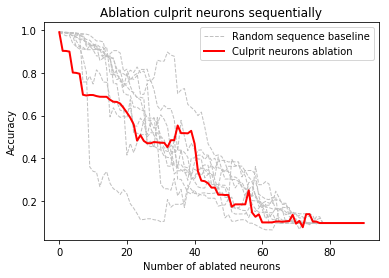

In [63]:
accumulate = True
abl_logs_ration = ablation_test(config, resume, neuron_seq_ratio, accumulate)   

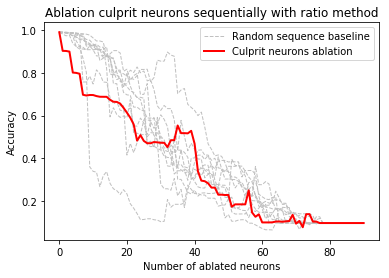

In [64]:
visualize_accumulate(abl_logs_ration, class_specific = False)

In [96]:
accumulate = False
from ablation import *
culprit_method = 'with ratio method'
abl_logs_ratio = ablation_test(config, resume, neuron_seq_ratio, accumulate, culprit_method)   

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6358776545524597, 'overal_acc': 0.9028, 'topk_acc': 0.9266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03557036678791046, 'overal_acc': 0.9883, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03486711256504059, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6483145387649536, 'overal_acc': 0.8907, 'topk_acc': 0.9388}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03532578338384628, 'overal_acc': 0.9882, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034322697067260745, 'overal_acc': 0.9886, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.30729678797721866, 'overal_acc': 0.8989, 'topk_acc': 0.9777}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03417583748102188, 'overal_acc': 0.989, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0852693583726883, 'overal_acc': 0.9732, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03520447289943695, 'overal_acc': 0.9884, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.032086197721958164, 'overal_acc': 0.9893, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05226859356164932, 'overal_acc': 0.9823, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04655653070211411, 'overal_acc': 0.9851, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031259263116121296, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0394590471804142, 'overal_acc': 0.9862, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034502507376670835, 'overal_acc': 0.9891, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03756163477897644, 'overal_acc': 0.9871, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.029401391661167144, 'overal_acc': 0.9901, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03970153714418411, 'overal_acc': 0.9876, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03587184658050537, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08283428483009338, 'overal_acc': 0.9738, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.039962309980392456, 'overal_acc': 0.9881, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04148340683579445, 'overal_acc': 0.9857, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035625475025177, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03445652133226395, 'overal_acc': 0.9875, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03966877326965332, 'overal_acc': 0.9864, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036217901515960695, 'overal_acc': 0.9873, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04956619551181793, 'overal_acc': 0.984, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03570641318559647, 'overal_acc': 0.9876, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03741891345977783, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034312998759746555, 'overal_acc': 0.9891, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04502343519926071, 'overal_acc': 0.9853, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.038410189938545225, 'overal_acc': 0.9866, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.49564056644439697, 'overal_acc': 0.8934, 'topk_acc': 0.9634}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.044773002350330354, 'overal_acc': 0.9843, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0402596998155117, 'overal_acc': 0.987, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04273369071483612, 'overal_acc': 0.9853, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859834461212158, 'overal_acc': 0.9872, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06457240500450134, 'overal_acc': 0.9795, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0346982773900032, 'overal_acc': 0.9894, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5504593586921692, 'overal_acc': 0.8143, 'topk_acc': 0.9525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04667056794166565, 'overal_acc': 0.9829, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0352843132019043, 'overal_acc': 0.9879, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.042924192440509795, 'overal_acc': 0.9858, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03482938501238823, 'overal_acc': 0.9884, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03229573268890381, 'overal_acc': 0.9891, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03596213563680649, 'overal_acc': 0.9878, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.033341321516036984, 'overal_acc': 0.9888, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034120018988847735, 'overal_acc': 0.9891, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03525860931873322, 'overal_acc': 0.9883, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03825215049982071, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03428565344810486, 'overal_acc': 0.9887, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0351900537610054, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.42877229833602903, 'overal_acc': 0.8776, 'topk_acc': 0.9157}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5805545628547668, 'overal_acc': 0.8888, 'topk_acc': 0.9473}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03324262690544128, 'overal_acc': 0.9891, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0318780312538147, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036329493474960325, 'overal_acc': 0.9874, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4791167833328247, 'overal_acc': 0.8916, 'topk_acc': 0.9452}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6616830685615539, 'overal_acc': 0.896, 'topk_acc': 0.9088}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04318471682071686, 'overal_acc': 0.9853, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03381034432053566, 'overal_acc': 0.9884, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03422678092122078, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5084781700134278, 'overal_acc': 0.8945, 'topk_acc': 0.9347}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5059265323162079, 'overal_acc': 0.8939, 'topk_acc': 0.9292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04187137016057968, 'overal_acc': 0.9864, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11158357536792755, 'overal_acc': 0.9599, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03226604549884796, 'overal_acc': 0.989, 'topk_acc': 0.9996}
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03482938501238823, 'overal_acc': 0.9884, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0852693583726883, 'overal_acc': 0.9732, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11158357536792755, 'overal_acc': 0.9599, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08283428483009338, 'overal_acc': 0.9738, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03428565344810486, 'overal_acc': 0.9887, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03525860931873322, 'overal_acc': 0.9883, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0346982773900032, 'overal_acc': 0.9894, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03966877326965332, 'overal_acc': 0.9864, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04318471682071686, 'overal_acc': 0.9853, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06457240500450134, 'overal_acc': 0.9795, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03229573268890381, 'overal_acc': 0.9891, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05226859356164932, 'overal_acc': 0.9823, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.042924192440509795, 'overal_acc': 0.9858, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03741891345977783, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03587184658050537, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03970153714418411, 'overal_acc': 0.9876, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03324262690544128, 'overal_acc': 0.9891, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04148340683579445, 'overal_acc': 0.9857, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03557036678791046, 'overal_acc': 0.9883, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03596213563680649, 'overal_acc': 0.9878, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04667056794166565, 'overal_acc': 0.9829, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03417583748102188, 'overal_acc': 0.989, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.033341321516036984, 'overal_acc': 0.9888, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03226604549884796, 'overal_acc': 0.989, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03570641318559647, 'overal_acc': 0.9876, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.032086197721958164, 'overal_acc': 0.9893, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04655653070211411, 'overal_acc': 0.9851, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.029401391661167144, 'overal_acc': 0.9901, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04273369071483612, 'overal_acc': 0.9853, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5504593586921692, 'overal_acc': 0.8143, 'topk_acc': 0.9525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859834461212158, 'overal_acc': 0.9872, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03381034432053566, 'overal_acc': 0.9884, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034502507376670835, 'overal_acc': 0.9891, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04187137016057968, 'overal_acc': 0.9864, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0394590471804142, 'overal_acc': 0.9862, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034120018988847735, 'overal_acc': 0.9891, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03486711256504059, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.039962309980392456, 'overal_acc': 0.9881, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034322697067260745, 'overal_acc': 0.9886, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04956619551181793, 'overal_acc': 0.984, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03422678092122078, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0352843132019043, 'overal_acc': 0.9879, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034312998759746555, 'overal_acc': 0.9891, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03445652133226395, 'overal_acc': 0.9875, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03520447289943695, 'overal_acc': 0.9884, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.044773002350330354, 'overal_acc': 0.9843, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036329493474960325, 'overal_acc': 0.9874, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035625475025177, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0351900537610054, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03532578338384628, 'overal_acc': 0.9882, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031259263116121296, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0402596998155117, 'overal_acc': 0.987, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0318780312538147, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036217901515960695, 'overal_acc': 0.9873, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04502343519926071, 'overal_acc': 0.9853, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03756163477897644, 'overal_acc': 0.9871, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03825215049982071, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


100%|██████████| 20/20 [00:00<00:00, 30.57it/s]

{'loss': 0.038410189938545225, 'overal_acc': 0.9866, 'topk_acc': 0.9994}


0.9898 80 90


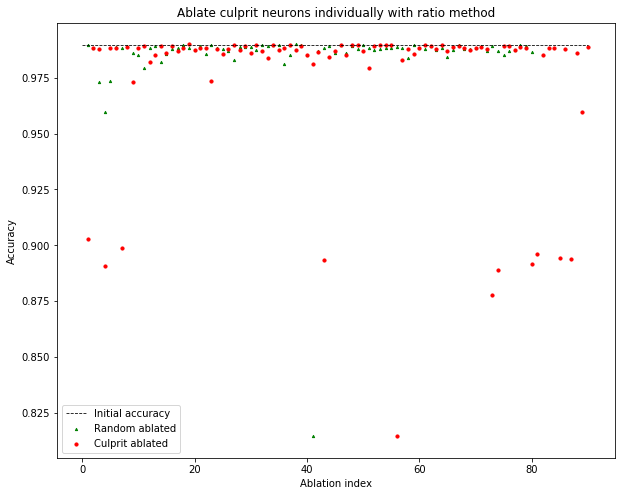

In [120]:
from ablation import *
visualize_individual_ablation(abl_logs_ratio, culprit_method)

  0%|          | 0/20 [00:00<?, ?it/s]

*** the activation map shape is: [torch.Size([512, 10, 24, 24]), torch.Size([512, 20, 8, 8]), torch.Size([512, 50]), torch.Size([512, 10])] .
*** data loaded ***
*** label size is torch.Size([10000]), positive label ratio is 9898.
*** feature shape is torch.Size([10000, 90]).
*** right_actv shape is torch.Size([9898, 90]), wrong_actv shape is torch.Size([102, 90]).
*** x of shape torch.Size([10000, 90]) is normalized column wise. Before normalize, sum of mean and std for each col are: 30.792844772338867, 416.55279541015625. After normalize: 1.8770639144349843e-05, 90.0.


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6358776545524597, 'overal_acc': 0.9028, 'topk_acc': 0.9266}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5805545628547668, 'overal_acc': 0.8888, 'topk_acc': 0.9473}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.42877229833602903, 'overal_acc': 0.8776, 'topk_acc': 0.9157}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03557036678791046, 'overal_acc': 0.9883, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04318471682071686, 'overal_acc': 0.9853, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0352843132019043, 'overal_acc': 0.9879, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6483145387649536, 'overal_acc': 0.8907, 'topk_acc': 0.9388}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03445652133226395, 'overal_acc': 0.9875, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04273369071483612, 'overal_acc': 0.9853, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.032086197721958164, 'overal_acc': 0.9893, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03229573268890381, 'overal_acc': 0.9891, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08283428483009338, 'overal_acc': 0.9738, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5504593586921692, 'overal_acc': 0.8143, 'topk_acc': 0.9525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04502343519926071, 'overal_acc': 0.9853, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0852693583726883, 'overal_acc': 0.9732, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034322697067260745, 'overal_acc': 0.9886, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03520447289943695, 'overal_acc': 0.9884, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.029401391661167144, 'overal_acc': 0.9901, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035625475025177, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03587184658050537, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03532578338384628, 'overal_acc': 0.9882, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5059265323162079, 'overal_acc': 0.8939, 'topk_acc': 0.9292}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03970153714418411, 'overal_acc': 0.9876, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0394590471804142, 'overal_acc': 0.9862, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.044773002350330354, 'overal_acc': 0.9843, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859834461212158, 'overal_acc': 0.9872, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03381034432053566, 'overal_acc': 0.9884, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034120018988847735, 'overal_acc': 0.9891, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05226859356164932, 'overal_acc': 0.9823, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.49564056644439697, 'overal_acc': 0.8934, 'topk_acc': 0.9634}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0318780312538147, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034502507376670835, 'overal_acc': 0.9891, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03570641318559647, 'overal_acc': 0.9876, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.039962309980392456, 'overal_acc': 0.9881, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.6616830685615539, 'overal_acc': 0.896, 'topk_acc': 0.9088}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11158357536792755, 'overal_acc': 0.9599, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.033341321516036984, 'overal_acc': 0.9888, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03741891345977783, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034312998759746555, 'overal_acc': 0.9891, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.30729678797721866, 'overal_acc': 0.8989, 'topk_acc': 0.9777}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031259263116121296, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04956619551181793, 'overal_acc': 0.984, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.038410189938545225, 'overal_acc': 0.9866, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03428565344810486, 'overal_acc': 0.9887, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03756163477897644, 'overal_acc': 0.9871, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03966877326965332, 'overal_acc': 0.9864, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03482938501238823, 'overal_acc': 0.9884, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04655653070211411, 'overal_acc': 0.9851, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04667056794166565, 'overal_acc': 0.9829, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03417583748102188, 'overal_acc': 0.989, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036217901515960695, 'overal_acc': 0.9873, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5084781700134278, 'overal_acc': 0.8945, 'topk_acc': 0.9347}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03525860931873322, 'overal_acc': 0.9883, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03825215049982071, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03486711256504059, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0346982773900032, 'overal_acc': 0.9894, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.4791167833328247, 'overal_acc': 0.8916, 'topk_acc': 0.9452}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03324262690544128, 'overal_acc': 0.9891, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036329493474960325, 'overal_acc': 0.9874, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0351900537610054, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03596213563680649, 'overal_acc': 0.9878, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0402596998155117, 'overal_acc': 0.987, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.042924192440509795, 'overal_acc': 0.9858, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03226604549884796, 'overal_acc': 0.989, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04187137016057968, 'overal_acc': 0.9864, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06457240500450134, 'overal_acc': 0.9795, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04148340683579445, 'overal_acc': 0.9857, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03422678092122078, 'overal_acc': 0.9886, 'topk_acc': 0.9997}
abl_seq length 10
abl_seq length 30
abl_seq length 80


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.5504593586921692, 'overal_acc': 0.8143, 'topk_acc': 0.9525}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03087801090478897, 'overal_acc': 0.9896, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03546132640838623, 'overal_acc': 0.9884, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06457240500450134, 'overal_acc': 0.9795, 'topk_acc': 0.9984}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.038410189938545225, 'overal_acc': 0.9866, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03557036678791046, 'overal_acc': 0.9883, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03580454709529877, 'overal_acc': 0.9881, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859731904268265, 'overal_acc': 0.9871, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03474699020385742, 'overal_acc': 0.989, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03445652133226395, 'overal_acc': 0.9875, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03417583748102188, 'overal_acc': 0.989, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.032086197721958164, 'overal_acc': 0.9893, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.039962309980392456, 'overal_acc': 0.9881, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.11158357536792755, 'overal_acc': 0.9599, 'topk_acc': 0.998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0351900537610054, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04187137016057968, 'overal_acc': 0.9864, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04273369071483612, 'overal_acc': 0.9853, 'topk_acc': 0.9993}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0346982773900032, 'overal_acc': 0.9894, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.08283428483009338, 'overal_acc': 0.9738, 'topk_acc': 0.9982}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04318471682071686, 'overal_acc': 0.9853, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034322697067260745, 'overal_acc': 0.9886, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031259263116121296, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03482938501238823, 'overal_acc': 0.9884, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04502343519926071, 'overal_acc': 0.9853, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.033341321516036984, 'overal_acc': 0.9888, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03970153714418411, 'overal_acc': 0.9876, 'topk_acc': 0.9992}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034120018988847735, 'overal_acc': 0.9891, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.029401391661167144, 'overal_acc': 0.9901, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.05226859356164932, 'overal_acc': 0.9823, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03520447289943695, 'overal_acc': 0.9884, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03315911674499512, 'overal_acc': 0.9882, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03966877326965332, 'overal_acc': 0.9864, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04956619551181793, 'overal_acc': 0.984, 'topk_acc': 0.9991}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03226604549884796, 'overal_acc': 0.989, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.035625475025177, 'overal_acc': 0.988, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034015611577034, 'overal_acc': 0.9877, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03422678092122078, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03532578338384628, 'overal_acc': 0.9882, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03486711256504059, 'overal_acc': 0.988, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0402596998155117, 'overal_acc': 0.987, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.031082919180393218, 'overal_acc': 0.9894, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036217901515960695, 'overal_acc': 0.9873, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.044773002350330354, 'overal_acc': 0.9843, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.042924192440509795, 'overal_acc': 0.9858, 'topk_acc': 0.9989}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03229573268890381, 'overal_acc': 0.9891, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03587184658050537, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03825215049982071, 'overal_acc': 0.9875, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03741891345977783, 'overal_acc': 0.9886, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03525860931873322, 'overal_acc': 0.9883, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034312998759746555, 'overal_acc': 0.9891, 'topk_acc': 0.9995}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03596213563680649, 'overal_acc': 0.9878, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03324262690544128, 'overal_acc': 0.9891, 'topk_acc': 0.9999}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04667056794166565, 'overal_acc': 0.9829, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03428565344810486, 'overal_acc': 0.9887, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03859834461212158, 'overal_acc': 0.9872, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03381034432053566, 'overal_acc': 0.9884, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03484380431175232, 'overal_acc': 0.9885, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.036329493474960325, 'overal_acc': 0.9874, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0318780312538147, 'overal_acc': 0.9895, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04655653070211411, 'overal_acc': 0.9851, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03570641318559647, 'overal_acc': 0.9876, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.034502507376670835, 'overal_acc': 0.9891, 'topk_acc': 0.9997}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0852693583726883, 'overal_acc': 0.9732, 'topk_acc': 0.9987}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0352843132019043, 'overal_acc': 0.9879, 'topk_acc': 0.9994}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.04148340683579445, 'overal_acc': 0.9857, 'topk_acc': 0.9996}


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.03756163477897644, 'overal_acc': 0.9871, 'topk_acc': 0.9997}


100%|██████████| 20/20 [00:00<00:00, 34.91it/s]


{'loss': 0.0394590471804142, 'overal_acc': 0.9862, 'topk_acc': 0.9996}
0.9898 80 90


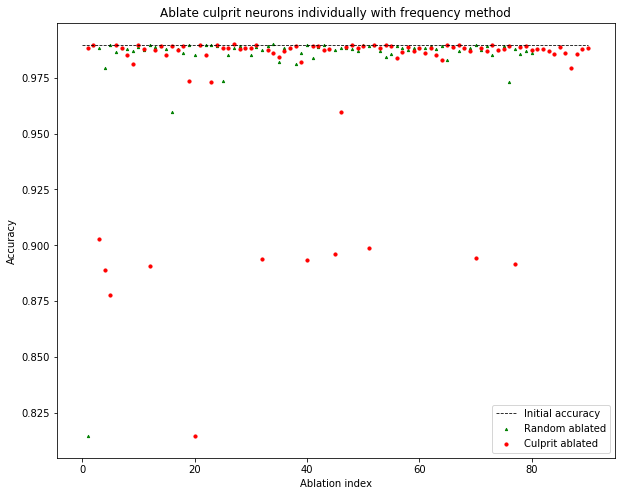

[((None, None),
  {'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998}),
 [[((1, 14),
    {'loss': 0.0350039317369461, 'overal_acc': 0.9885, 'topk_acc': 0.9996})],
  [((2, 11),
    {'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998})],
  [((3, 5),
    {'loss': 0.6358776545524597, 'overal_acc': 0.9028, 'topk_acc': 0.9266})],
  [((3, 2),
    {'loss': 0.5805545628547668, 'overal_acc': 0.8888, 'topk_acc': 0.9473})],
  [((3, 1),
    {'loss': 0.42877229833602903, 'overal_acc': 0.8776, 'topk_acc': 0.9157})],
  [((2, 32),
    {'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.9998})],
  [((1, 4),
    {'loss': 0.03557036678791046, 'overal_acc': 0.9883, 'topk_acc': 0.9996})],
  [((2, 6),
    {'loss': 0.04318471682071686, 'overal_acc': 0.9853, 'topk_acc': 0.9992})],
  [((1, 6),
    {'loss': 0.06251868389844895, 'overal_acc': 0.9814, 'topk_acc': 0.9987})],
  [((2, 49),
    {'loss': 0.030507081687450407, 'overal_acc': 0.9898, 'topk_acc': 0.99

In [123]:
from ablation import *
culprit_method = 'with frequency method'
accumulate = False
# get culprit score from the activation map
clpt = CulpritNeuronScore('./saved/') 
score = clpt.culprit_freq()
neuron_seq, score =  clpt.get_rank(score)

ablation_test(config, resume, neuron_seq, accumulate, culprit_method)
#visualize_individual_ablation(abl_logs, culprit_method)